# An Initial Exploration of LIV Experiment: MSCs Morphology Using Afilament Program Output


This Jupyter Notebook concentrates on the comprehensive statistical analysis of Mesenchymal stem cells subjected to low-intensity vibration (LIV). We will particularly examine the morphological changes within the cells and their potential functional implications, utilizing the output data from the Afilament program, a tool developed in our lab for intricate analysis of confocal microscopy images.

### Overview of the Afilament Program:
The Afilament program is an innovative tool performing an exhaustive analysis of confocal microscopy images. It is designed to extract and quantify actin fiber and nucleus morphology, thus offering deep insights into cellular structure and dynamics.

### Key features of the Afilament program include:

- Comprehensive analysis of cell images, extracting crucial morphological data about actin fibers and cell nuclei.
- User-configurable parameters, such as a minimum fiber length cut-off.
- Advanced segmentation capabilities, supporting different models for actin filament segmentation.
- Detailed statistics output for further analytical exploration.

### Experimental Procedure:
Our experiment encompassed two groups of cells: the LIV treated cells and a control group. We captured confocal microscopy images for both groups, using DAPI for nuclei and phalloidin for actin labeling. This resulted in 20 images for LIV treated cells and 16 images for control cells, each comprising multiple cells. Processing these images with the Afilament program yielded data on 102 control cells and 110 LIV treated cells.

### Datasets for Statistical Analysis in this Notebook:
We will conduct an exhaustive exploration and interpretation of the output data from the Afilament program across six datasets, each offering a unique perspective on cellular morphology:

Dataset 1: Fiber length cut-off 0.5 micrometers, actin model w20.
Dataset 2: Fiber length cut-off 1 micrometer, actin model w20.
Dataset 3: Fiber length cut-off 2 micrometers, actin model w20.
Dataset 4: Fiber length cut-off 0.5 micrometers, actin model w200.
Dataset 5: Fiber length cut-off 1 micrometer, actin model w200.
Dataset 6: Fiber length cut-off 2 micrometers, actin model w200.

Each of these datasets will be scrutinized to understand the morphological changes that Mesochemal stem cells undergo when subjected to low intensity vibrations. We aim to enrich our understanding of cell mechanobiology and potentially offer insights that could inform therapeutic strategies in regenerative medicine.

## Data Loading and Preprocessing

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
from itertools import product
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In this notebook, we perform data loading and preprocessing for our biological experiment analysis. We handle two types of data: aggregated statistics and individual actin fiber statistics.

- **Aggregated Statistics:** These statistics summarize the results of each experimental trial, run by the user with different configurations for minimum actin length and different models for actin (w20 and w200). The ***load_aggregated_statistics()*** function loads this data from the given directory path. It extracts metadata such as minimum length, treatment, and actin model from the directory path, and adds these as additional columns in the resulting DataFrame.

- **Individual Actin Fiber Statistics:** These statistics provide a more granular view, presenting the data for each actin fiber that is longer than a user-specified threshold. This allows us to observe the specific distribution for all fibers. The ***load_individual_actin_statistics()*** function handles this type of data, loading and preprocessing it in a similar way to the aggregated statistics, but also including image number, cell number, and part details.

The notebook dynamically generates directory paths based on a provided base directory, treatments, models, and minimum lengths. It then loads and concatenates the data from all these directories into two comprehensive DataFrames: one for aggregated statistics and one for individual actin fiber statistics.

With these preprocessing steps, our data is ready for deeper exploration and analysis.

In [2]:
# Constants
AGGREGATED_STATISTICS_FILE = 'agg_stat/cell_stat.csv'
ACTIN_STATISTICS_DIRECTORY = 'actin_stat'

def extract_directory_info(directory):
    """
    Extract directory information such as minimum length, treatment and model.

    Parameters:
    directory (str): The directory path.

    Returns:
    Tuple[str]: A tuple containing min_len, treatment and model as strings.
    """
    directory = Path(directory)
    min_len, treatment, model = directory.name.split("_")[-1], *directory.parent.name.split("_")
    return min_len, treatment, model

def load_aggregated_statistics(directory):
    """
    Load and process aggregated statistics from the specified directory.
    """
    min_len, treatment, model = extract_directory_info(directory)

    # Load the CSV file into a pandas DataFrame
    statistics_df = pd.read_csv(directory / AGGREGATED_STATISTICS_FILE)

    # Remove rows with all NaN values
    statistics_df = statistics_df.dropna(how='all')

    # Add the minimum length, treatment, and model details as new columns in the DataFrame
    statistics_df = statistics_df.assign(
        min_len_threshold=min_len,
        treatment=treatment,
        actin_model=model
    )

    return statistics_df

def load_individual_actin_statistics(base_directory):
    """
    Load individual actin statistics from the specified base directory.
    """
    base_directory = Path(base_directory)
    min_len, treatment, model = extract_directory_info(base_directory)

    actin_statistics_dir = base_directory / ACTIN_STATISTICS_DIRECTORY

    dataframes = []
    for file_name in actin_statistics_dir.iterdir():
        # Example of file_name.stem is img_num_0__cell_num_0_bottom_actin_stat
        # Extract 'img_num', 'cell_num' and 'part' from the filename
        img_num_index, cell_num_index, part_index = 2, 6, 7
        img_num, cell_num = map(int, [file_name.stem.split('_')[i] for i in (img_num_index, cell_num_index)])
        part = file_name.stem.split('_')[part_index]

        current_df = pd.read_csv(file_name)
        current_df = current_df.dropna(how='all')

        # Add the image number, cell number and part details as new columns in the DataFrame
        current_df = current_df.assign(
            img_num=img_num,
            cell_num=cell_num,
            part=part
        )
        dataframes.append(current_df)

    combined_df = pd.concat(dataframes)

    combined_df = combined_df.assign(
        min_len_threshold=min_len,
        treatment=treatment,
        actin_model=model
    )

    return combined_df

# Define base directory
base_directory = Path(r"D:\BioLab\Current_experiments\afilament\2023.02.14_DAPI_Alexa488_LIV_Experiment\Second_trial")

# Define treatments, models, and minimum lengths
treatments = ["Control", "LIV"]
models = ["w200", "w20"]
min_lengths = ["0.5", "1", "2"]

# Generate the list of directories
directories = [base_directory / f"{treatment}_{model}" / f"analysis_data_min_len_{min_length}"
               for treatment in treatments
               for model in models
               for min_length in min_lengths]

# Load and concatenate the data from all directories into a single DataFrame
aggregated_statistics_df = pd.concat([load_aggregated_statistics(directory)
                                      for directory in directories], ignore_index=True)

# Load and concatenate the individual actin data from all directories into a single DataFrame
individual_actin_statistics_df = pd.concat([load_individual_actin_statistics(directory)
                                            for directory in directories], ignore_index=True)

In [3]:
individual_actin_statistics_df.columns.values

array(['ID', 'Actin Length', 'Actin Xsection', 'Actin Volume',
       'Number of fiber layers', 'Intensity', 'img_num', 'cell_num',
       'part', 'min_len_threshold', 'treatment', 'actin_model'],
      dtype=object)

## Nucleus Morphology Analysis

This section delves into the exploration of nuclear morphology of control and LIV-treated MSCs. It involves visualizing the data distributions using histograms and conducting t-tests to identify significant differences between the control and LIV groups. The data processed here consists of aggregated statistics derived from **102 control cells and 110 LIV-treated cells**.

In [10]:
def plot_nucleus_histograms():
    nucleus_columns = ["Nucleus_volume, cubic_micrometre", "Nucleus_length, micrometre",
                       "Nucleus_width, micrometre", "Nucleus_high, micrometre",
                       "Nucleus_total_intensity"]

    # Create a 3x2 grid of subplots
    fig, axs = plt.subplots(3, 2, figsize=(14, 18))
    axs = axs.flatten()  # flatten to make indexing easier
    plt.rcParams.update({'font.size': 15})

    # Filter the DataFrame to include only a single condition (for instance min_len_threshold = 0.5 and actin_model = w20)
    filtered_df = aggregated_statistics_df[(aggregated_statistics_df['min_len_threshold'] == '0.5') &
                                           (aggregated_statistics_df['actin_model'] == 'w20')]

    for i, column in enumerate(nucleus_columns):
        treatments = ["Control", "LIV"]
        ax = axs[i]  # current subplot

        for treatment in treatments:
            data = filtered_df[filtered_df['treatment'] == treatment][column]
            ax.hist(data, bins=20, alpha=0.5, label=f'{treatment}, mean={data.mean():.2f}')

        ax.set_title(column)
        ax.legend()
        # Perform t-test
        control_data = filtered_df[filtered_df['treatment'] == "Control"][column]
        liv_data = filtered_df[filtered_df['treatment'] == "LIV"][column]
        t_stat, p_val = ttest_ind(control_data, liv_data)

    plt.tight_layout()
    fig.savefig(f"figures/nucleus_histogram.png")  # save figure as png
    plt.show()


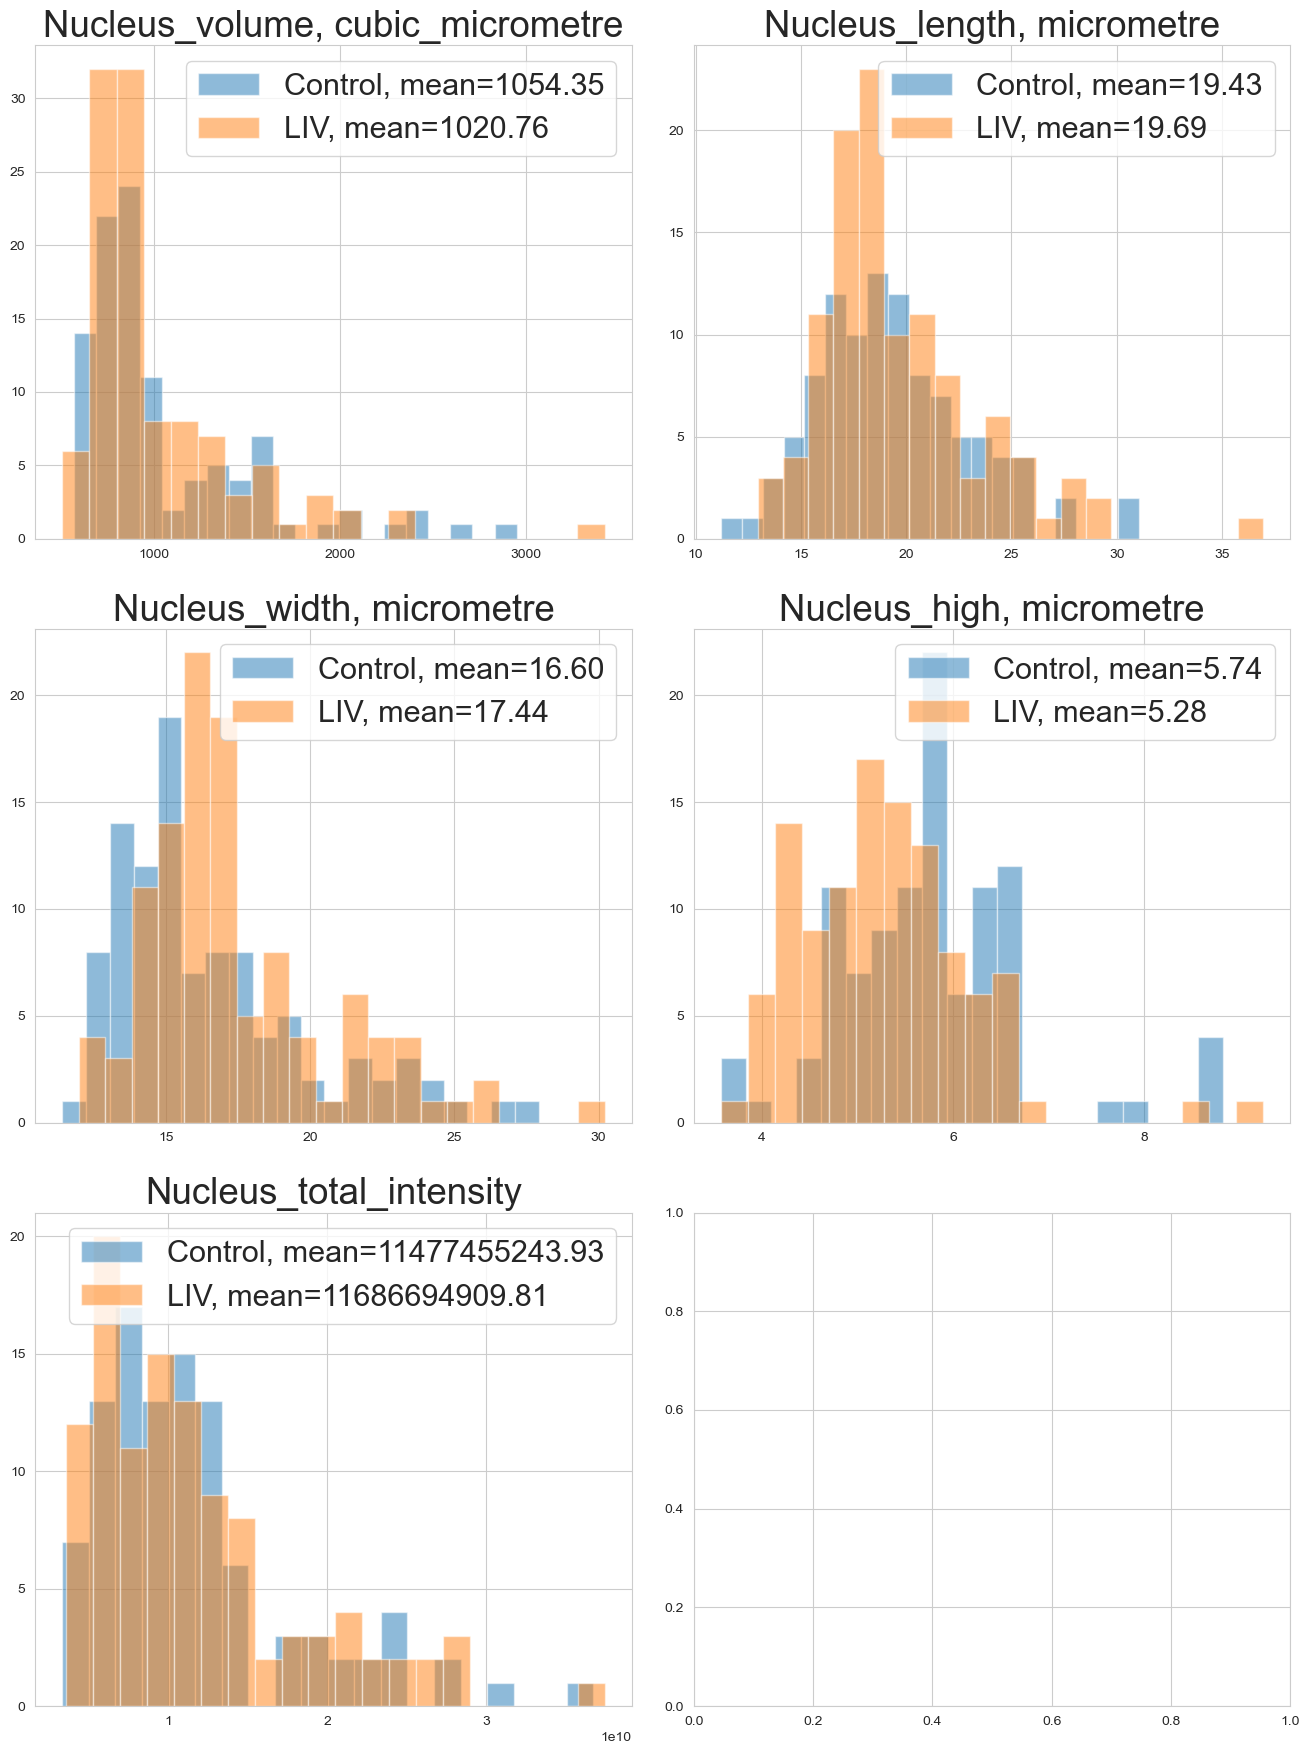

In [11]:
plot_nucleus_histograms()

## Aggregated Actin Morphology Distribution Analysis for MSCs under Control and LIV Treatments

This section is dedicated to the statistical exploration of the aggregated actin morphology. It involves visualizing the data distributions using histograms and conducting t-tests to identify significant differences between the control and LIV groups. The data processed here consists of aggregated statistics derived from **102 control cells and 110 LIV-treated cells**.

In [6]:
# Define treatments, actin models, min_length thresholds and colors for treatments
treatments = ['Control', 'LIV']
actin_models = ['w20', 'w200']
min_lengths = ['0.5', '1', '2']
colors = ['blue', 'orange']

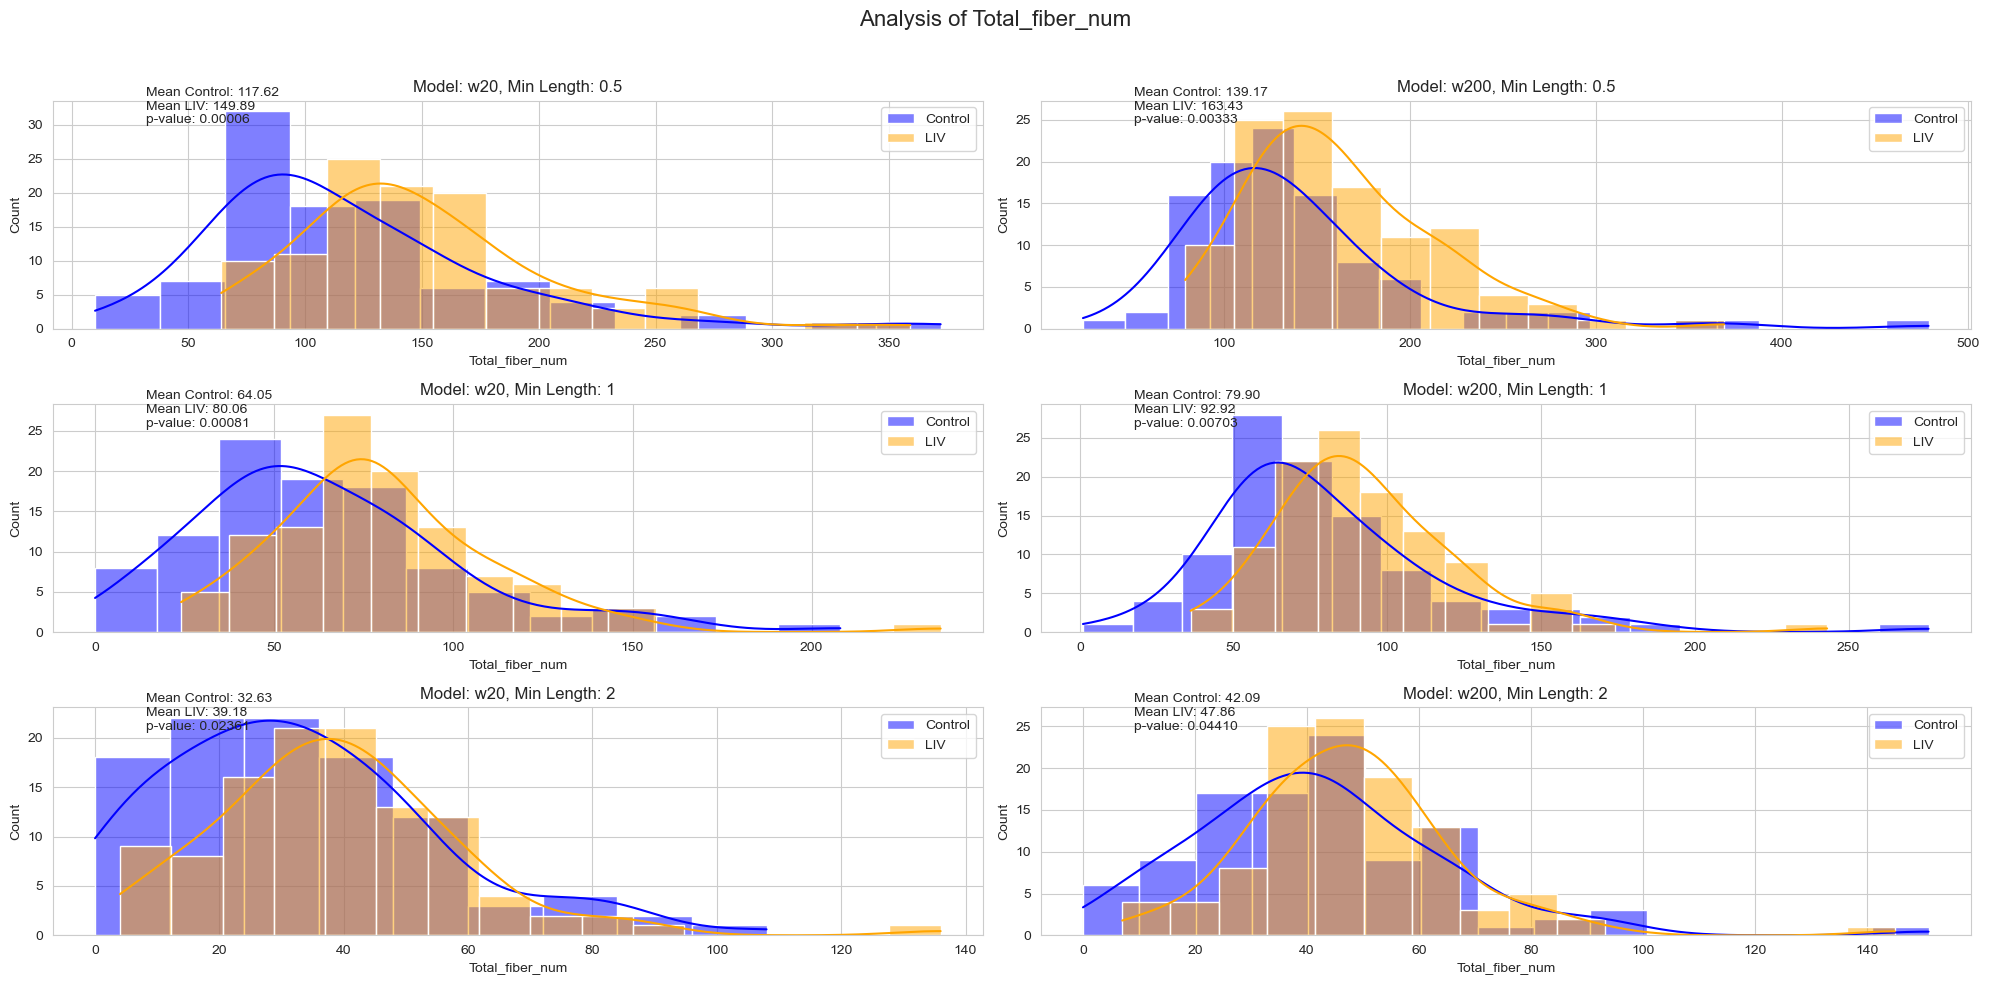

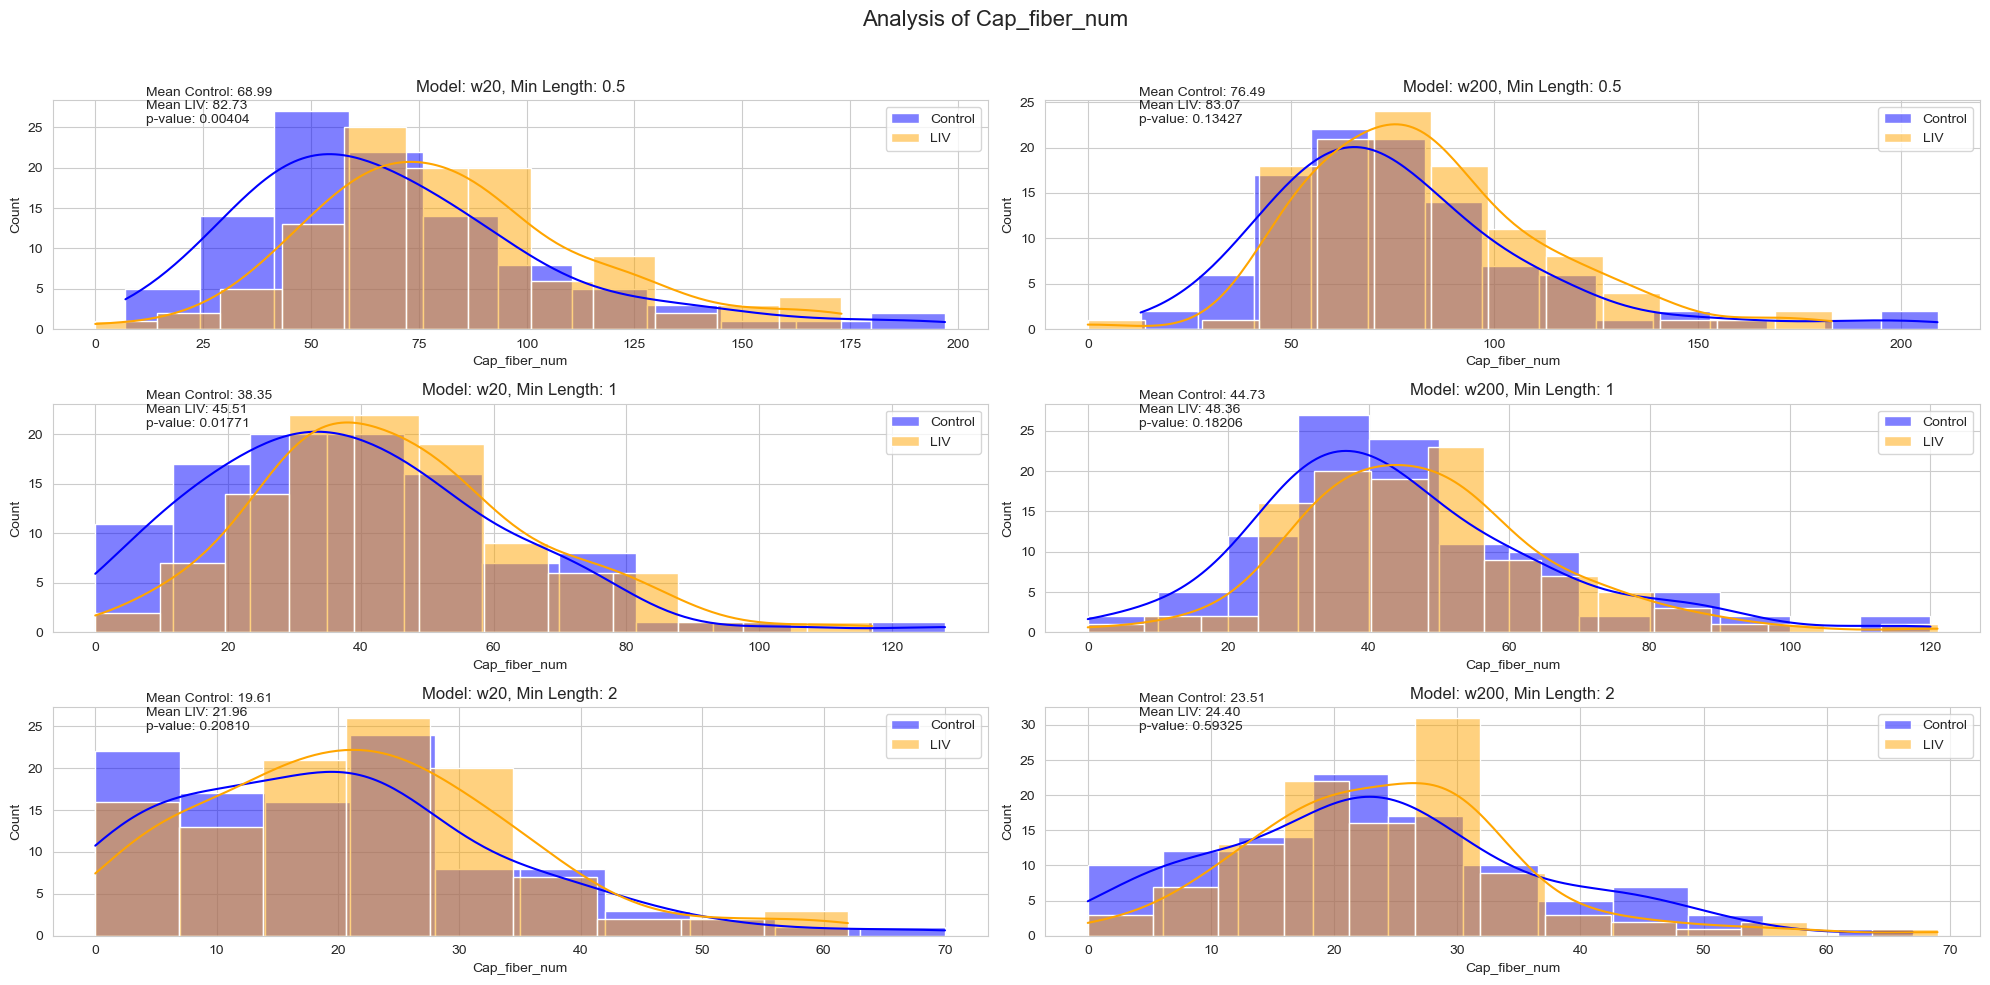

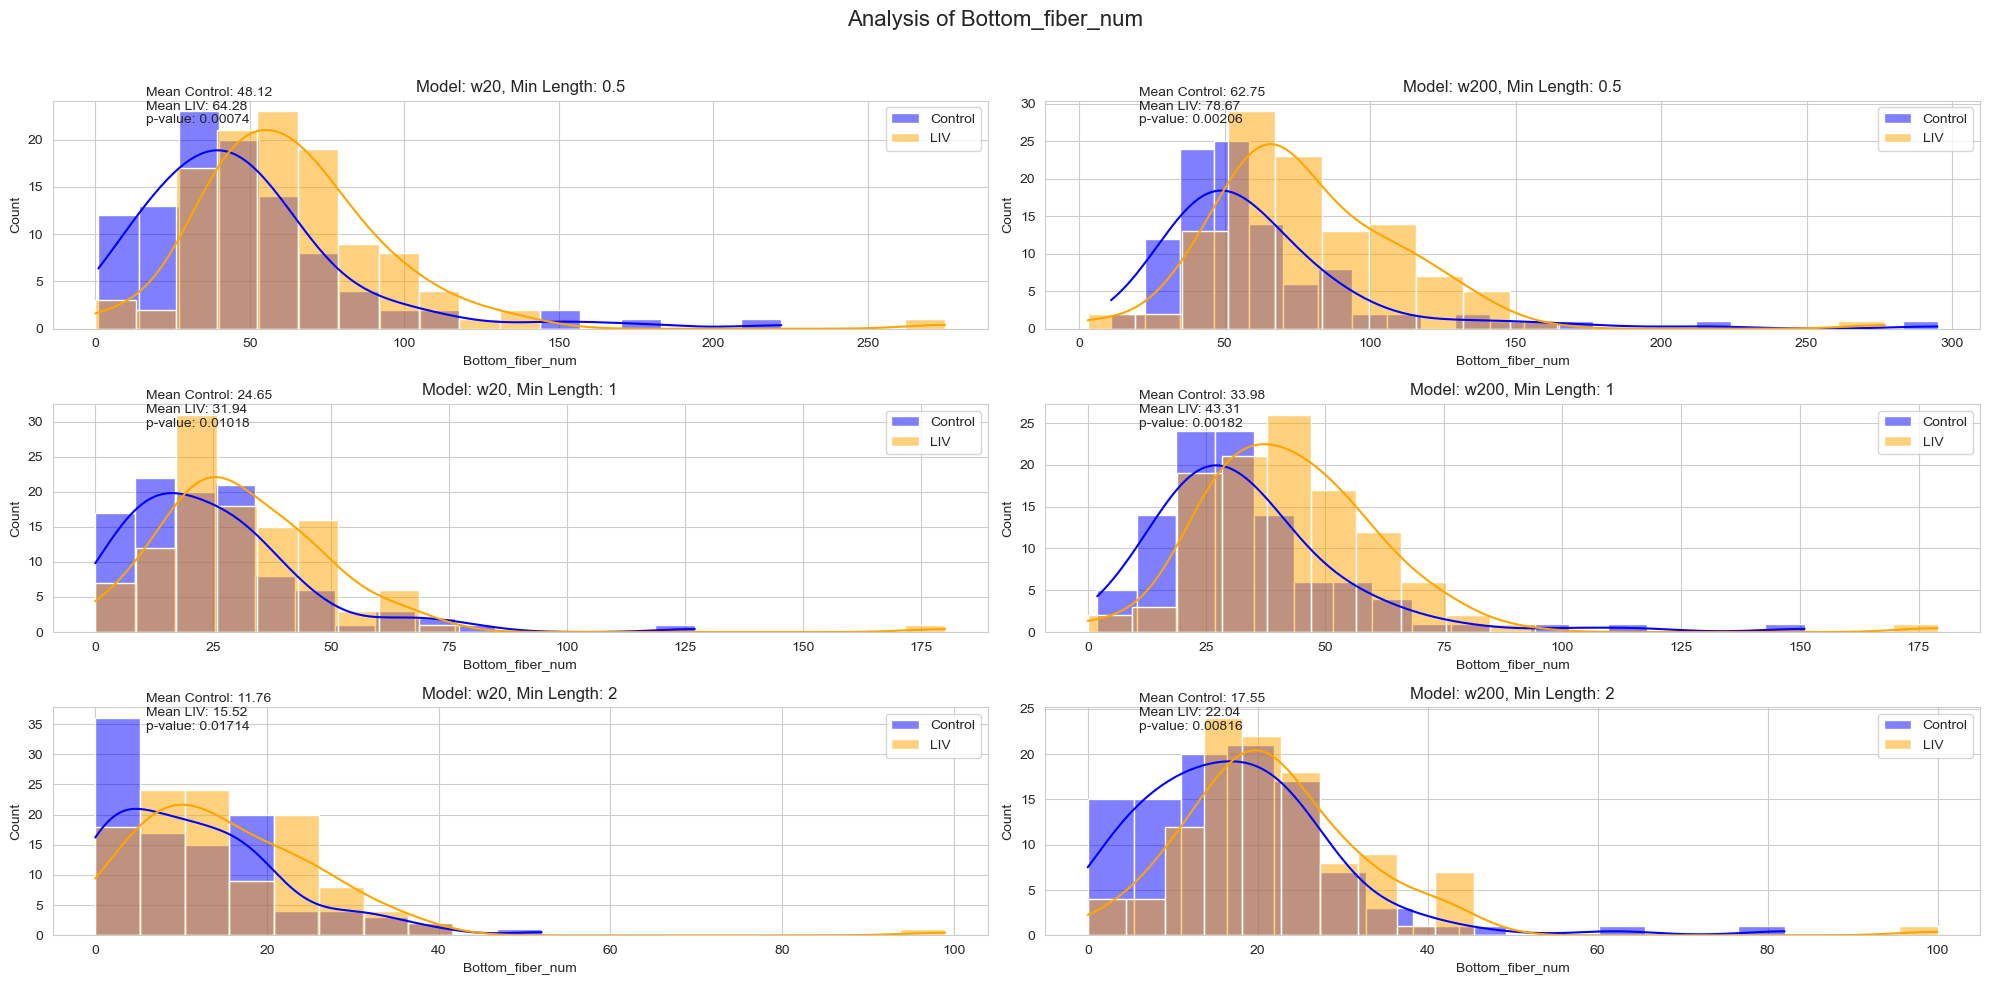

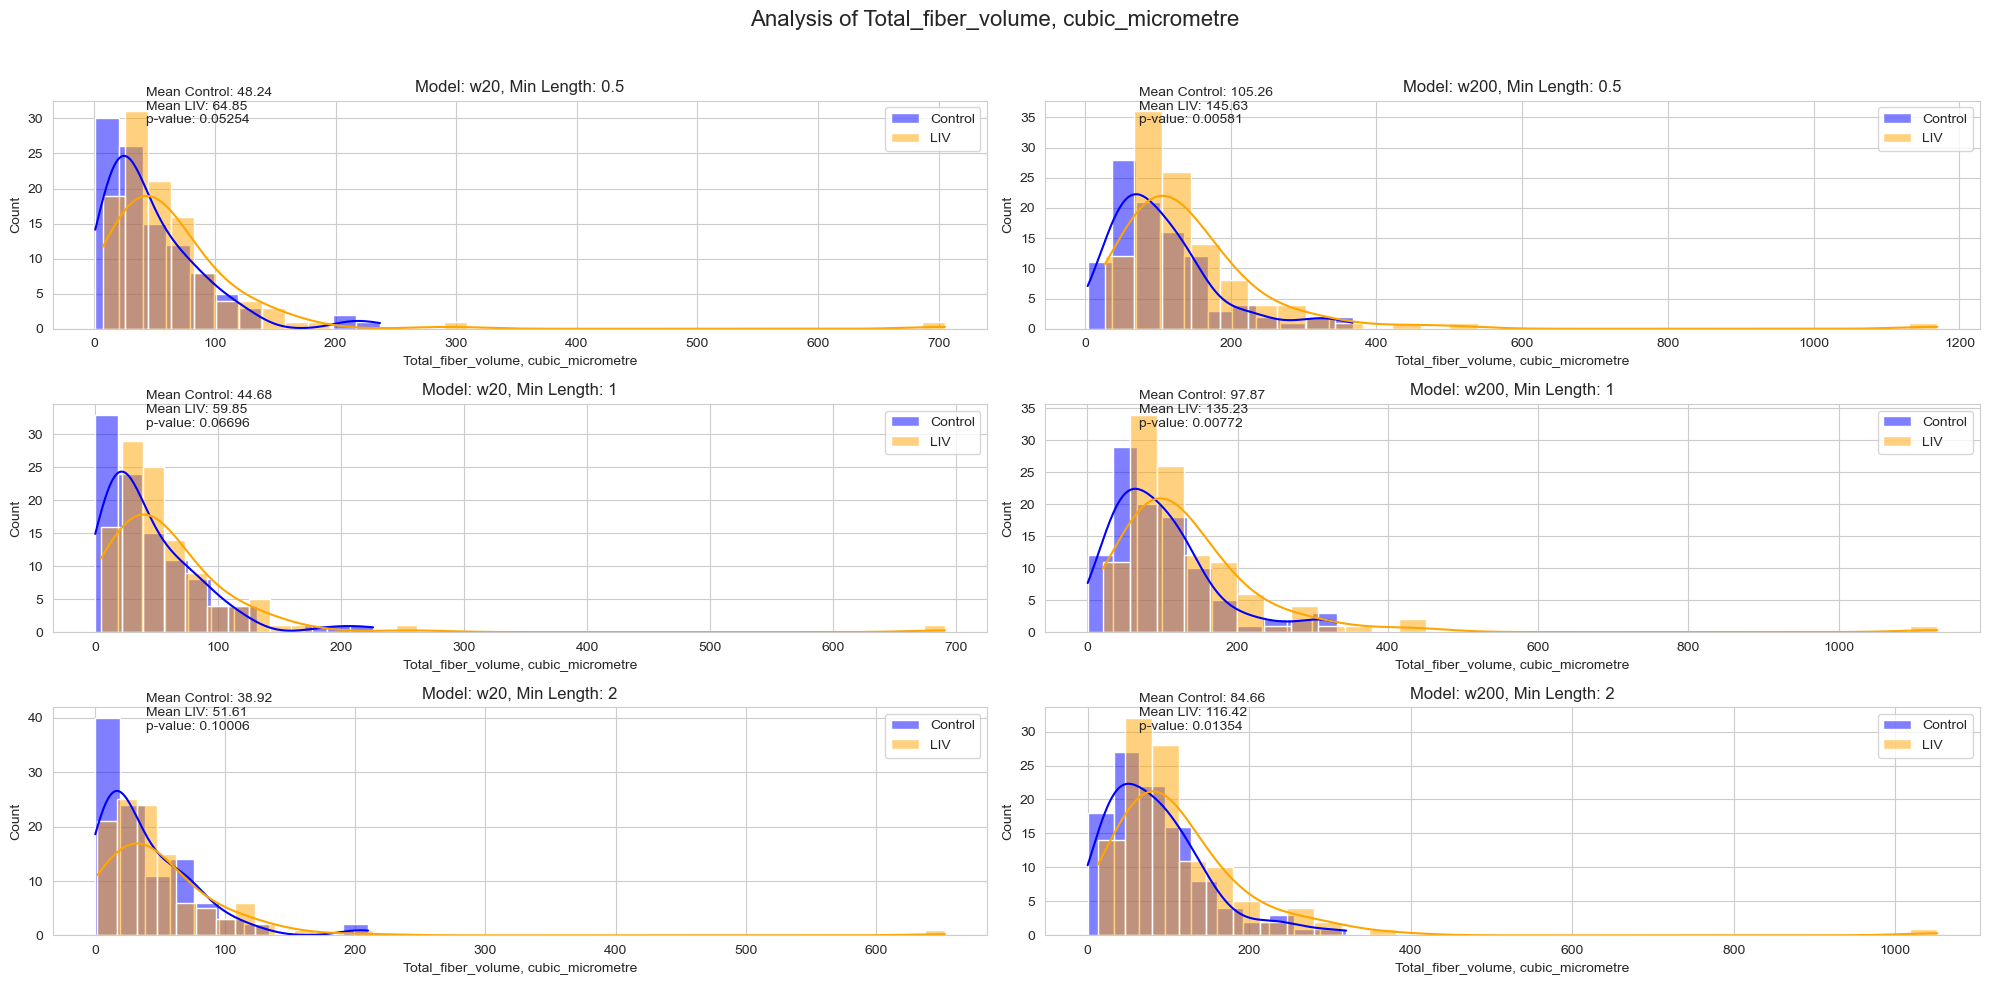

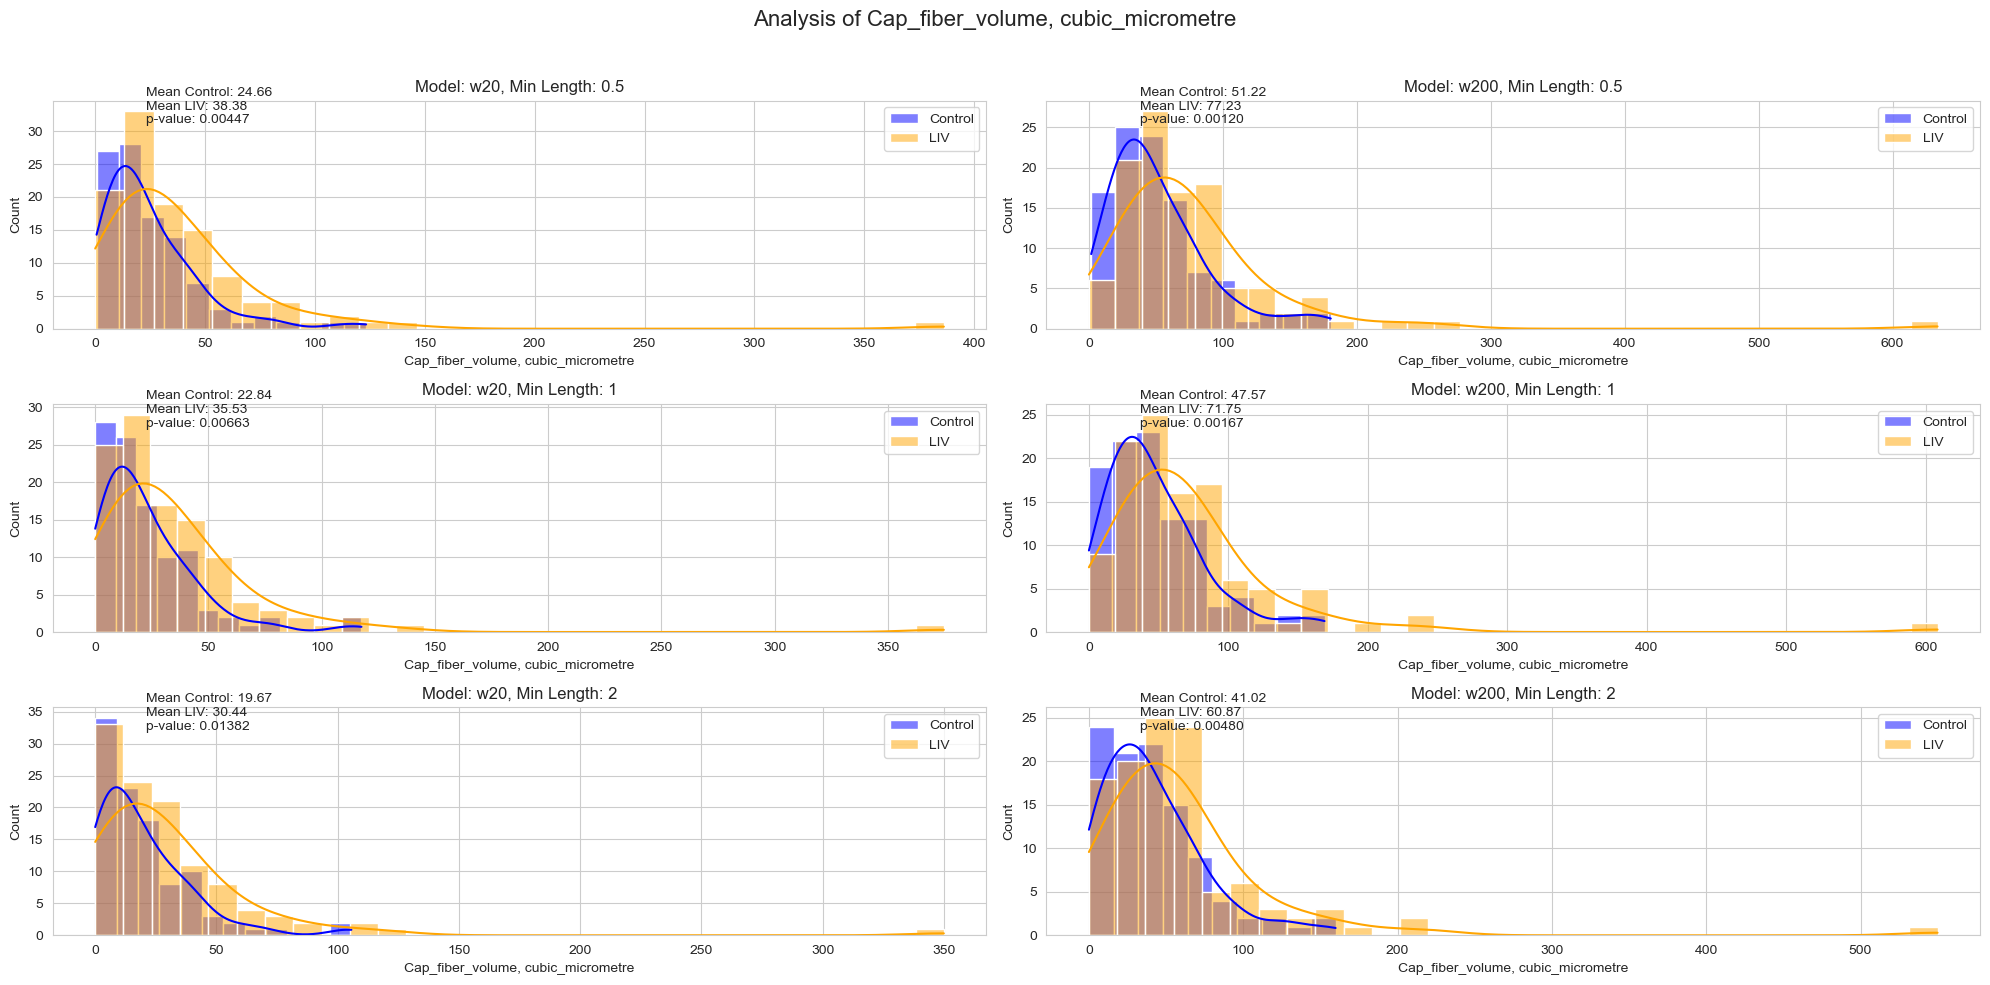

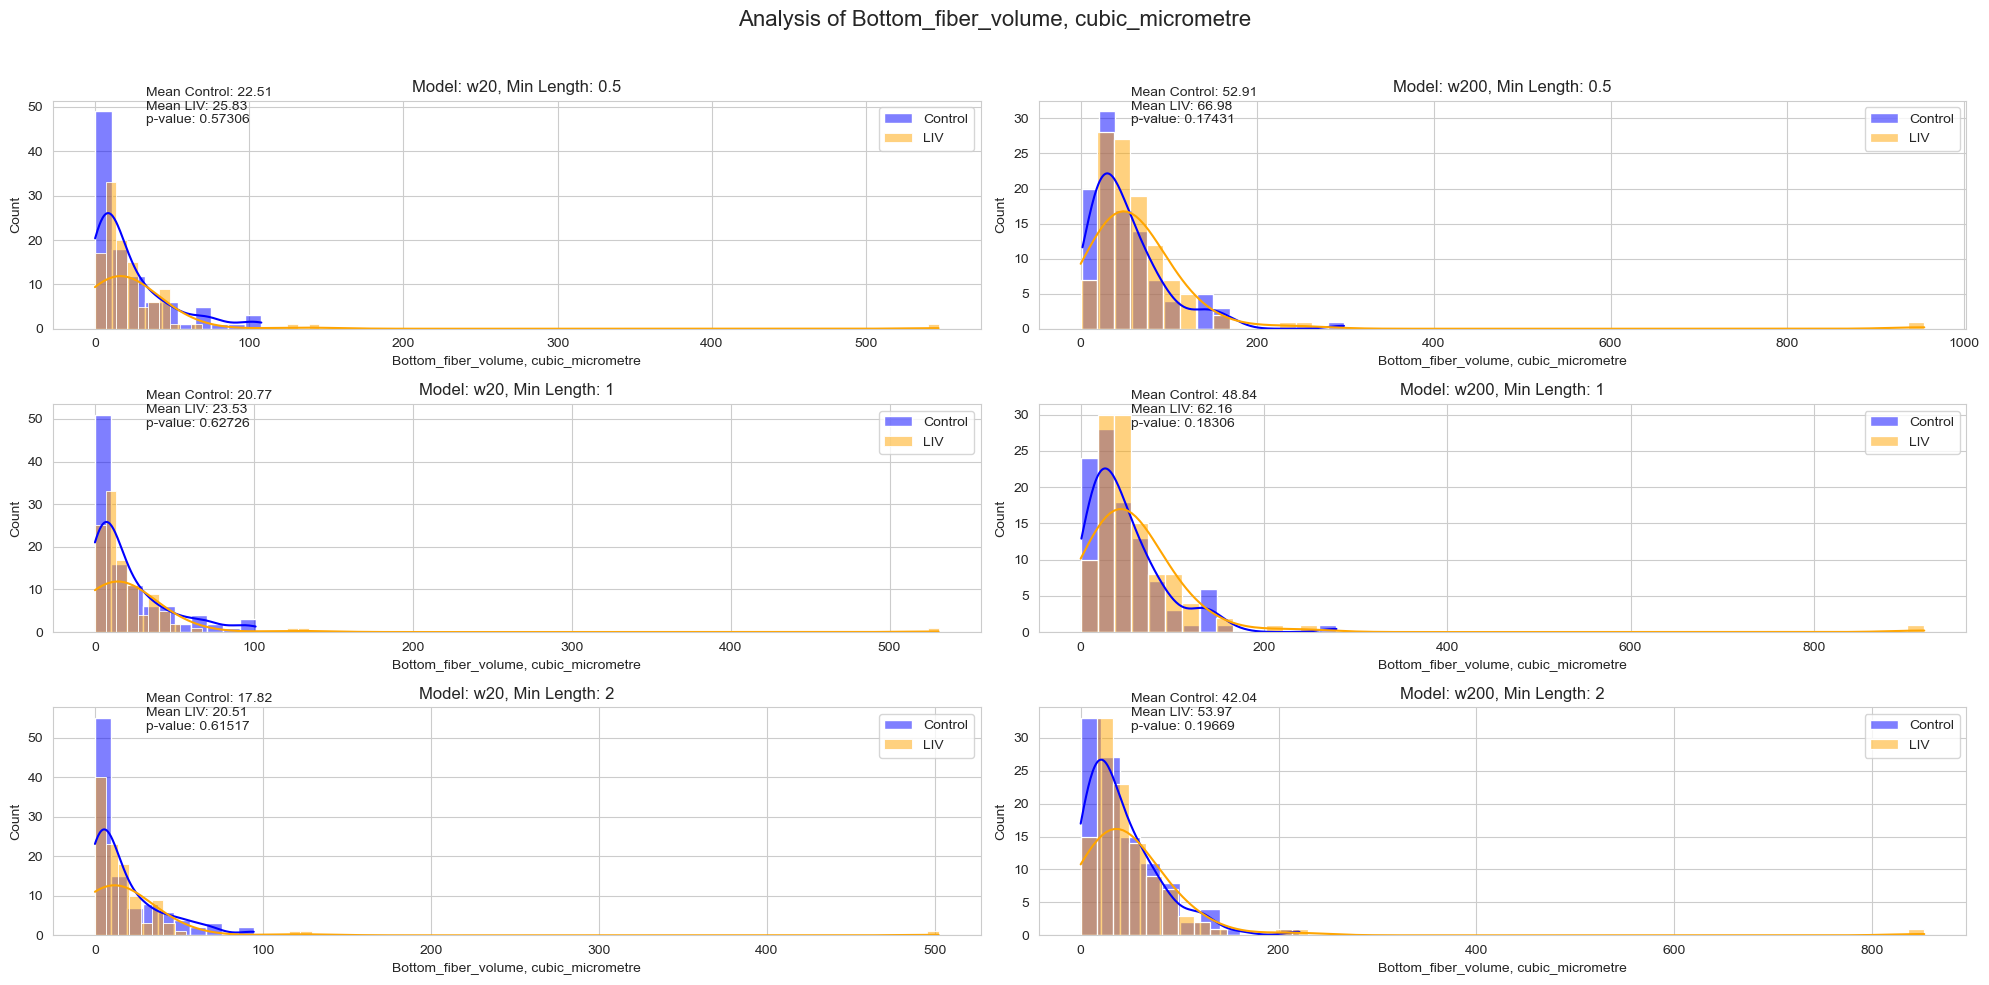

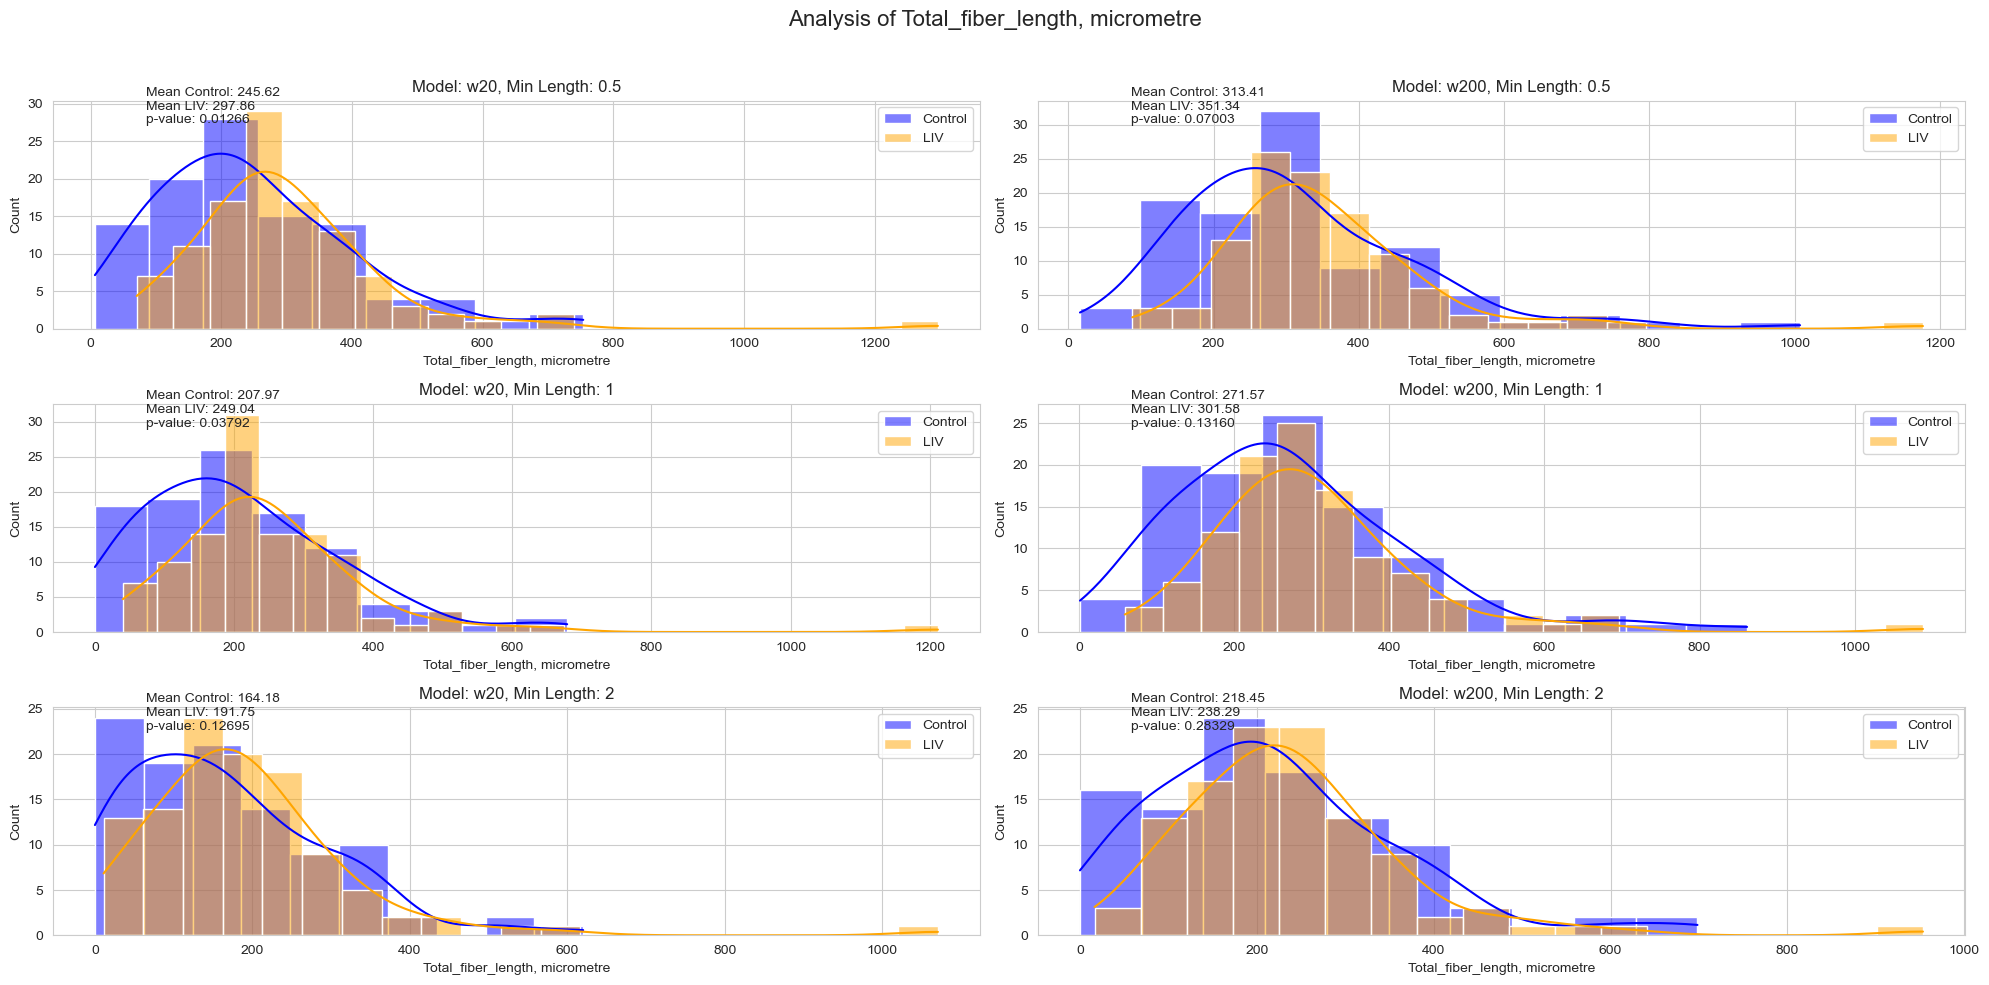

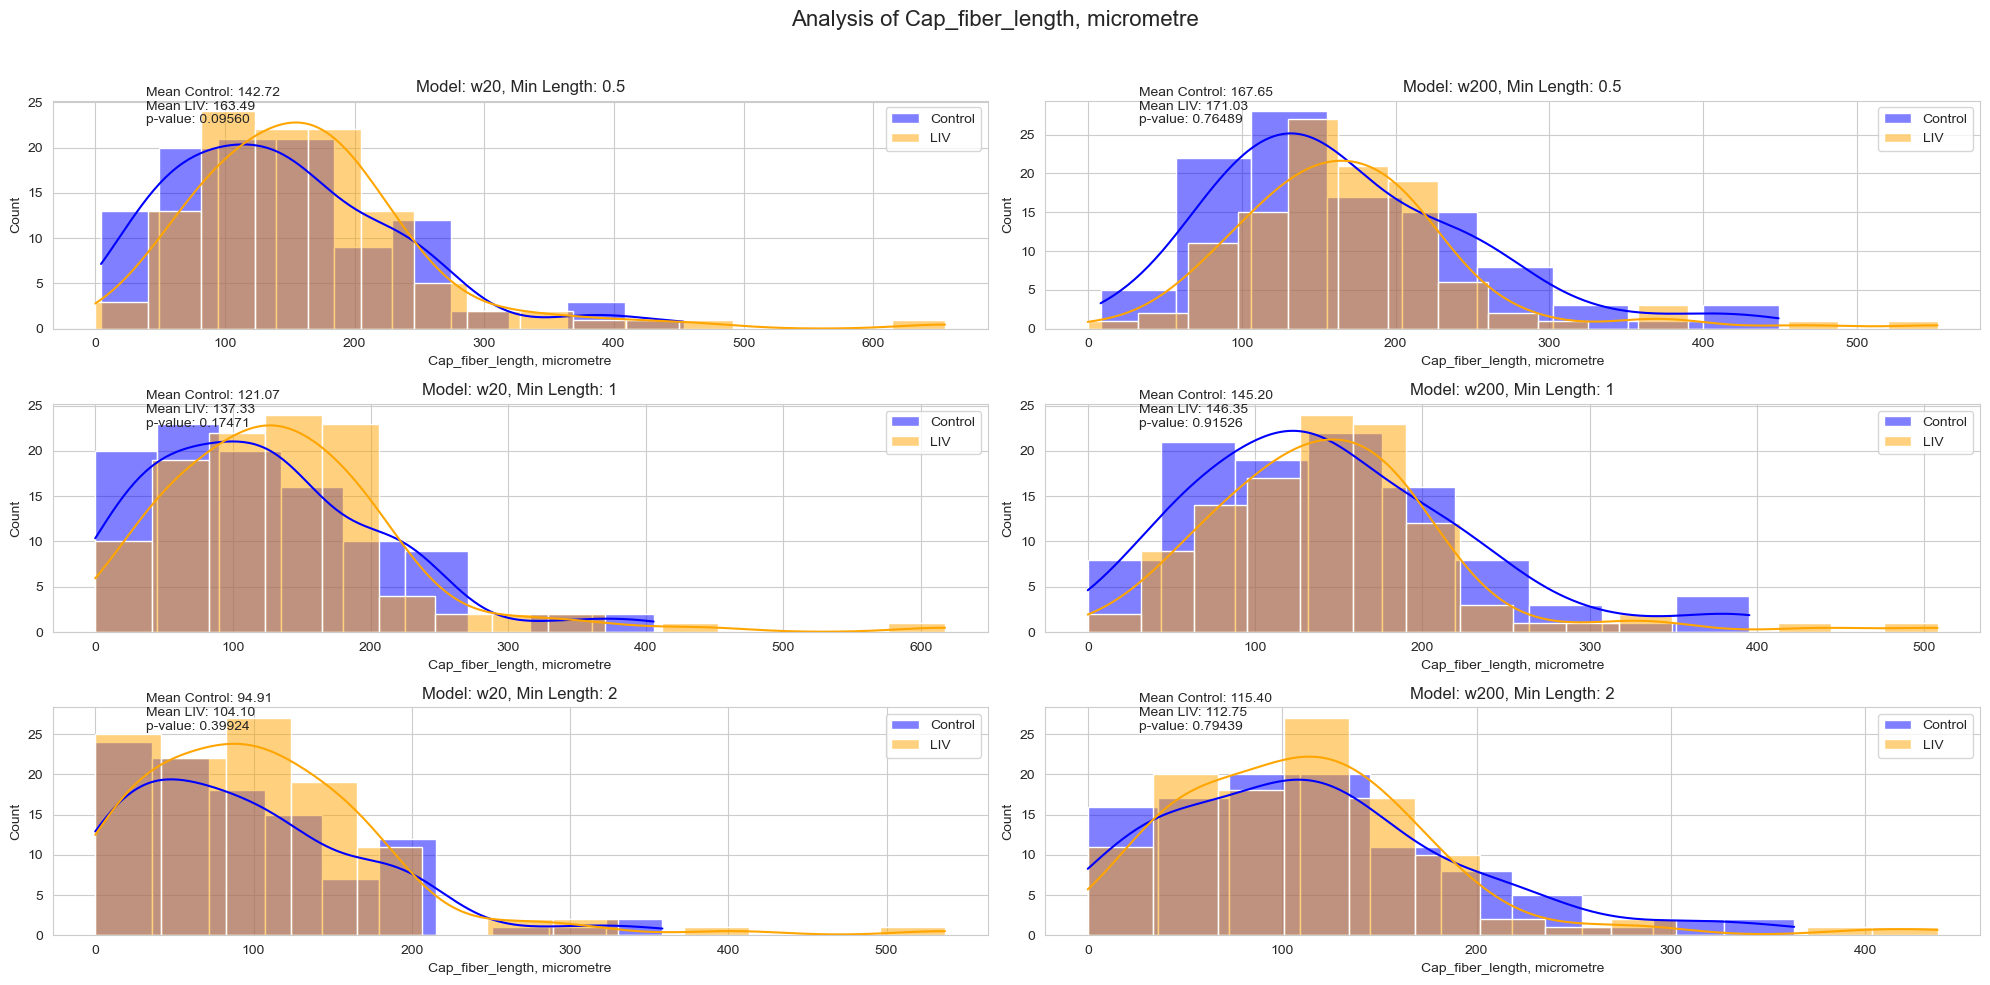

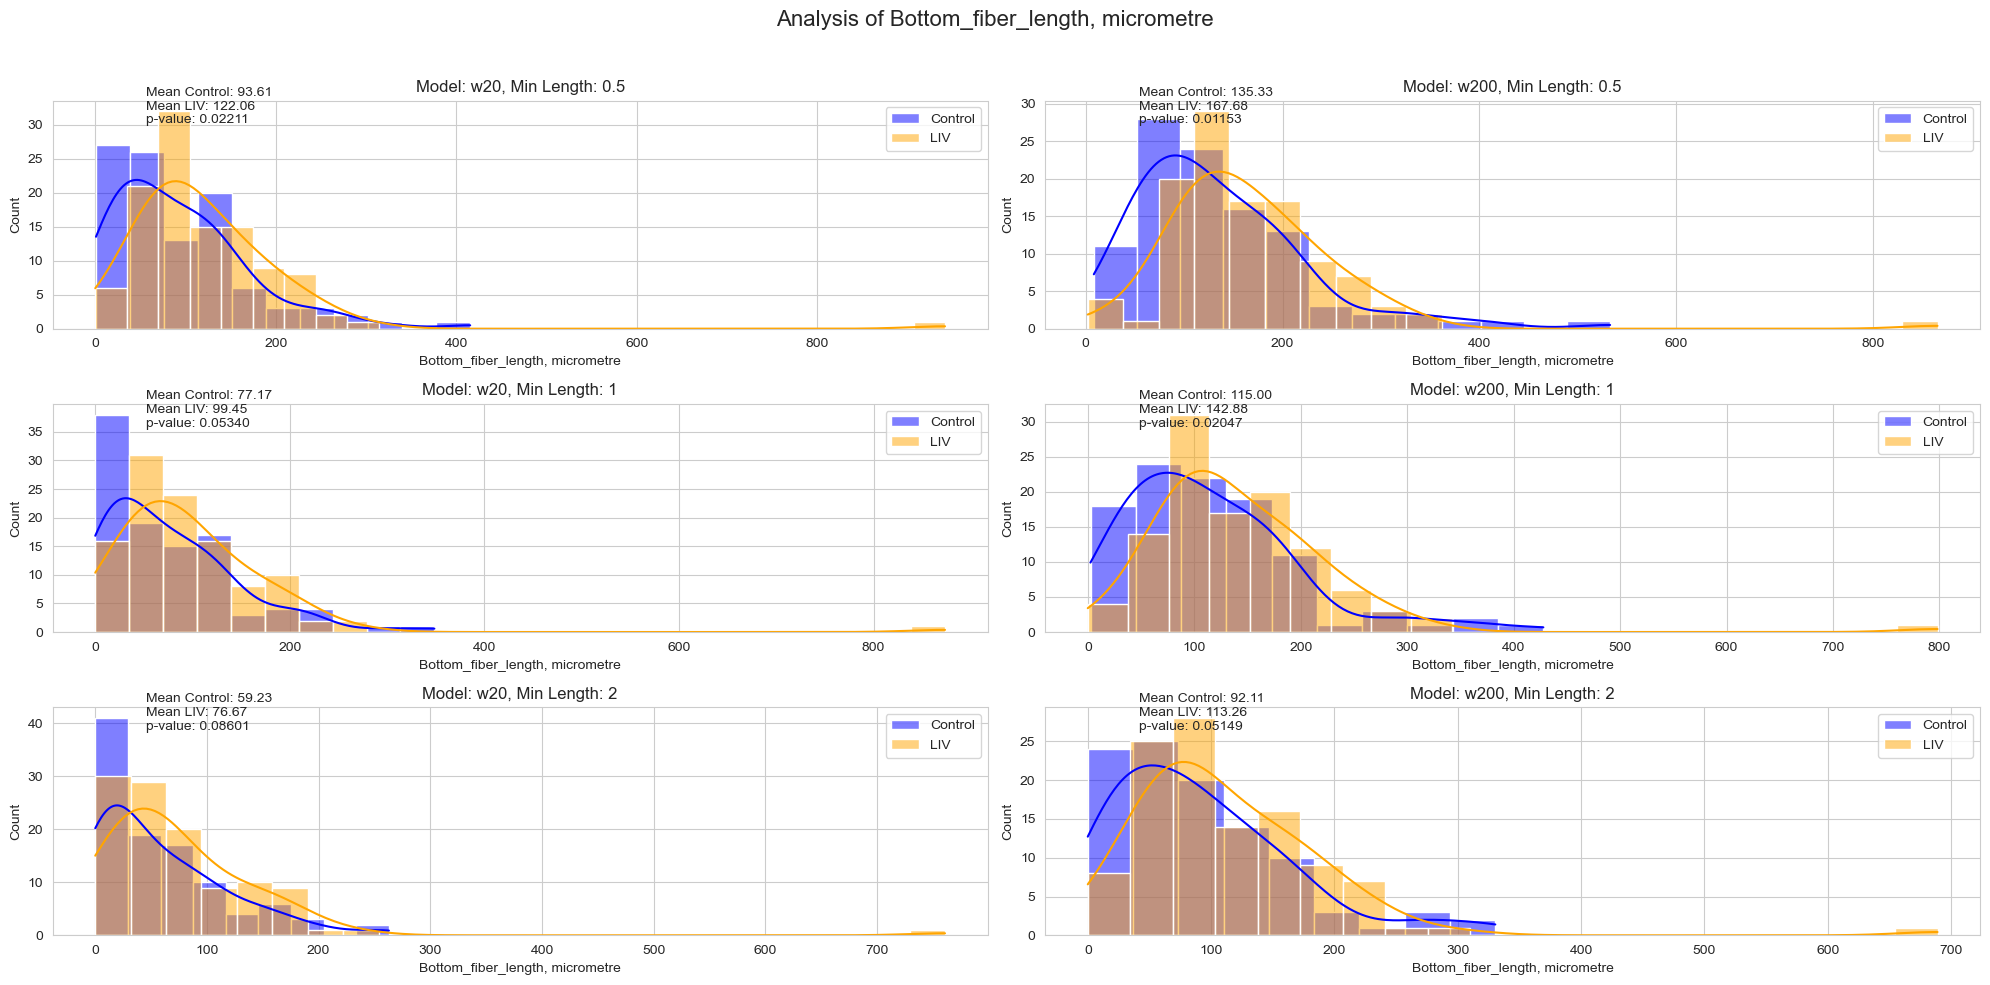

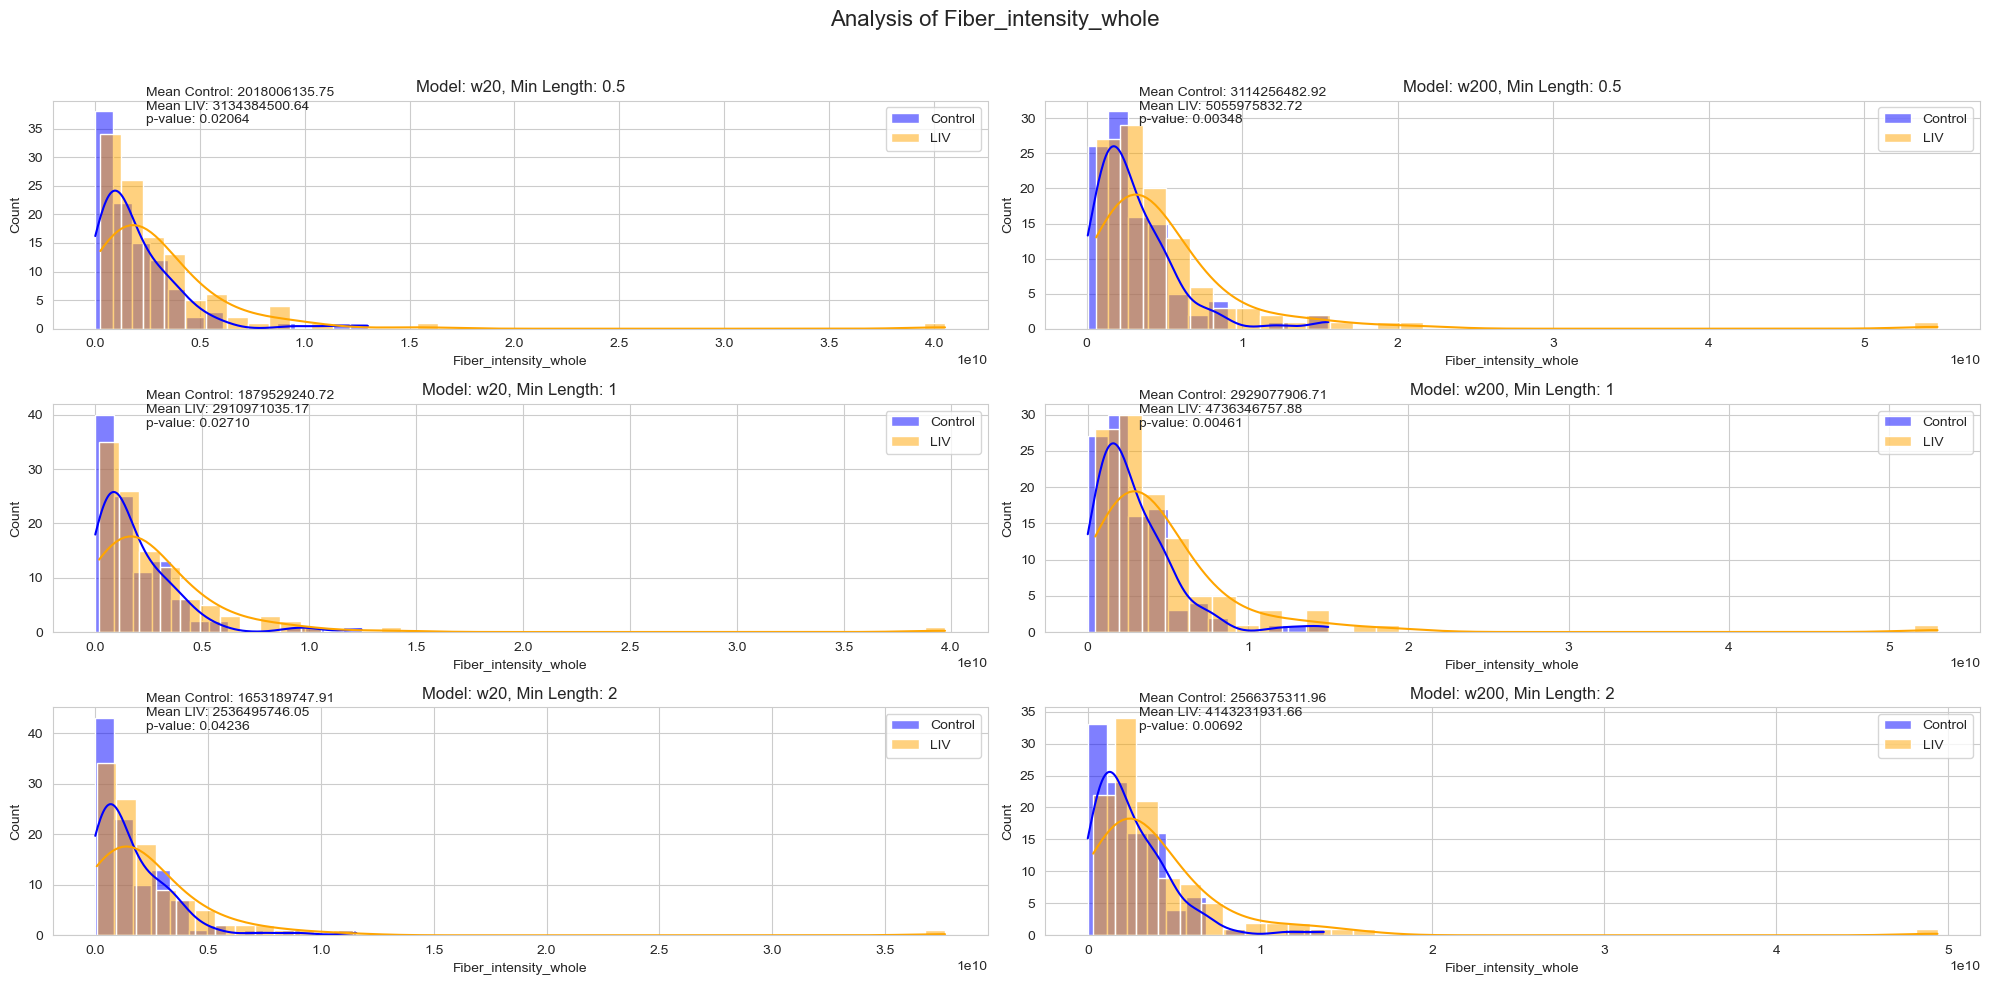

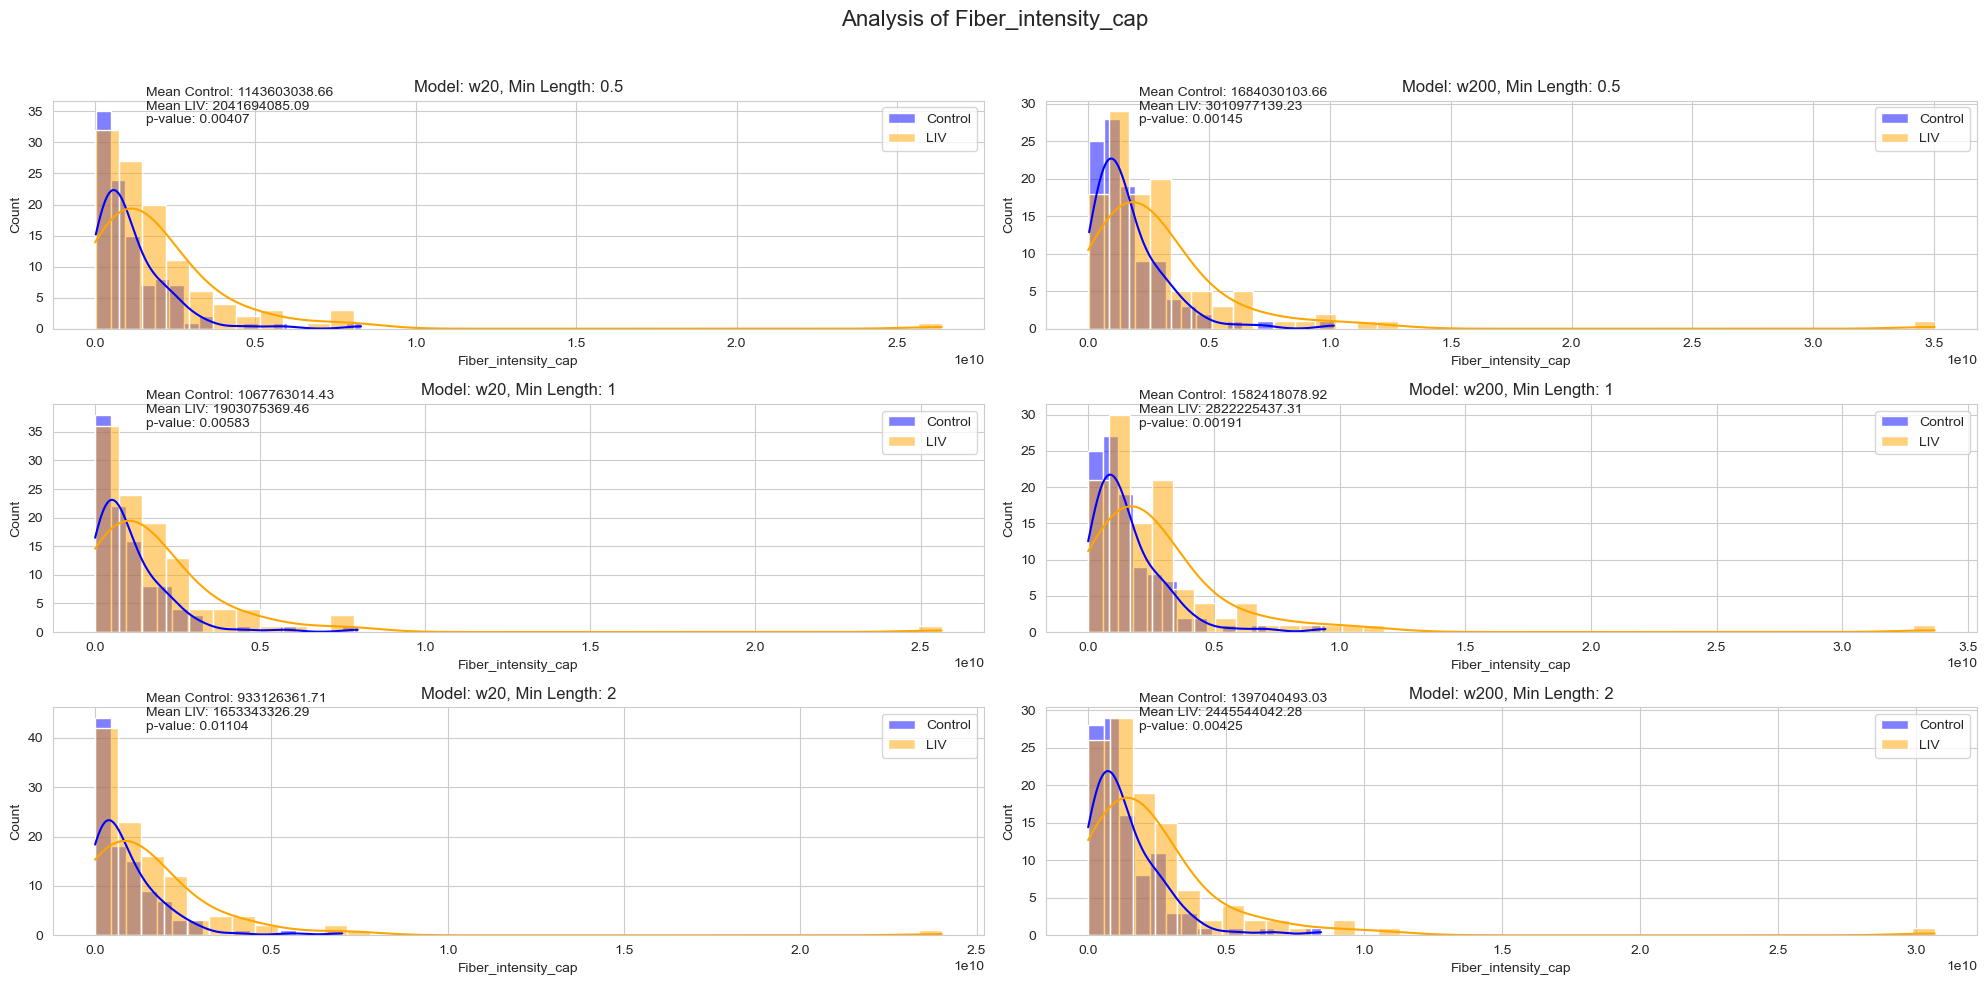

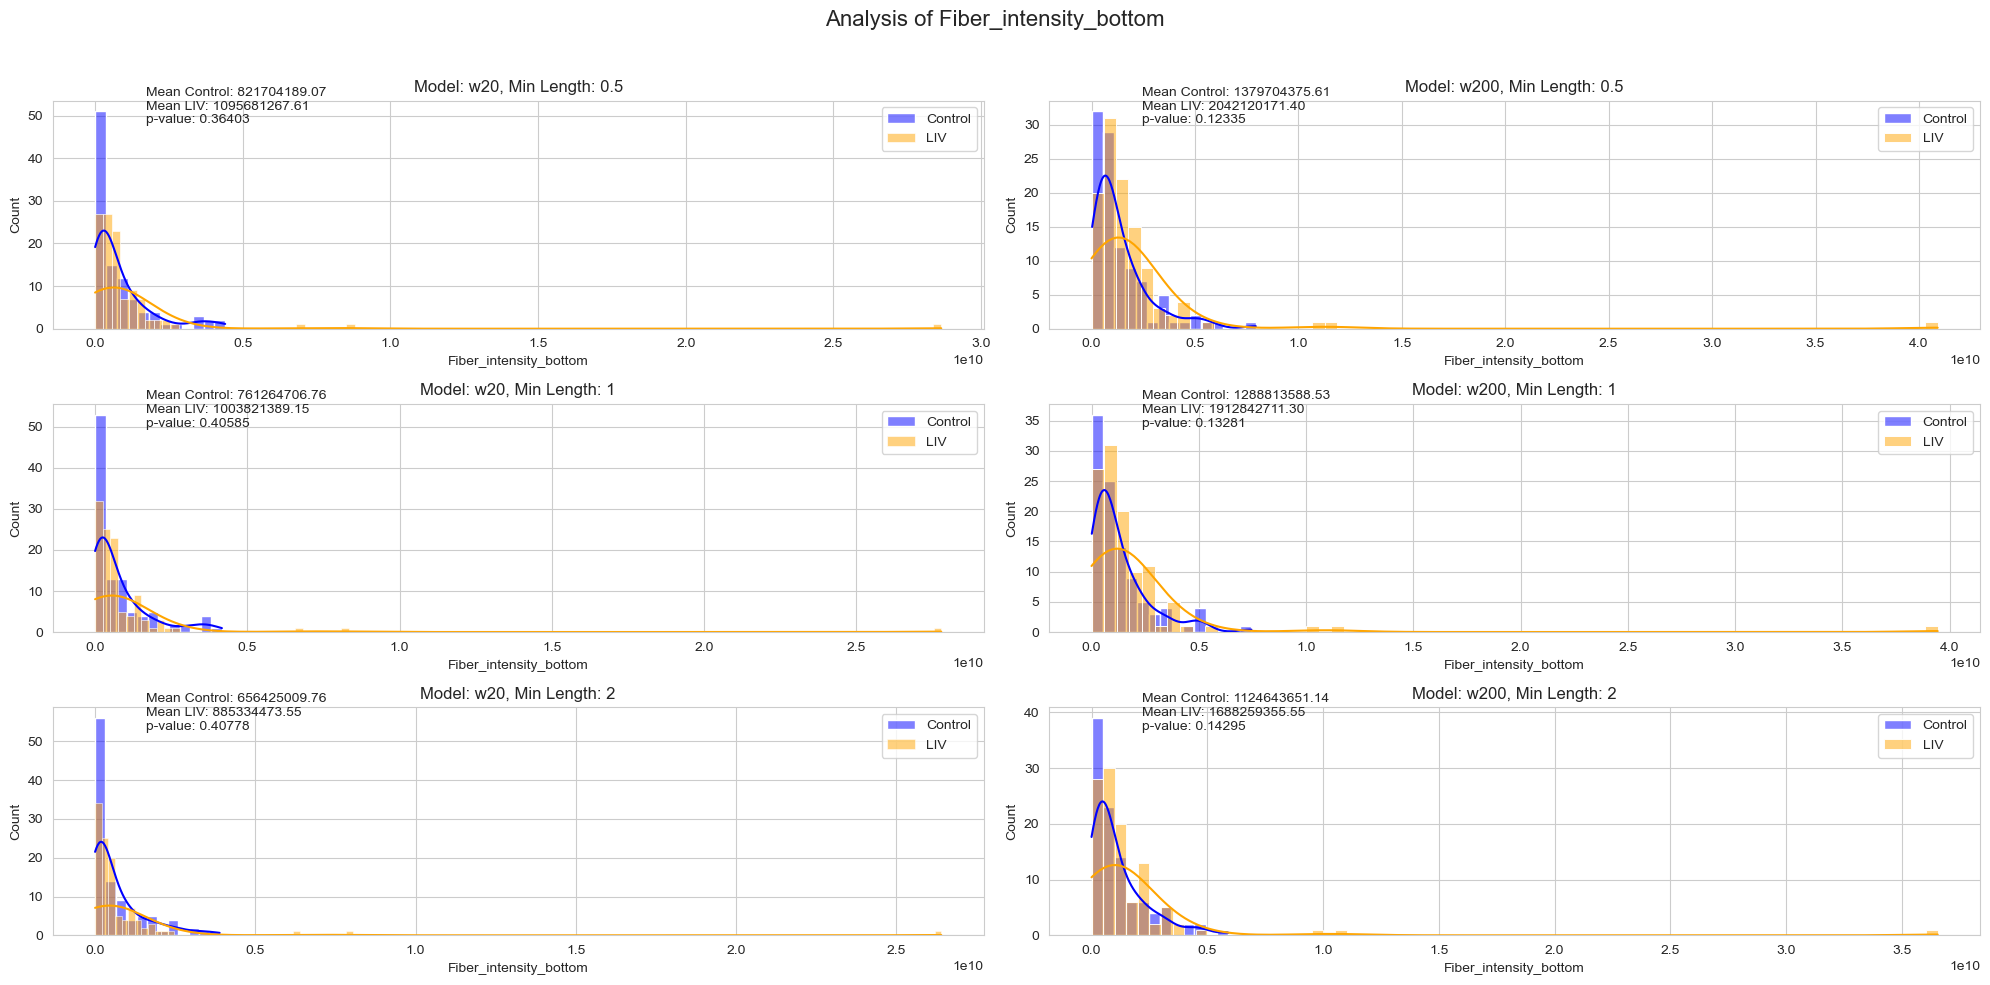

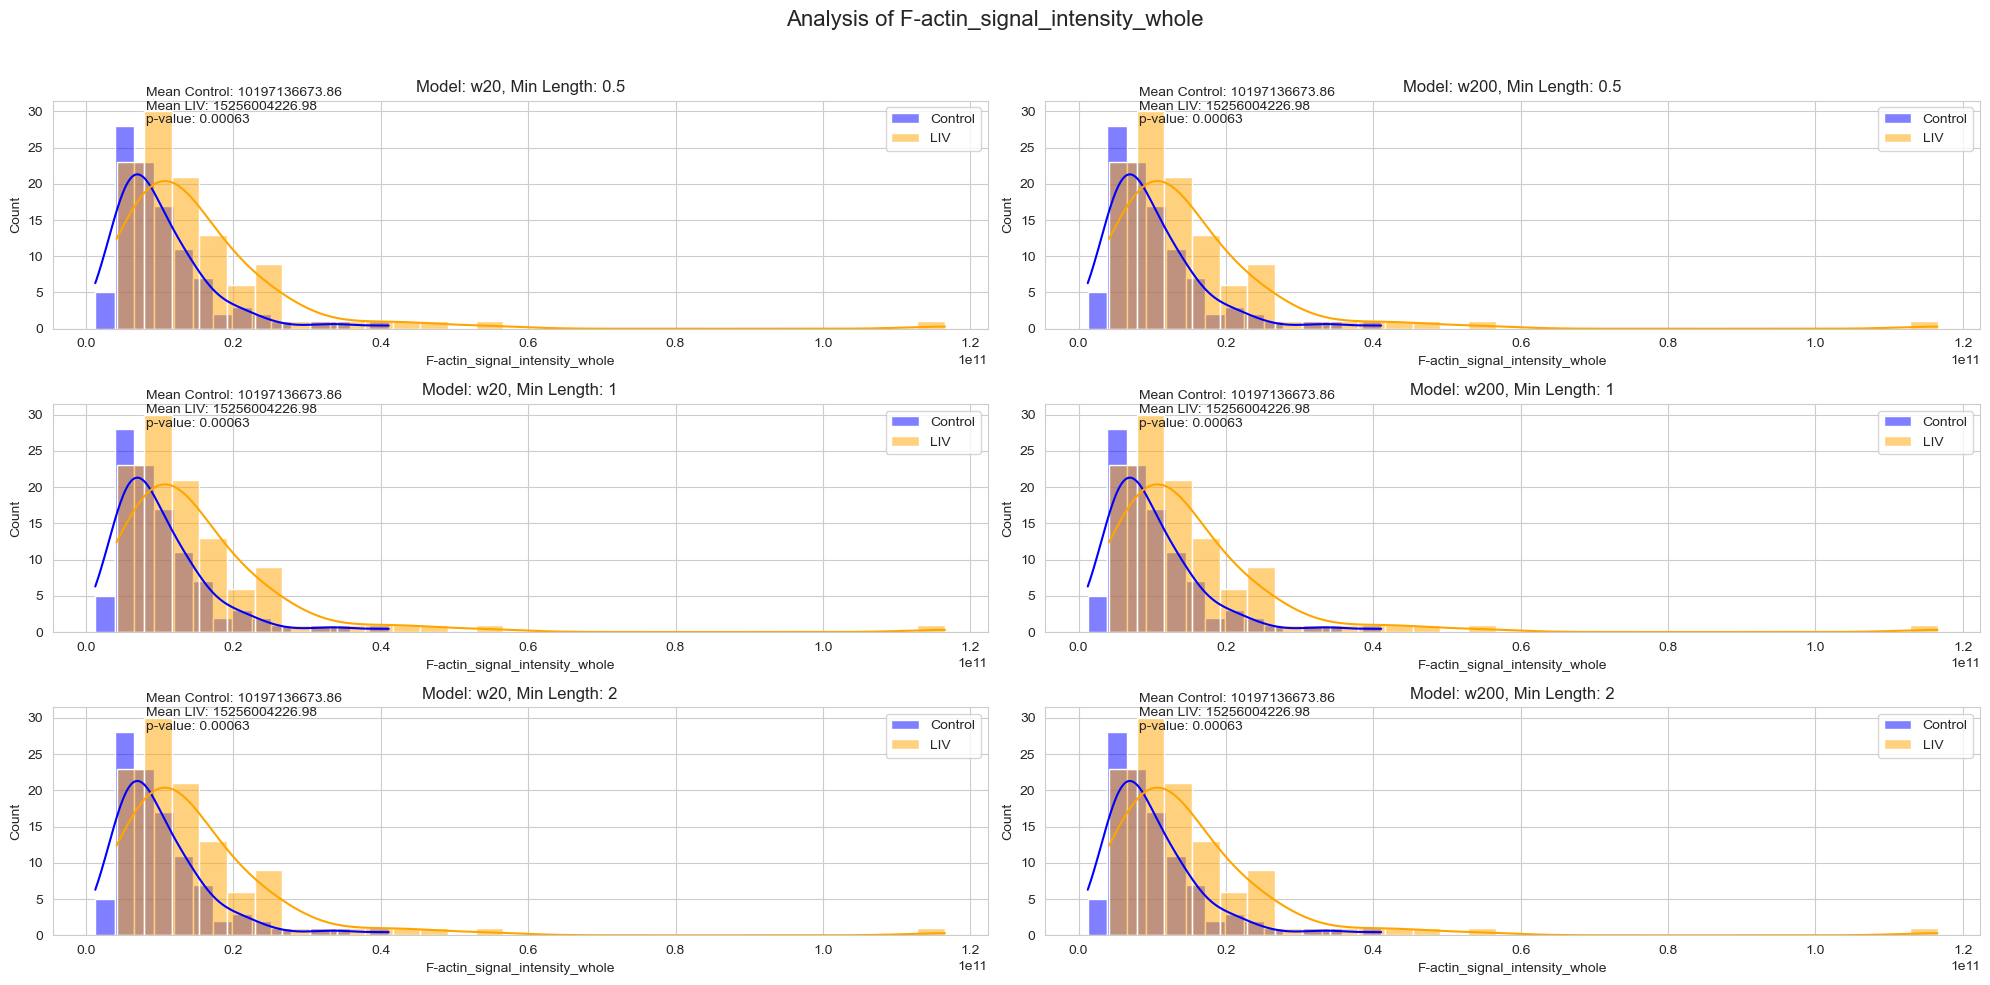

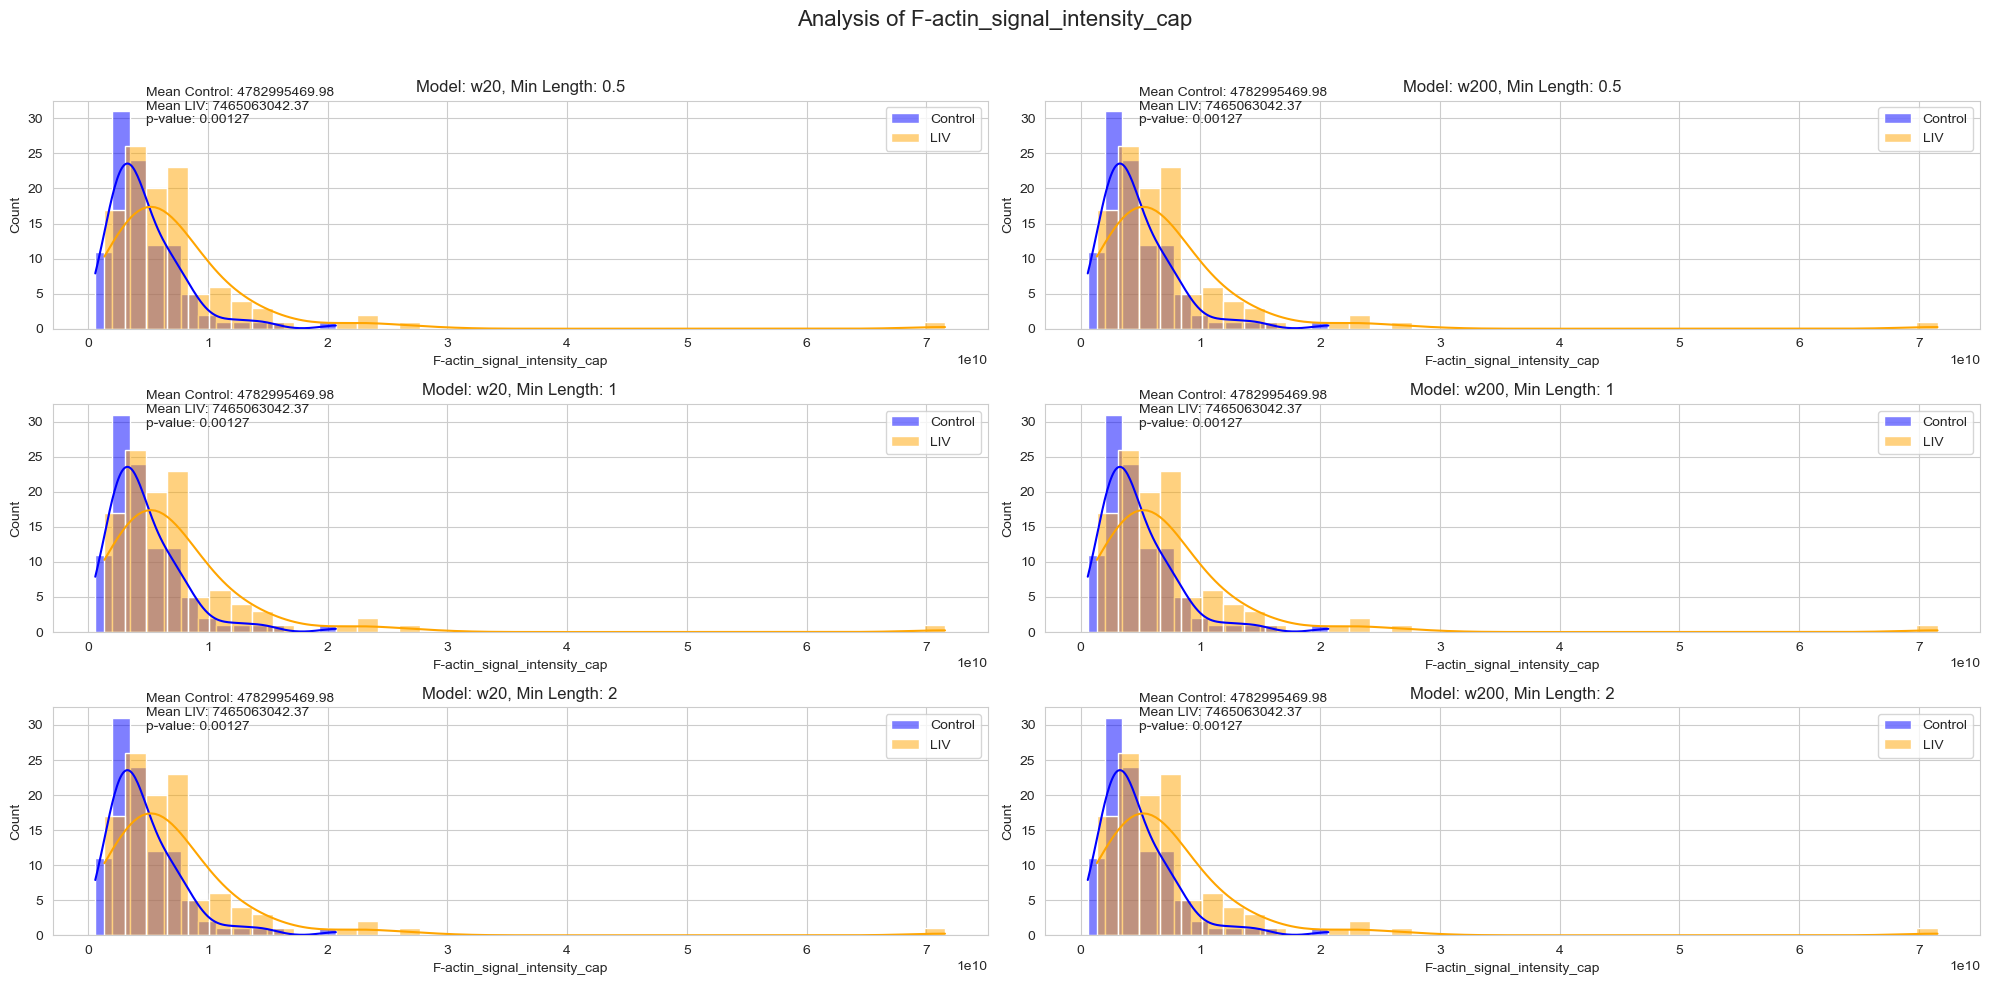

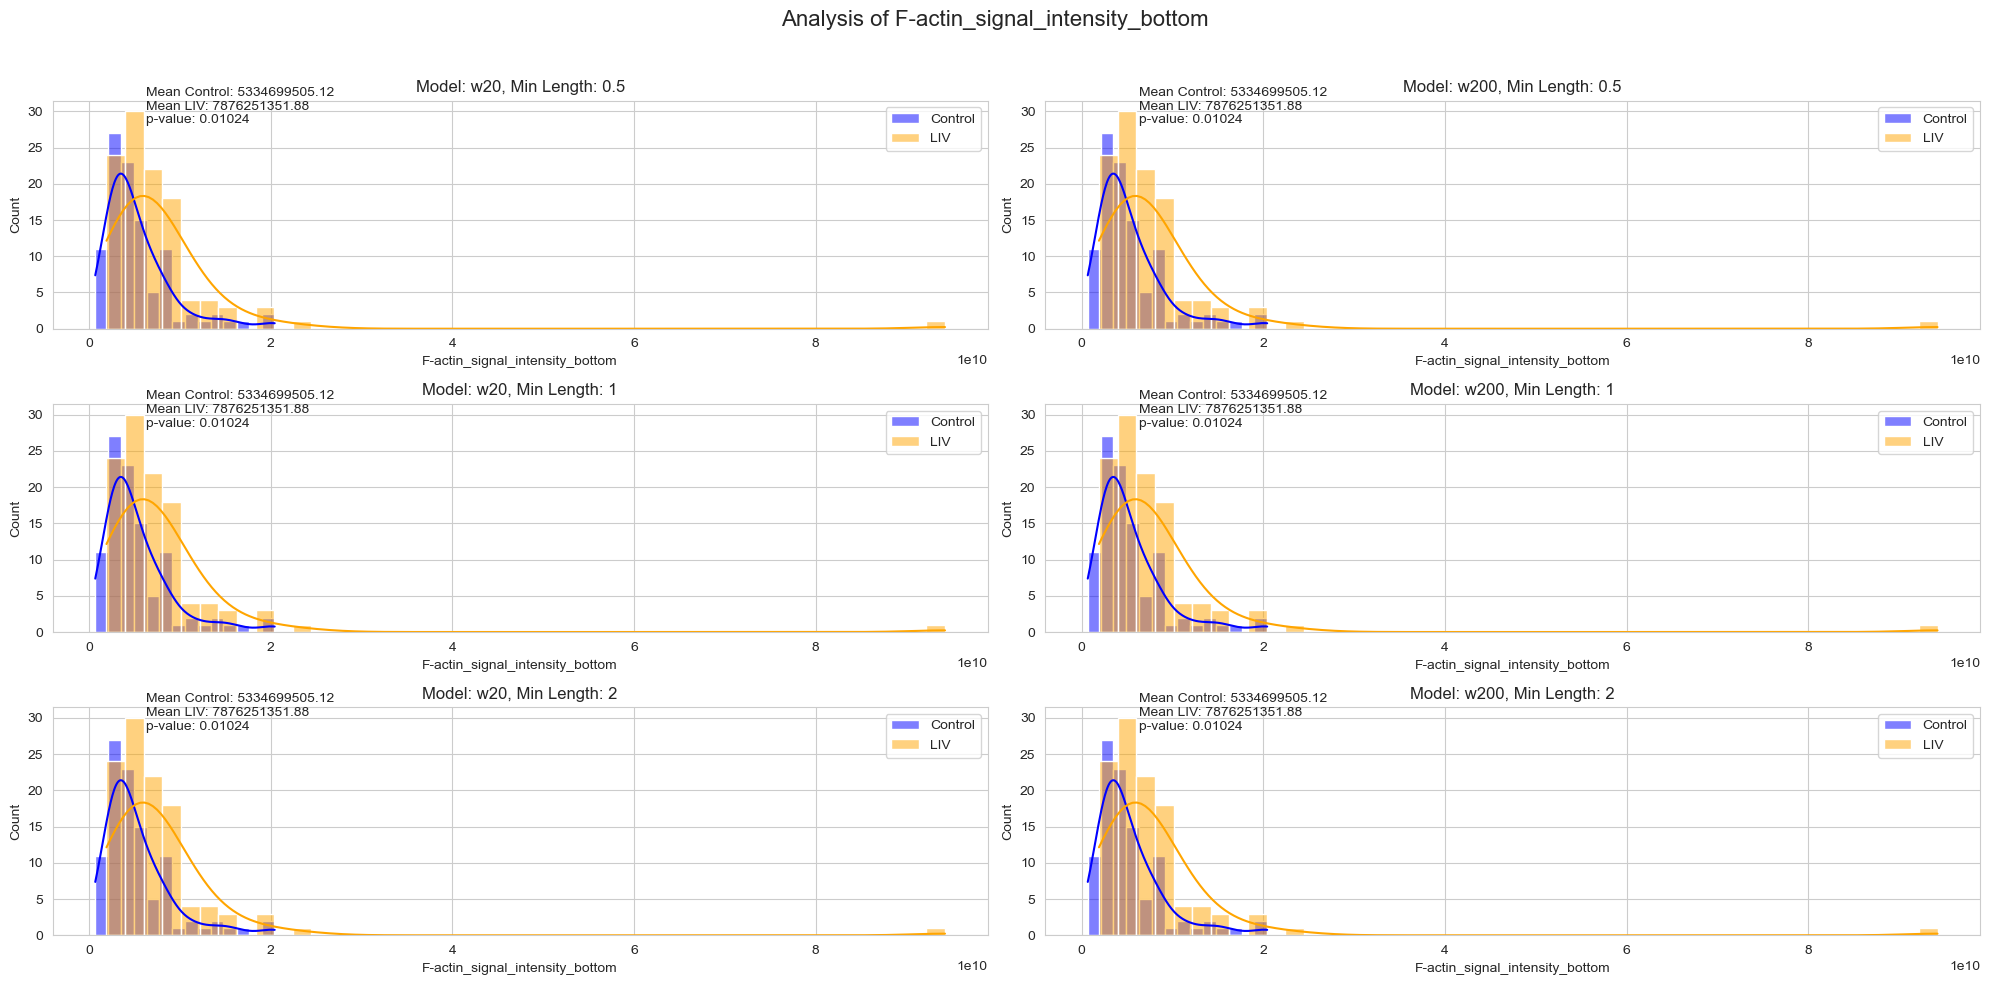

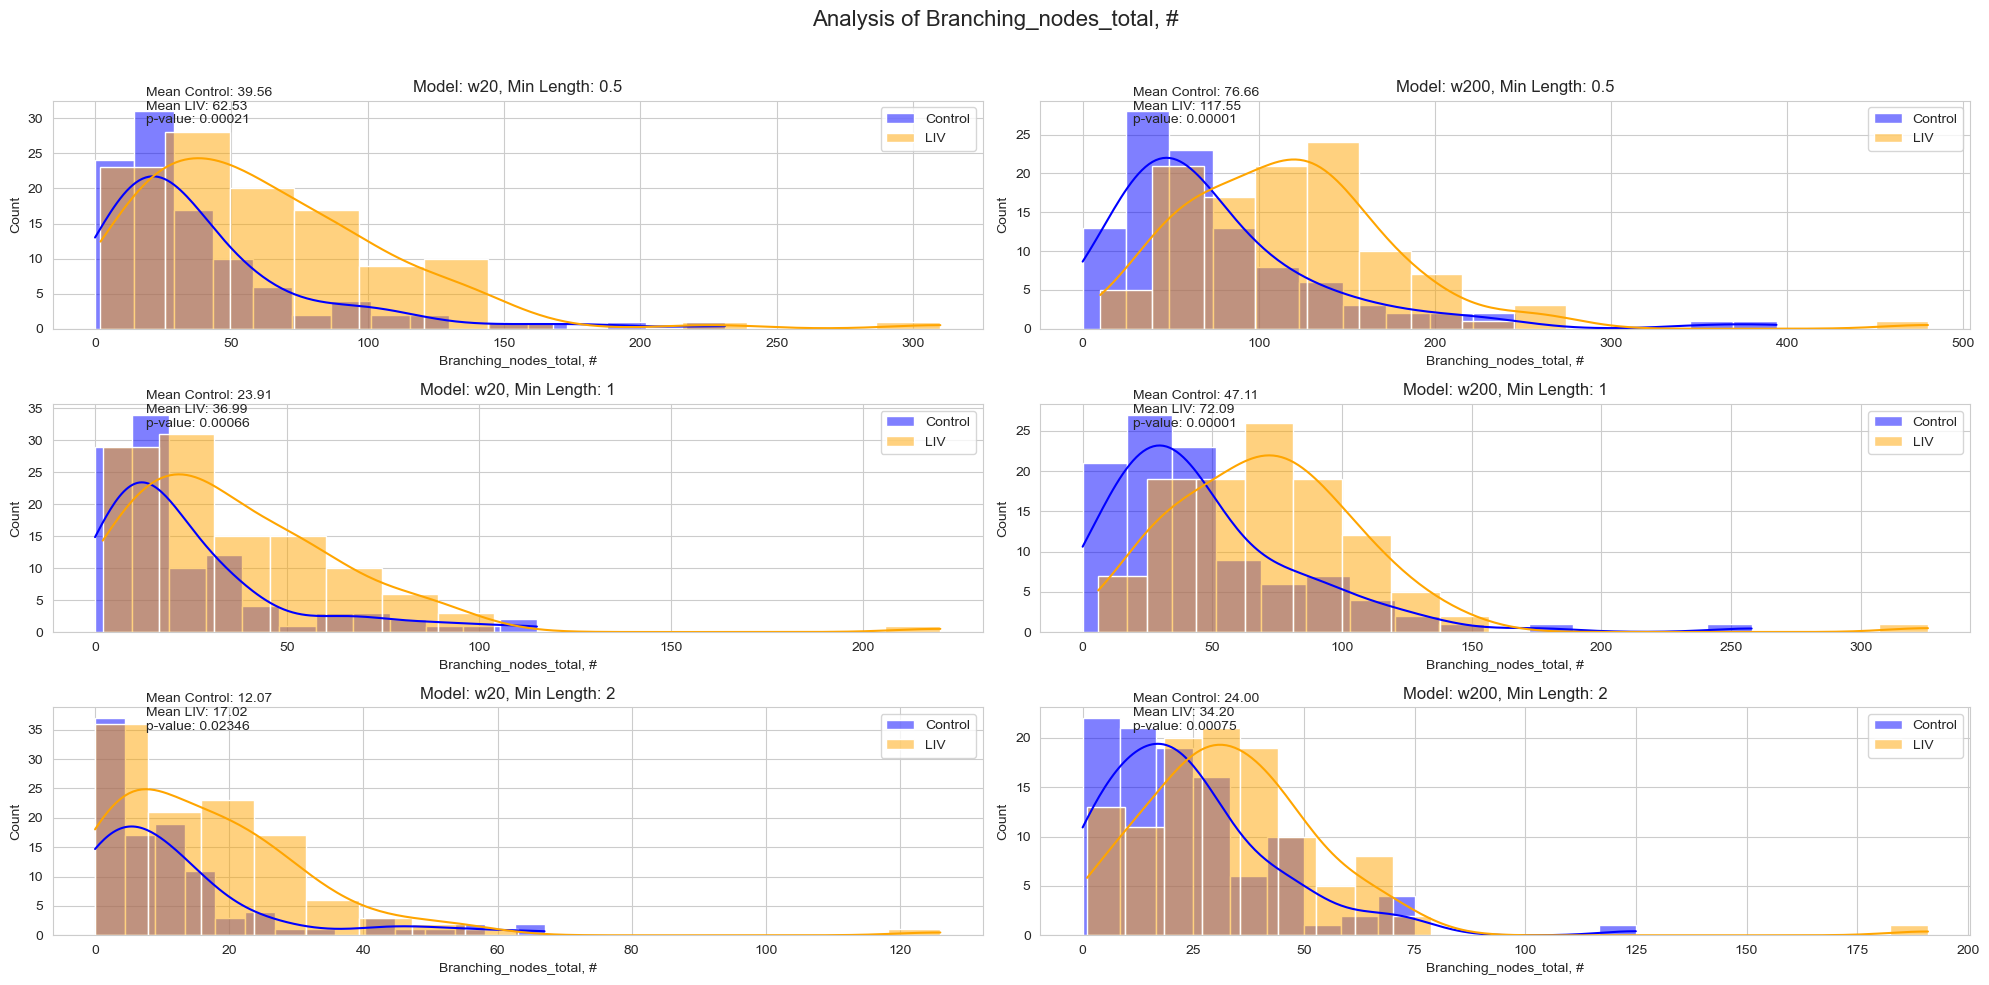

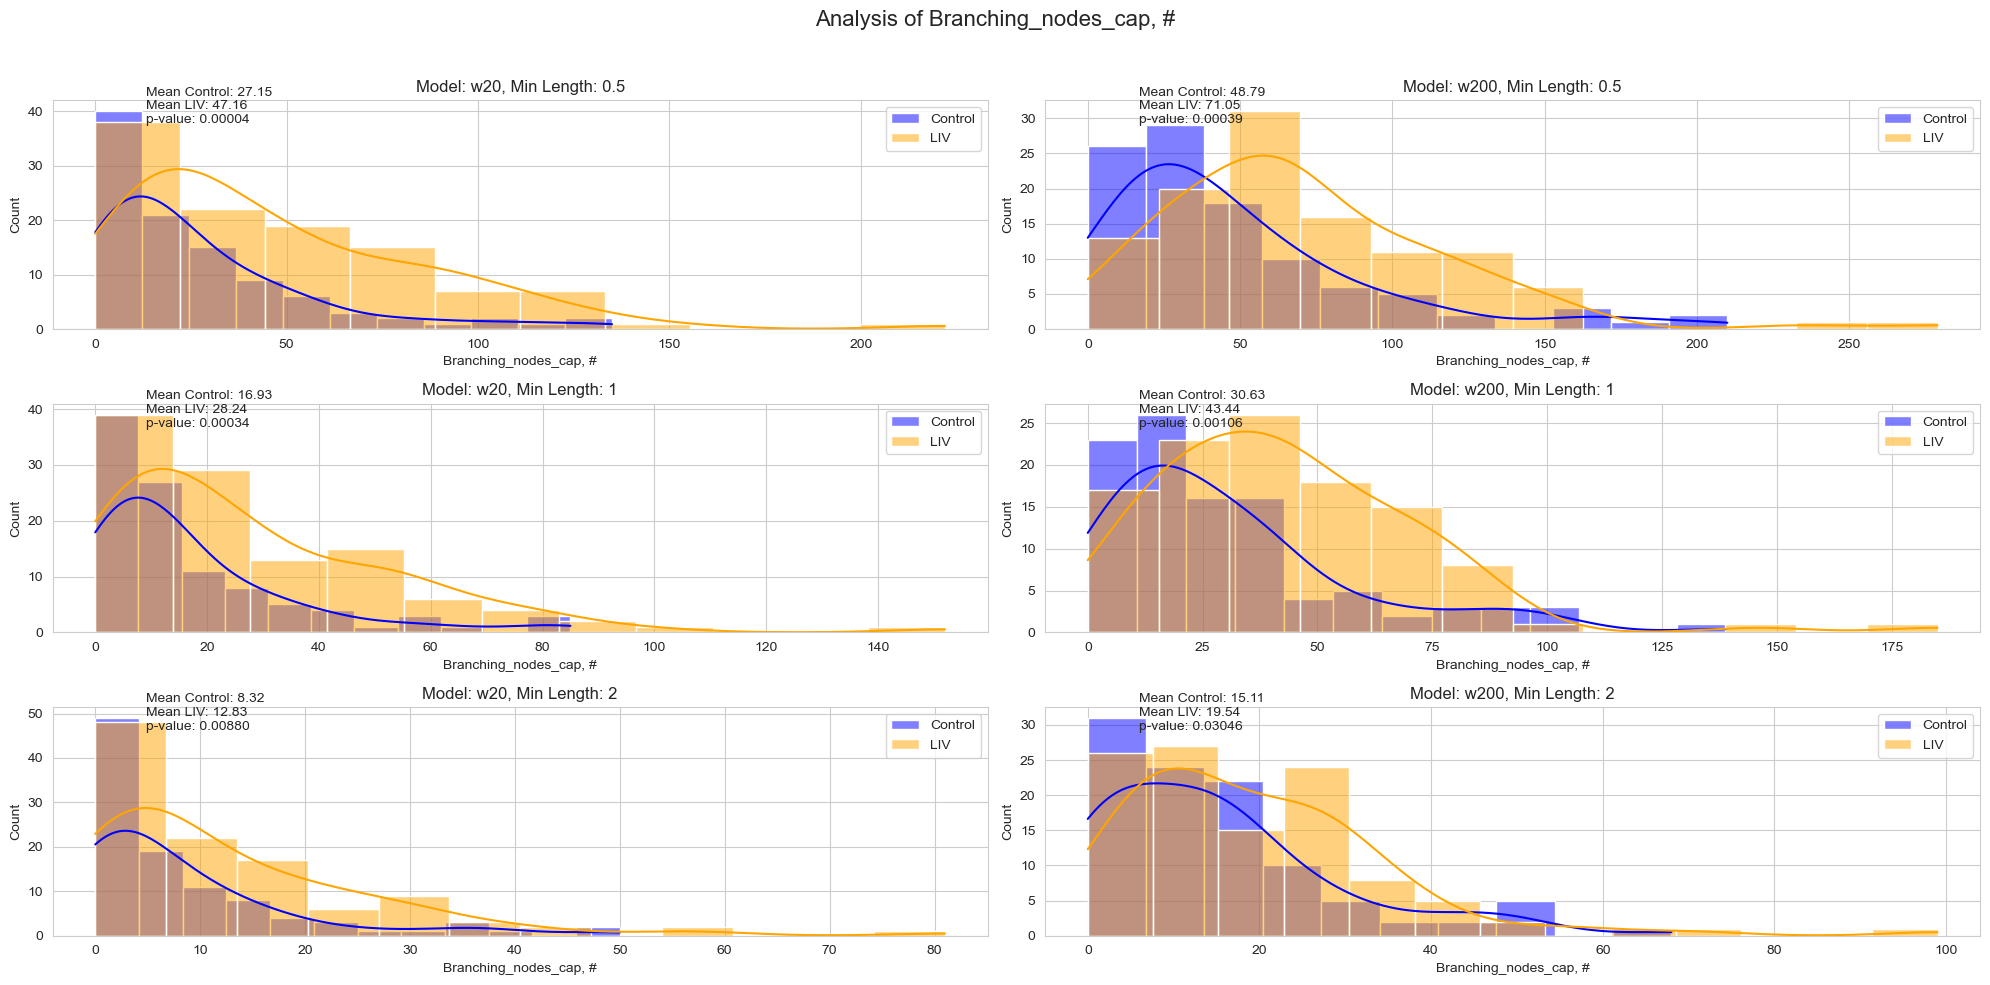

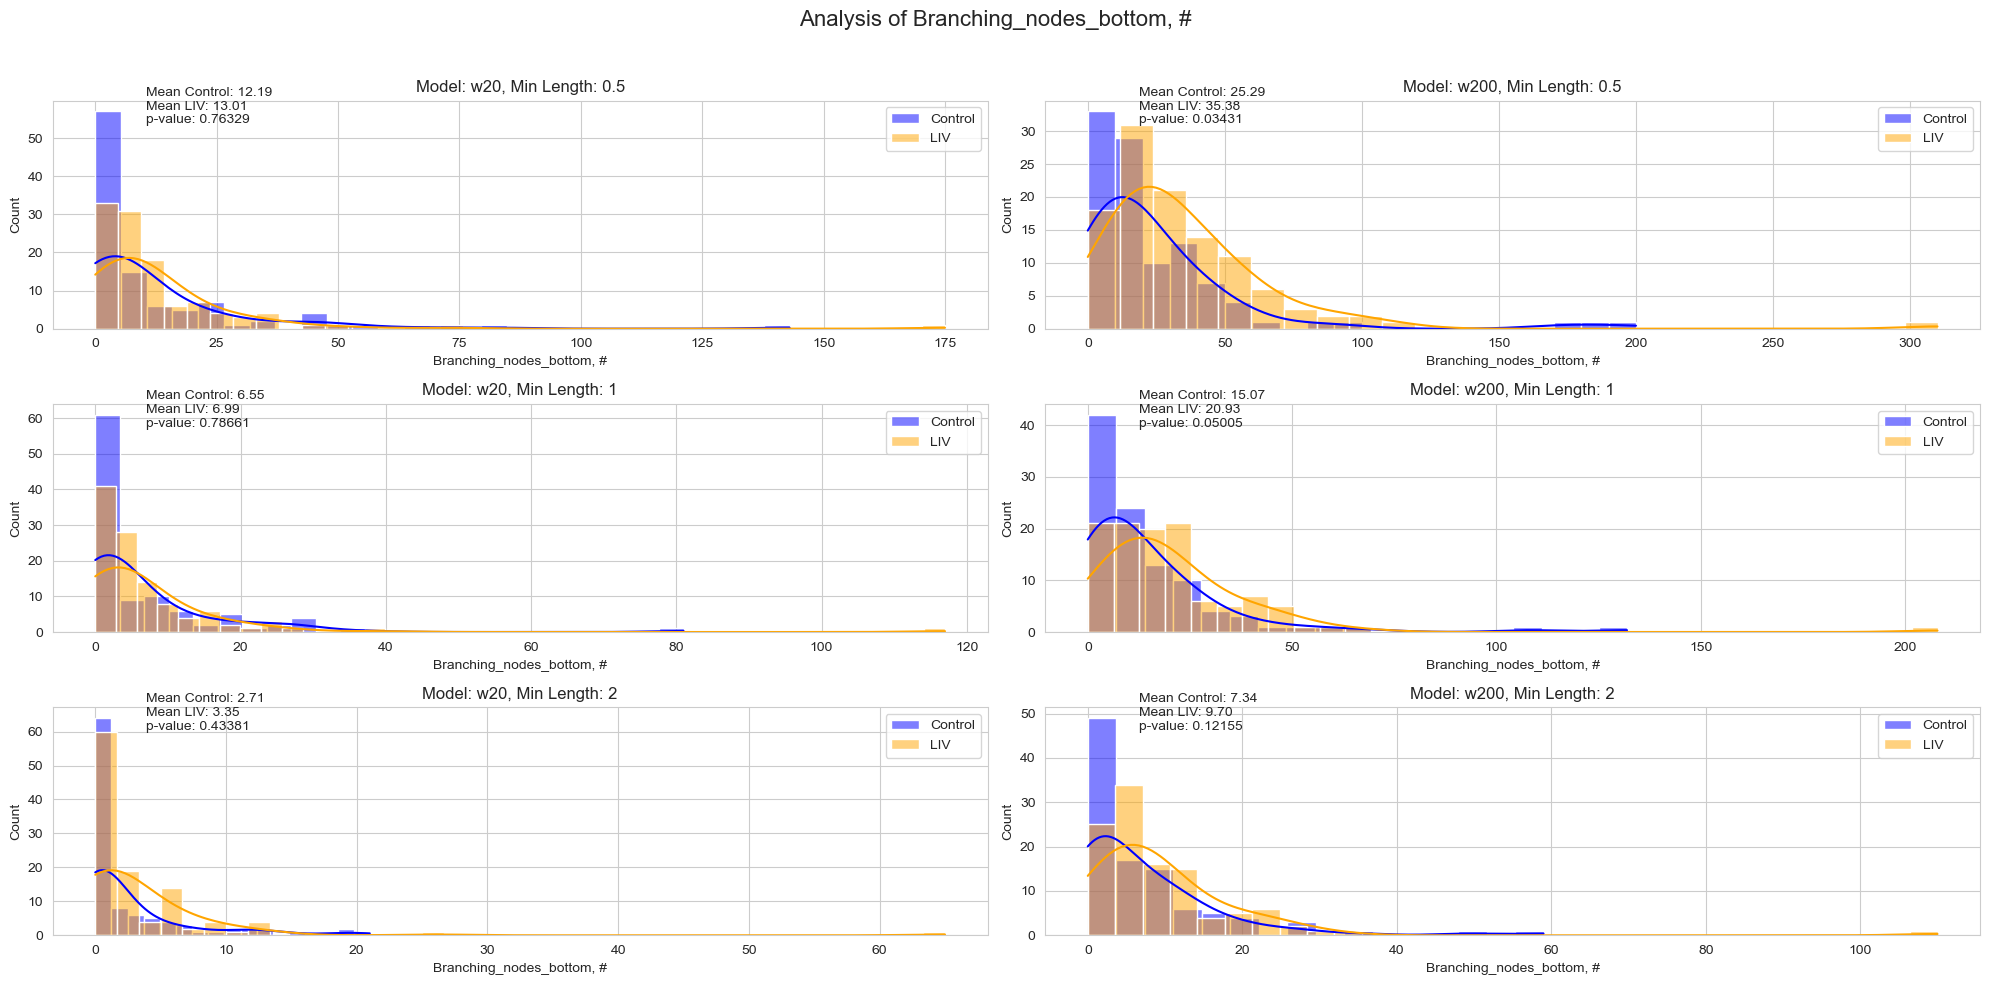

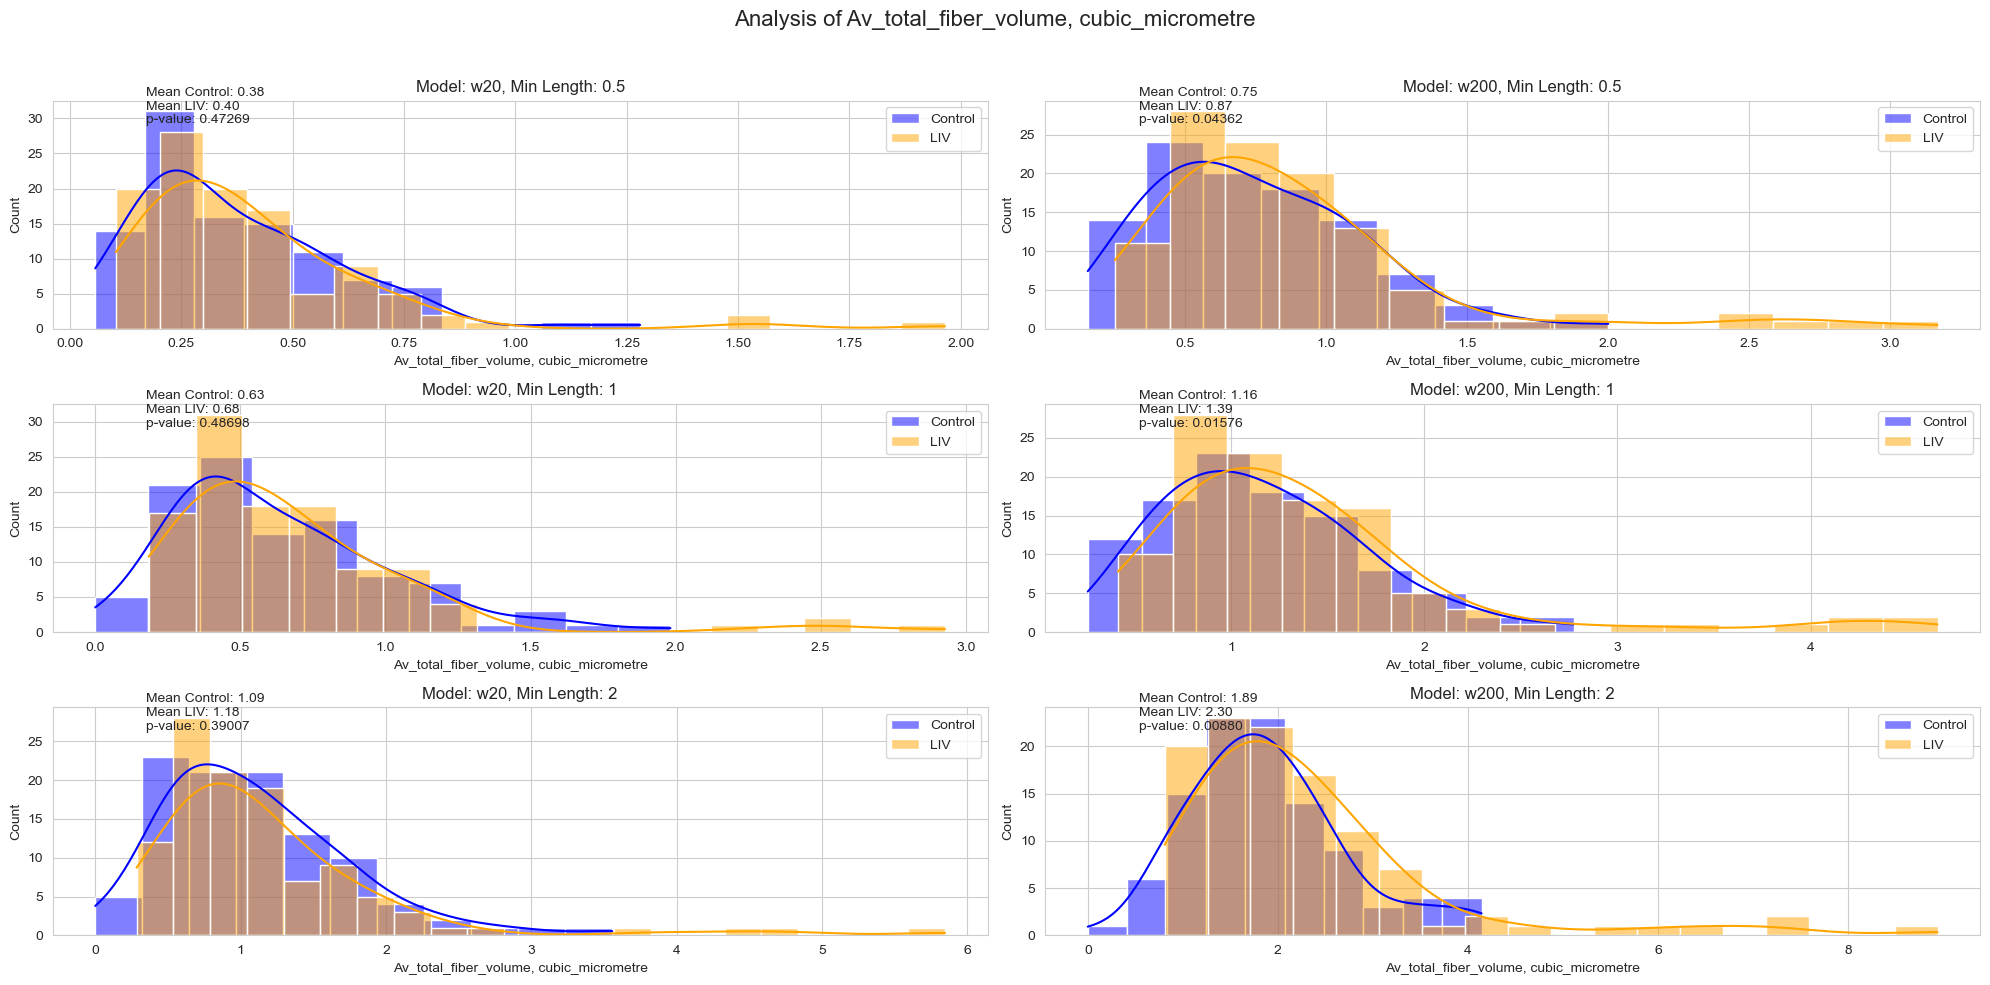

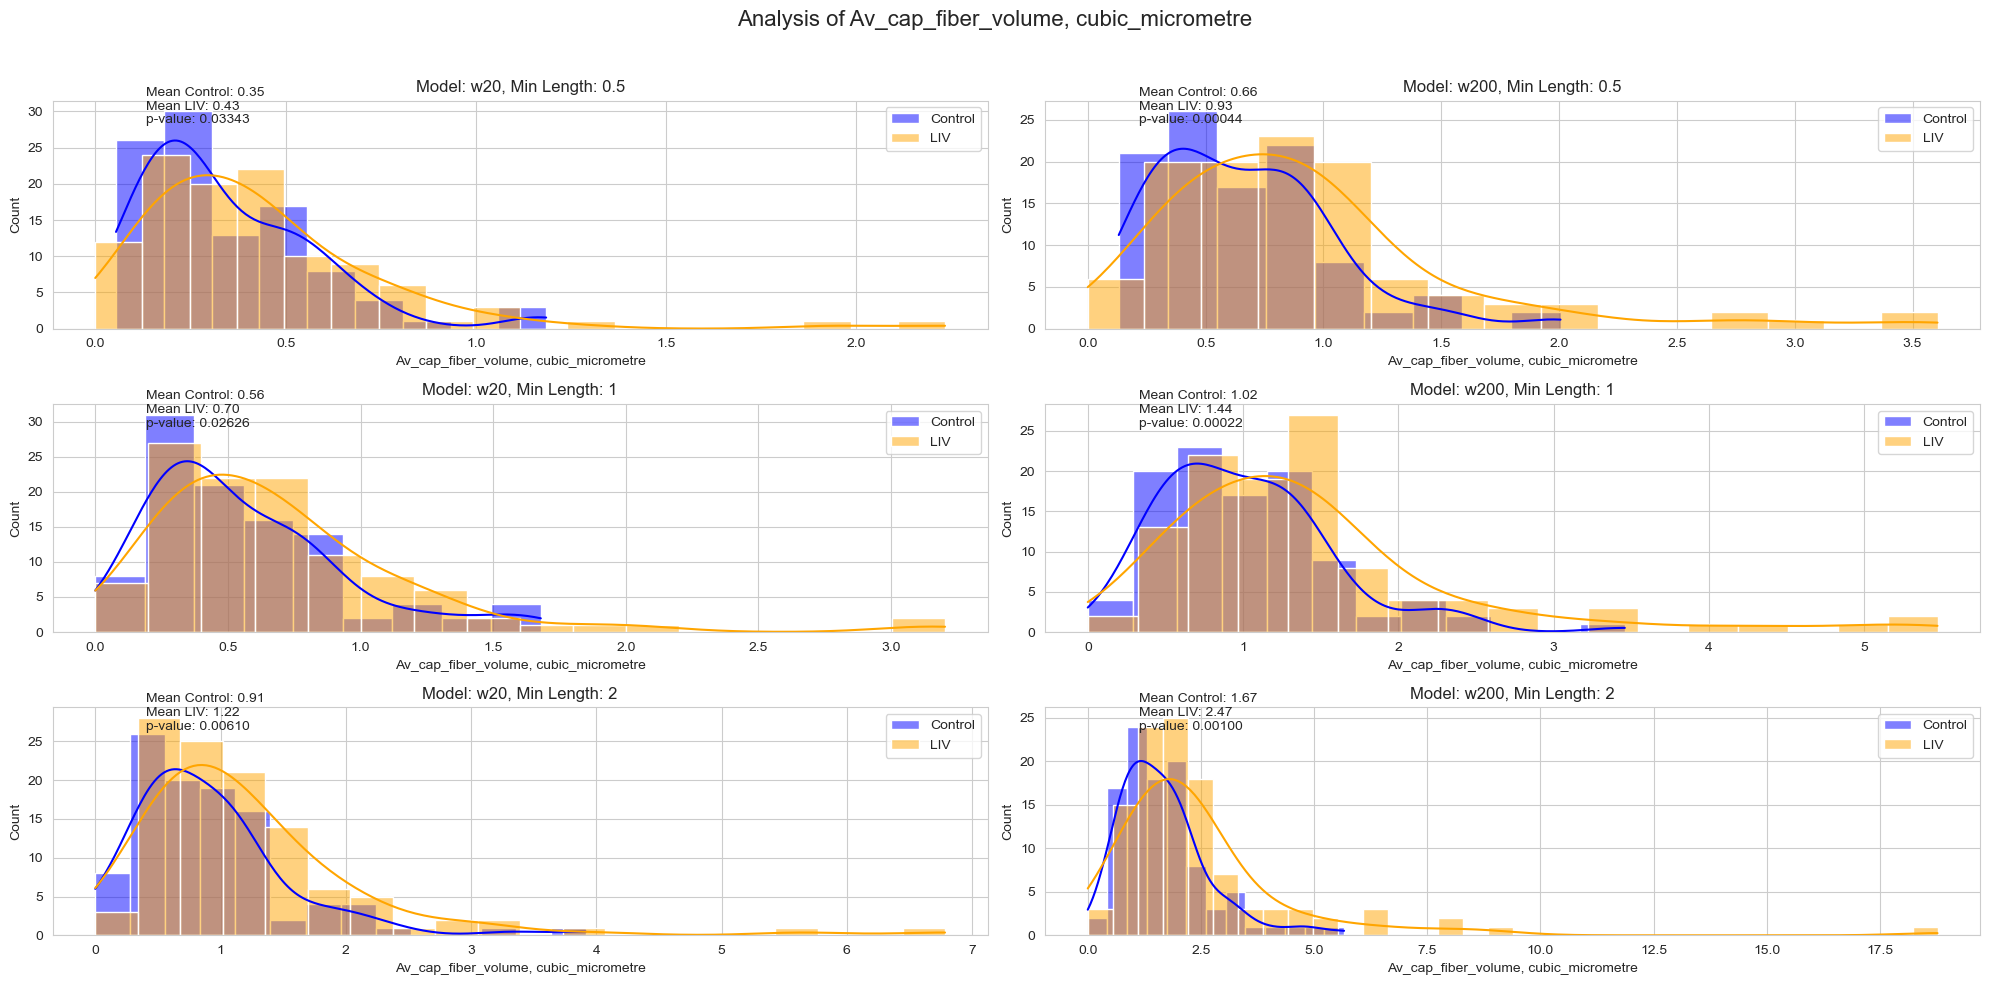

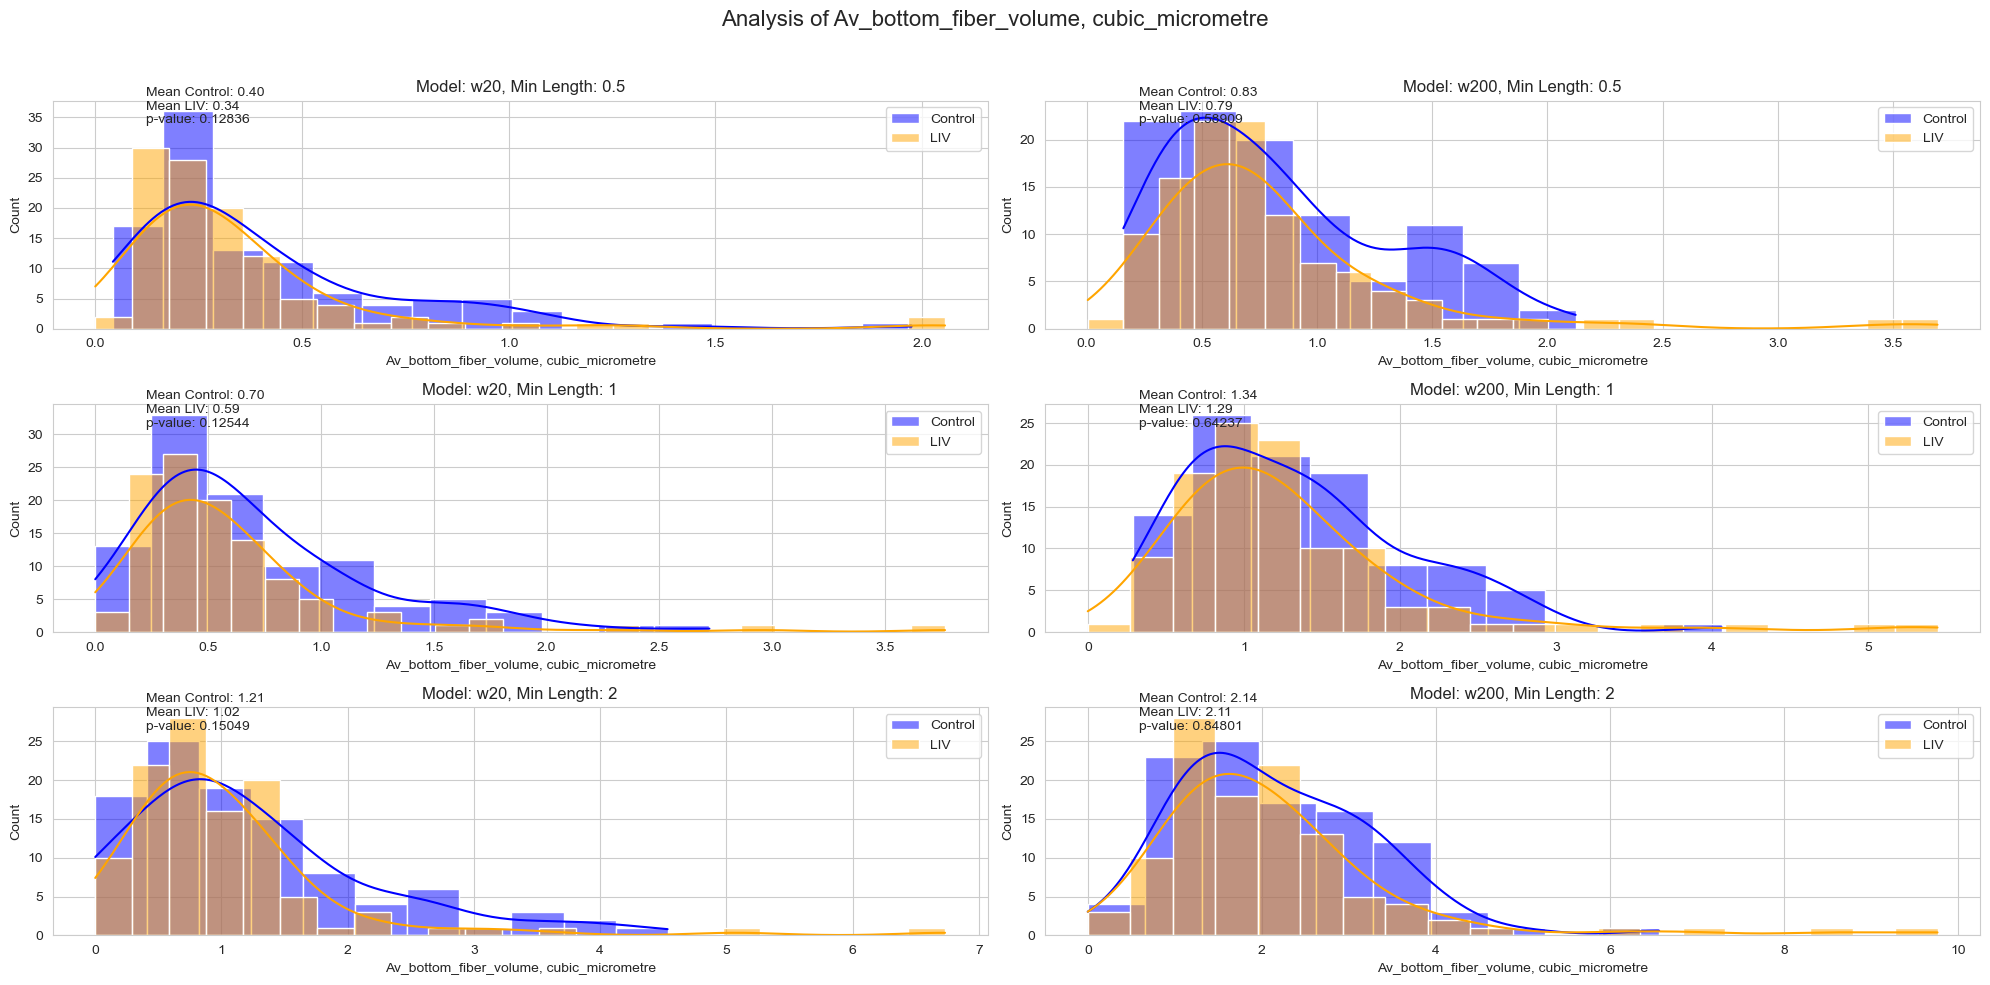

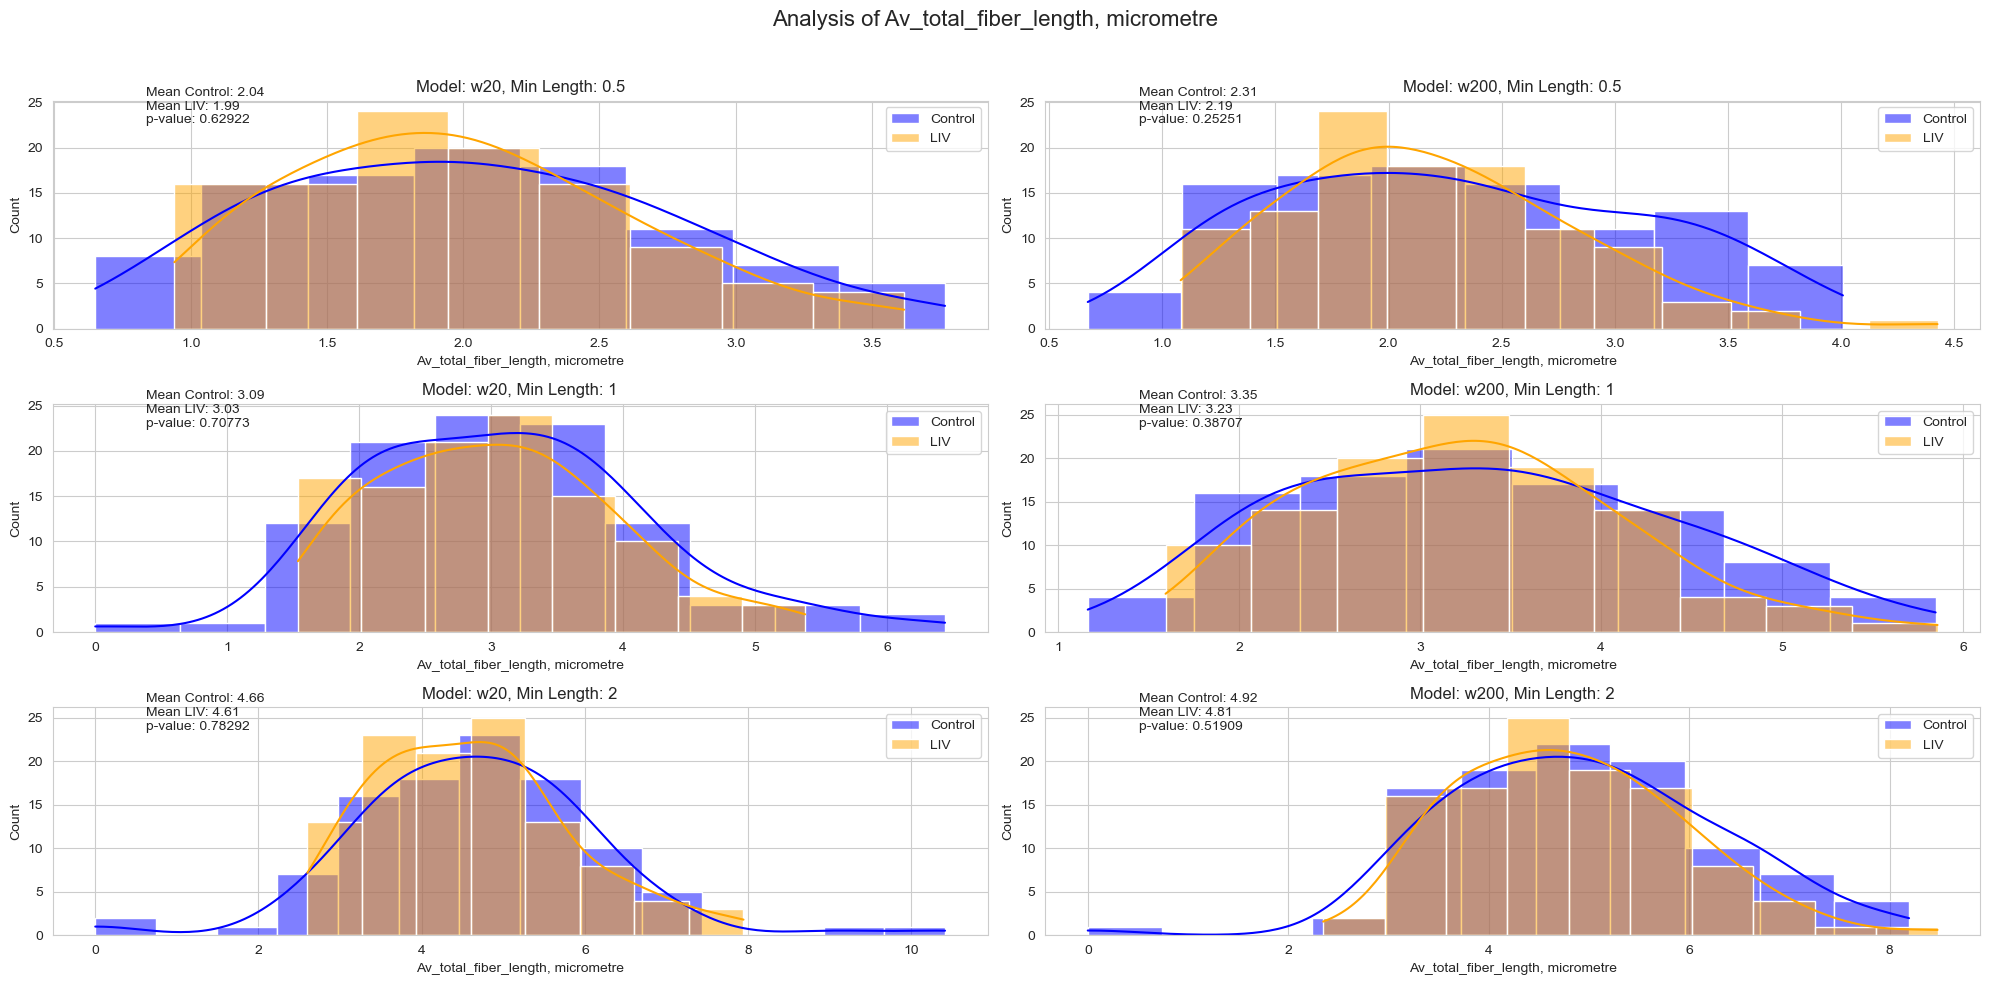

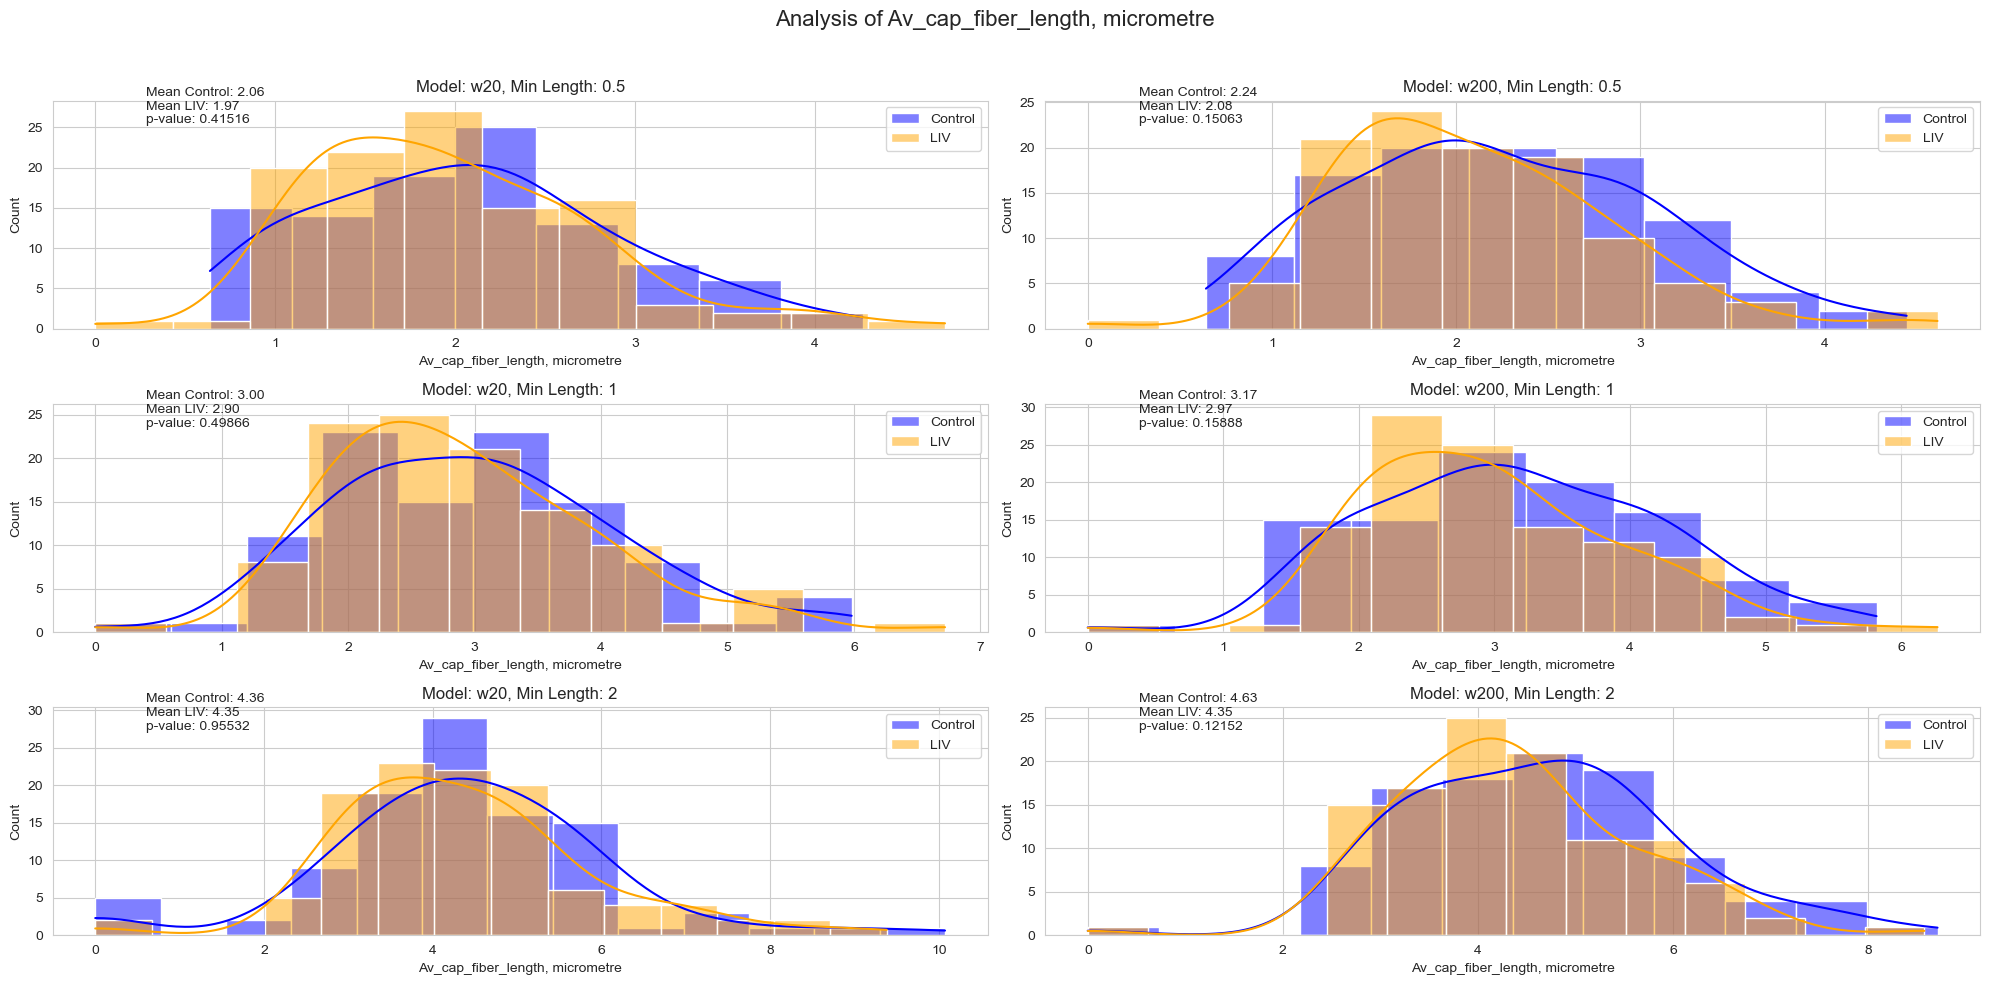

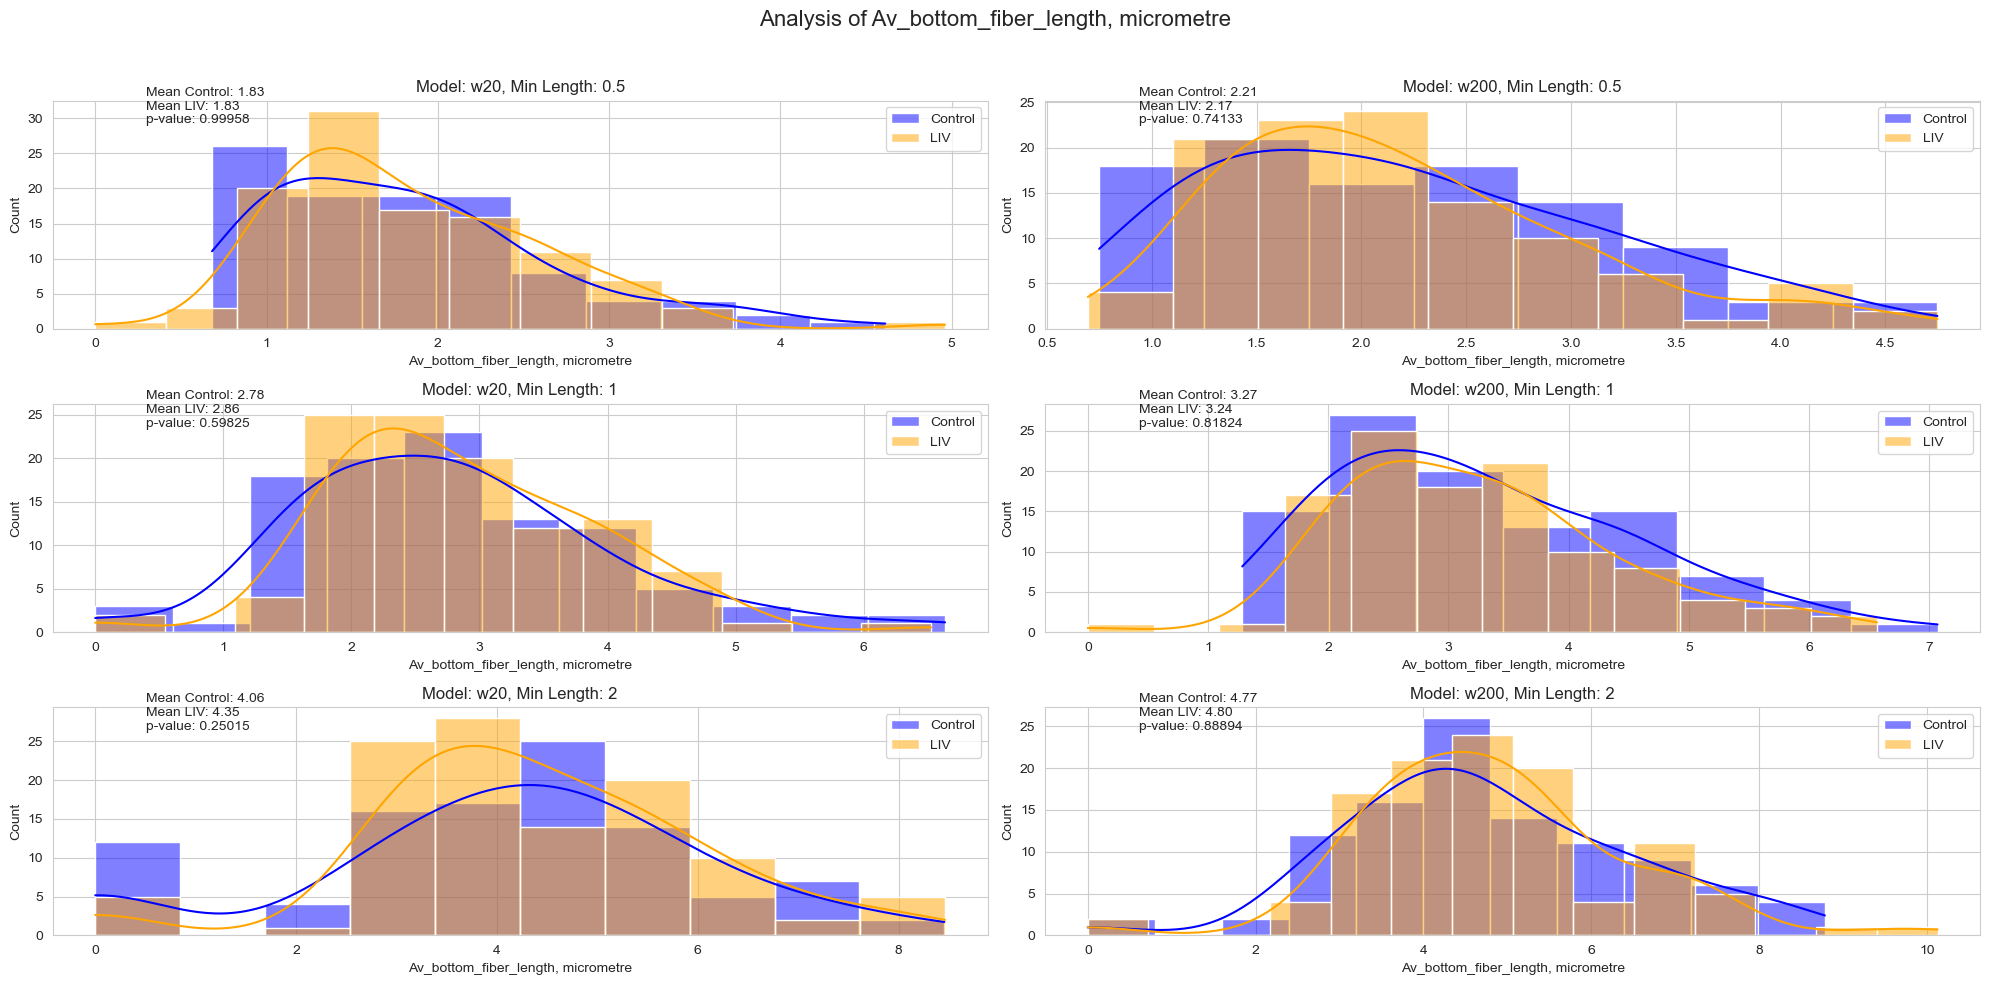

In [7]:
def calculate_average(df, numerator_column, denominator_column, output_column):
    """
    Function to calculate the average value of a column considering edge cases.

    Parameters
    ----------
    df : DataFrame
        The input DataFrame.
    numerator_column : str
        Name of the numerator column.
    denominator_column : str
        Name of the denominator column.
    output_column : str
        Name of the output column.

    Returns
    -------
    df : DataFrame
        The DataFrame with the output column.
    """
    df[output_column] = np.divide(
        df[numerator_column],
        df[denominator_column],
        out=np.zeros_like(df[numerator_column]),
        where=df[denominator_column]!=0)
    return df

def plot_histogram_and_ttest(column):
    """
    Function to plot histogram and calculate t-test.

    Parameters
    ----------
    column : str
        Column name for which histogram and t-test is to be calculated.

    Returns
    -------
    None
    """
    fig, axes = plt.subplots(len(min_lengths), len(actin_models), figsize=(20, 10))
    fig.suptitle(f'Analysis of {column}', fontsize=16)

    min_lengths_sorted = sorted(min_lengths)
    actin_models_sorted = sorted(actin_models)

    for i, (min_length, actin_model) in enumerate(product(min_lengths_sorted, actin_models_sorted)):
        data = []
        for j, (treatment, color) in enumerate(zip(treatments, colors)):
            filtered_df = aggregated_statistics_df[(aggregated_statistics_df['treatment'] == treatment) &
                                                   (aggregated_statistics_df['actin_model'] == actin_model) &
                                                   (aggregated_statistics_df['min_len_threshold'] == min_length)]
            data.append(filtered_df[column].values)

            sns.histplot(data=filtered_df, x=column, kde=True, color=color, ax=axes[i//len(actin_models)][i%len(actin_models)], label=treatment)

        t_stat, p_val = ttest_ind(*data, nan_policy='omit')

        axes[i//len(actin_models)][i%len(actin_models)].text(0.1, 0.9, f'Mean Control: {np.mean(data[0]):.2f}\nMean LIV: {np.mean(data[1]):.2f}\np-value: {p_val:.5f}',
                                                    transform=axes[i//len(actin_models)][i%len(actin_models)].transAxes, fontsize=10)

        axes[i//len(actin_models)][i%len(actin_models)].set_title(f'Model: {actin_model}, Min Length: {min_length}')
        axes[i//len(actin_models)][i%len(actin_models)].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    fig.savefig(f"figures/{column}_histogram.png")

columns_pairs = [
    ("Total_fiber_volume, cubic_micrometre", "Total_fiber_num", "Av_total_fiber_volume, cubic_micrometre"),
    ("Cap_fiber_volume, cubic_micrometre", "Cap_fiber_num", "Av_cap_fiber_volume, cubic_micrometre"),
    ("Bottom_fiber_volume, cubic_micrometre", "Bottom_fiber_num", "Av_bottom_fiber_volume, cubic_micrometre"),
    ("Total_fiber_length, micrometre", "Total_fiber_num", "Av_total_fiber_length, micrometre"),
    ("Cap_fiber_length, micrometre", "Cap_fiber_num", "Av_cap_fiber_length, micrometre"),
    ("Bottom_fiber_length, micrometre", "Bottom_fiber_num", "Av_bottom_fiber_length, micrometre")
]

for numerator, denominator, output in columns_pairs:
    aggregated_statistics_df = calculate_average(aggregated_statistics_df, numerator, denominator, output)

fiber_columns = ["Total_fiber_num", "Cap_fiber_num",
           "Bottom_fiber_num", "Total_fiber_volume, cubic_micrometre", "Cap_fiber_volume, cubic_micrometre",
           "Bottom_fiber_volume, cubic_micrometre", "Total_fiber_length, micrometre", "Cap_fiber_length, micrometre",
           "Bottom_fiber_length, micrometre", "Fiber_intensity_whole", "Fiber_intensity_cap", "Fiber_intensity_bottom",
           "F-actin_signal_intensity_whole", "F-actin_signal_intensity_cap", "F-actin_signal_intensity_bottom",
           "Branching_nodes_total, #", "Branching_nodes_cap, #", "Branching_nodes_bottom, #",
            "Av_total_fiber_volume, cubic_micrometre", "Av_cap_fiber_volume, cubic_micrometre", "Av_bottom_fiber_volume, cubic_micrometre",
            "Av_total_fiber_length, micrometre", "Av_cap_fiber_length, micrometre", "Av_bottom_fiber_length, micrometre",
            ]

for column in fiber_columns:
    plot_histogram_and_ttest(column)

Observations indicate a minor yet significant reduction in nucleus height in the LIV dataset, measuring at 5.28 micrometers compared to 5.74 micrometers in the control dataset. This equates to a 9% difference, possibly attributable to an increase in cap fiber volume. It should be noted that the total fiber volume only increases significantly for the w200 model, and not for the bottom fibers in either model.

The cap fiber volume increase is evident under varying conditions:
- w20 model, min length threshold 0.5 µm: 38 µm³ vs 24 µm³ (58% increase)
- w20 model, min length threshold 1 µm: 35 µm³ vs 22 µm³ (59% increase)
- w20 model, min length threshold 2 µm: 30 µm³ vs 19 µm³ (57% increase)
- w200 model, min length threshold 0.5 µm: 77 µm³ vs 51 µm³ (51% increase)
- w200 model, min length threshold 1 µm: 71 µm³ vs 47 µm³ (51% increase)
- w200 model, min length threshold 2 µm: 60 µm³ vs 41 µm³ (46% increase)

At the same time, cap fiber length analysis shows no significant increase. Consequently, an increase in length as a cause for greater fiber volume cannot be conclusively determined. Other influential parameters may include fiber thickness and fiber count.
The number of fibers in the actin cap reveals a significant increase (p<0.05) for the w20 model with minimal length thresholds of 0.5 and 1 micrometers:
- w20 model, min length threshold 0.5 µm: 83 fibers vs. 69 fibers (20% increase)
- w20 model, min length threshold 1 µm: 45 fibers vs. 37 fibers (18% increase)

Interestingly, the w200 model does not demonstrate a similar increase in fiber count. This could be due to the w200 model's tendency to segment larger regions on actin cross-section images, leading to closely spaced fibers merging into a single, larger fiber. This can also explain why the average fiber volume increases significantly for the w200 model.

Finally, the number of branching points in the actin cap also experiences a significant increase for all conditions, suggesting a possible alteration in the protein responsible for actin branching.


##  Individual Actin Fiber Morphological Statistics for In-depth Cellular Analysis

In [8]:
# Define treatments, actin models, min_length thresholds and colors for treatments
treatments = ['Control', 'LIV']
actin_models = ['w20', 'w200']
min_lengths = ['0.5', '1', '2']
colors = ['blue', 'orange']
parts = ['cap', 'bottom', 'whole']

columns_to_plot = ["Actin Length", "Actin Xsection", "Actin Volume"]

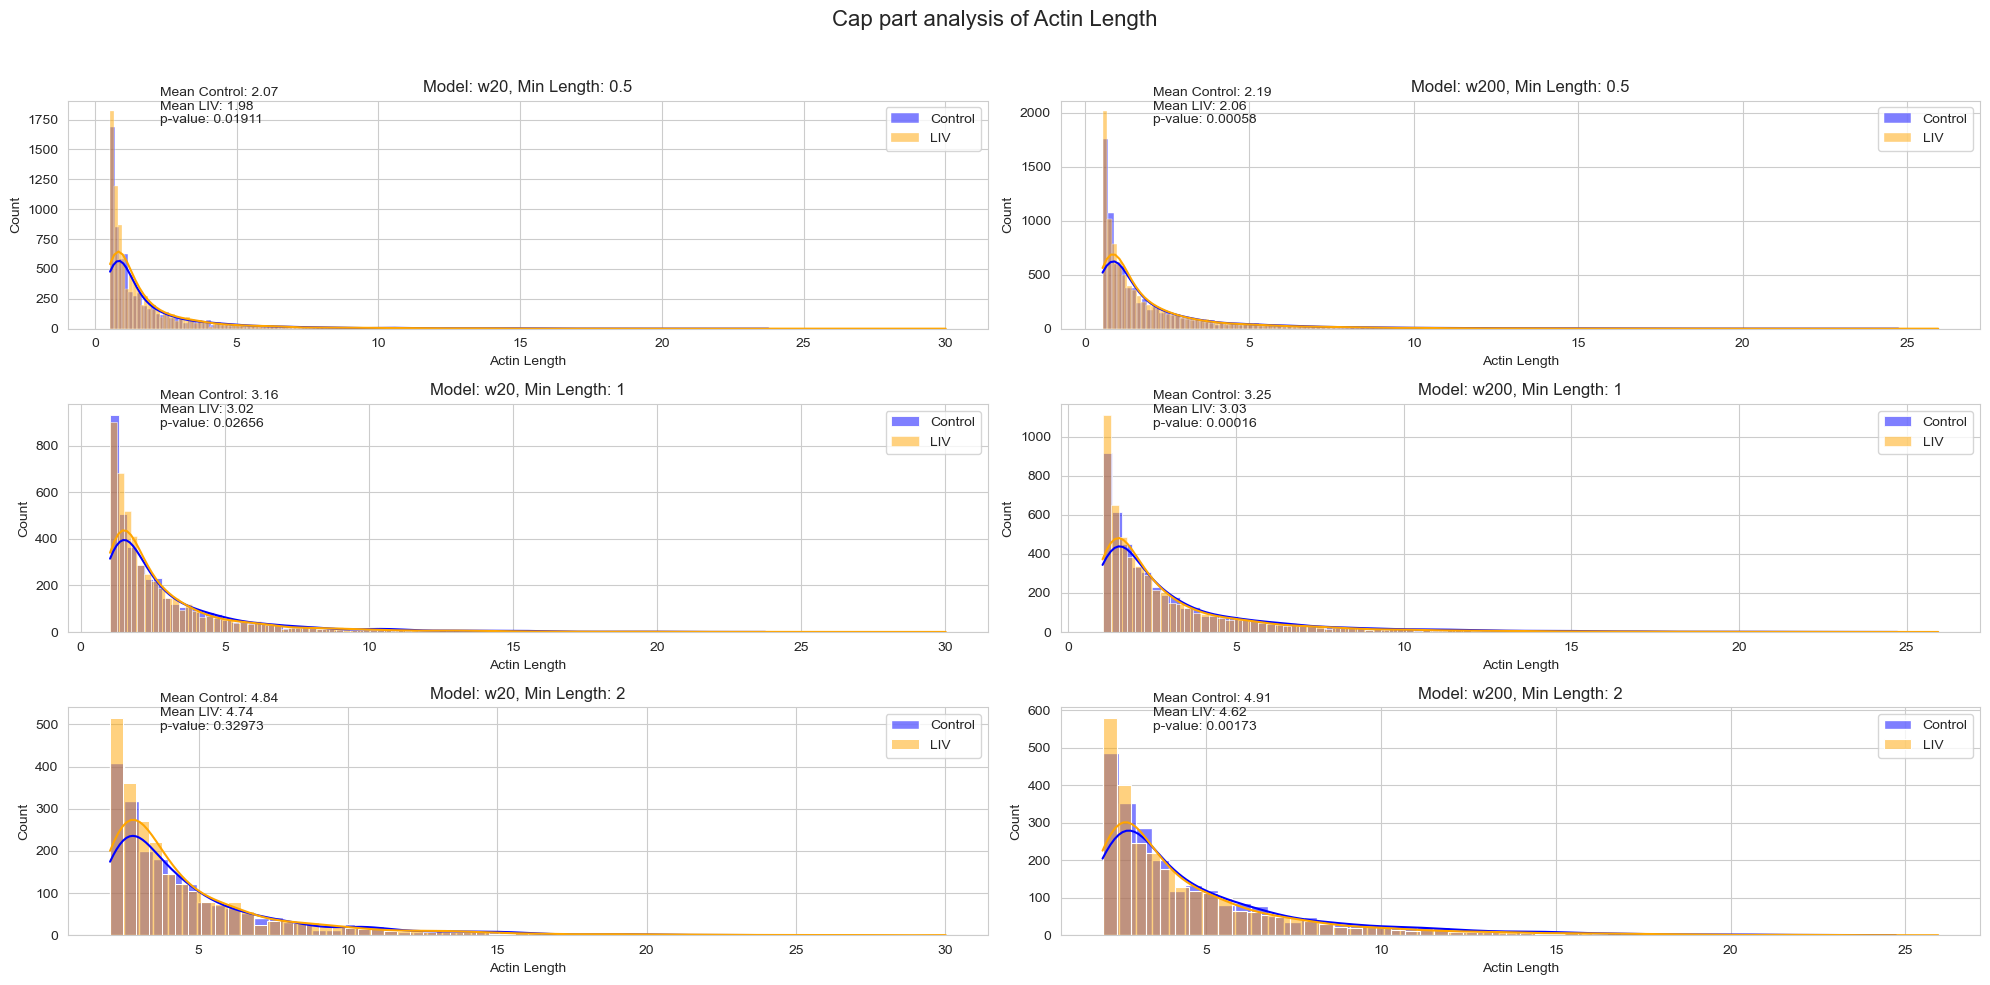

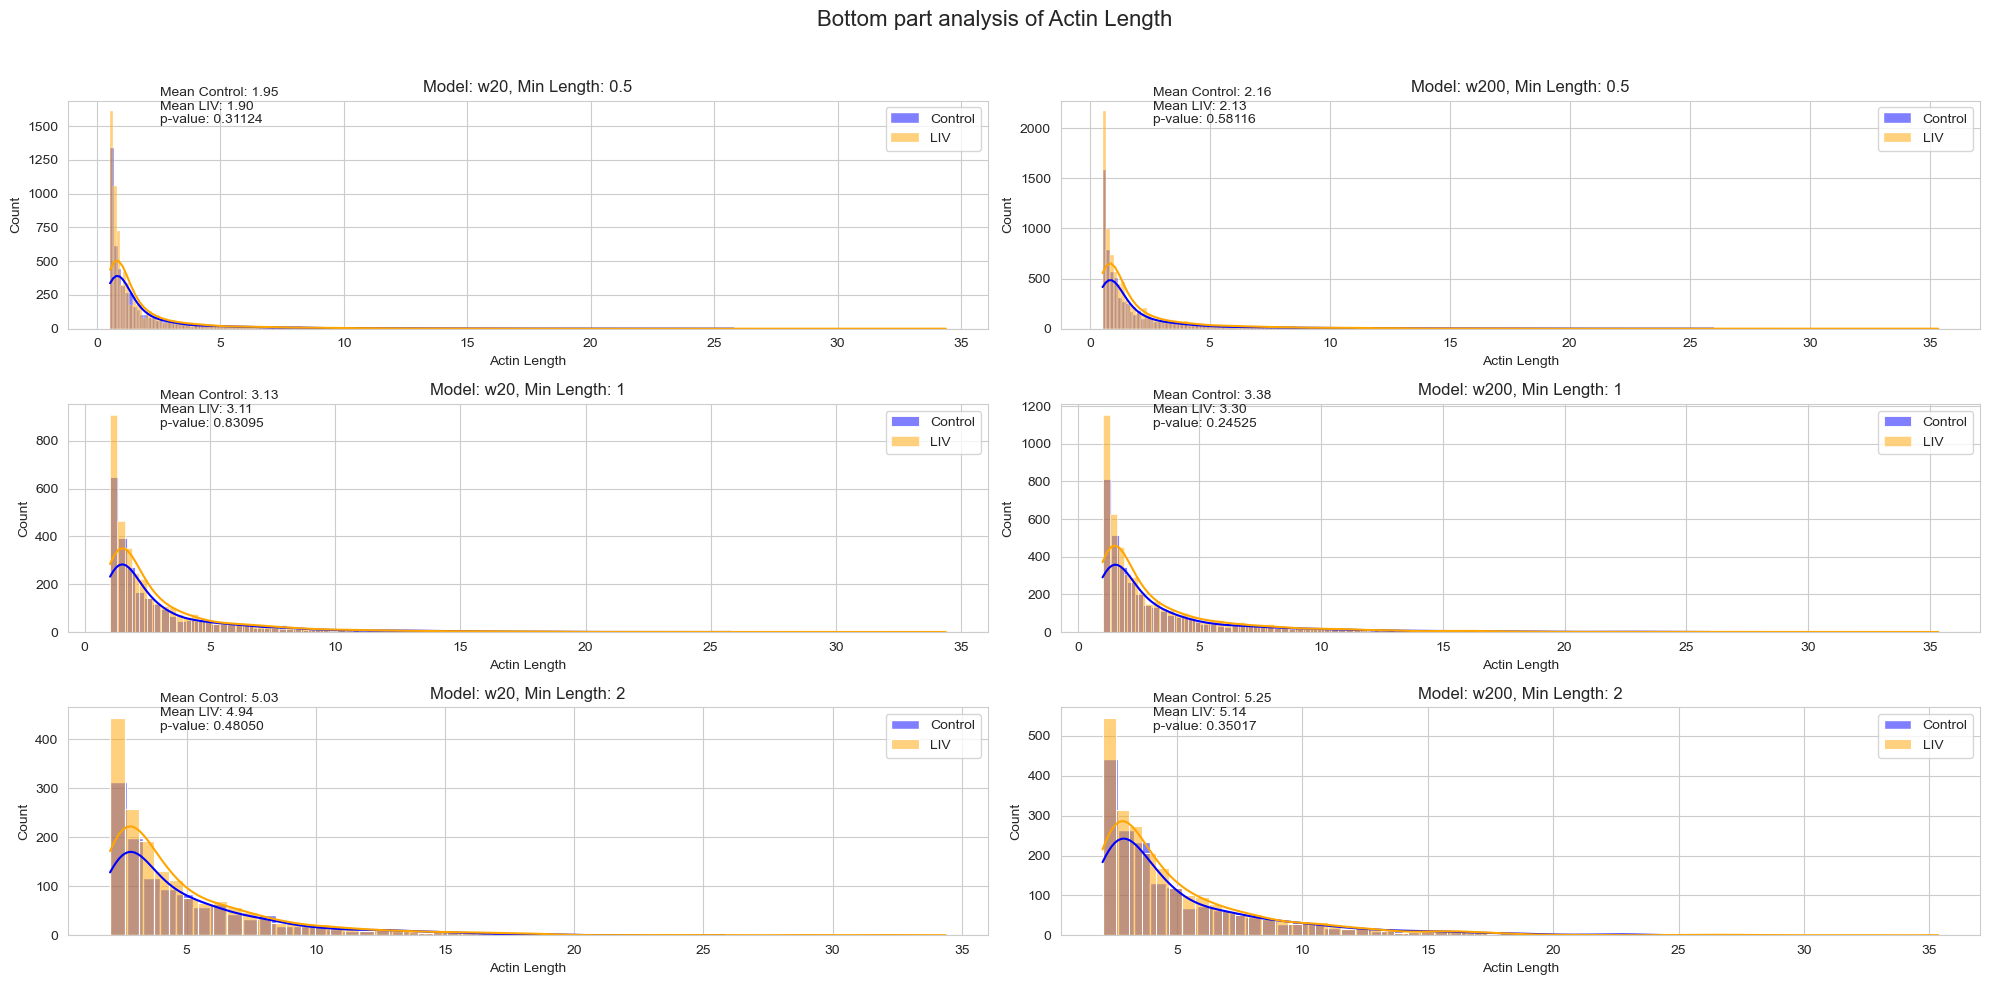

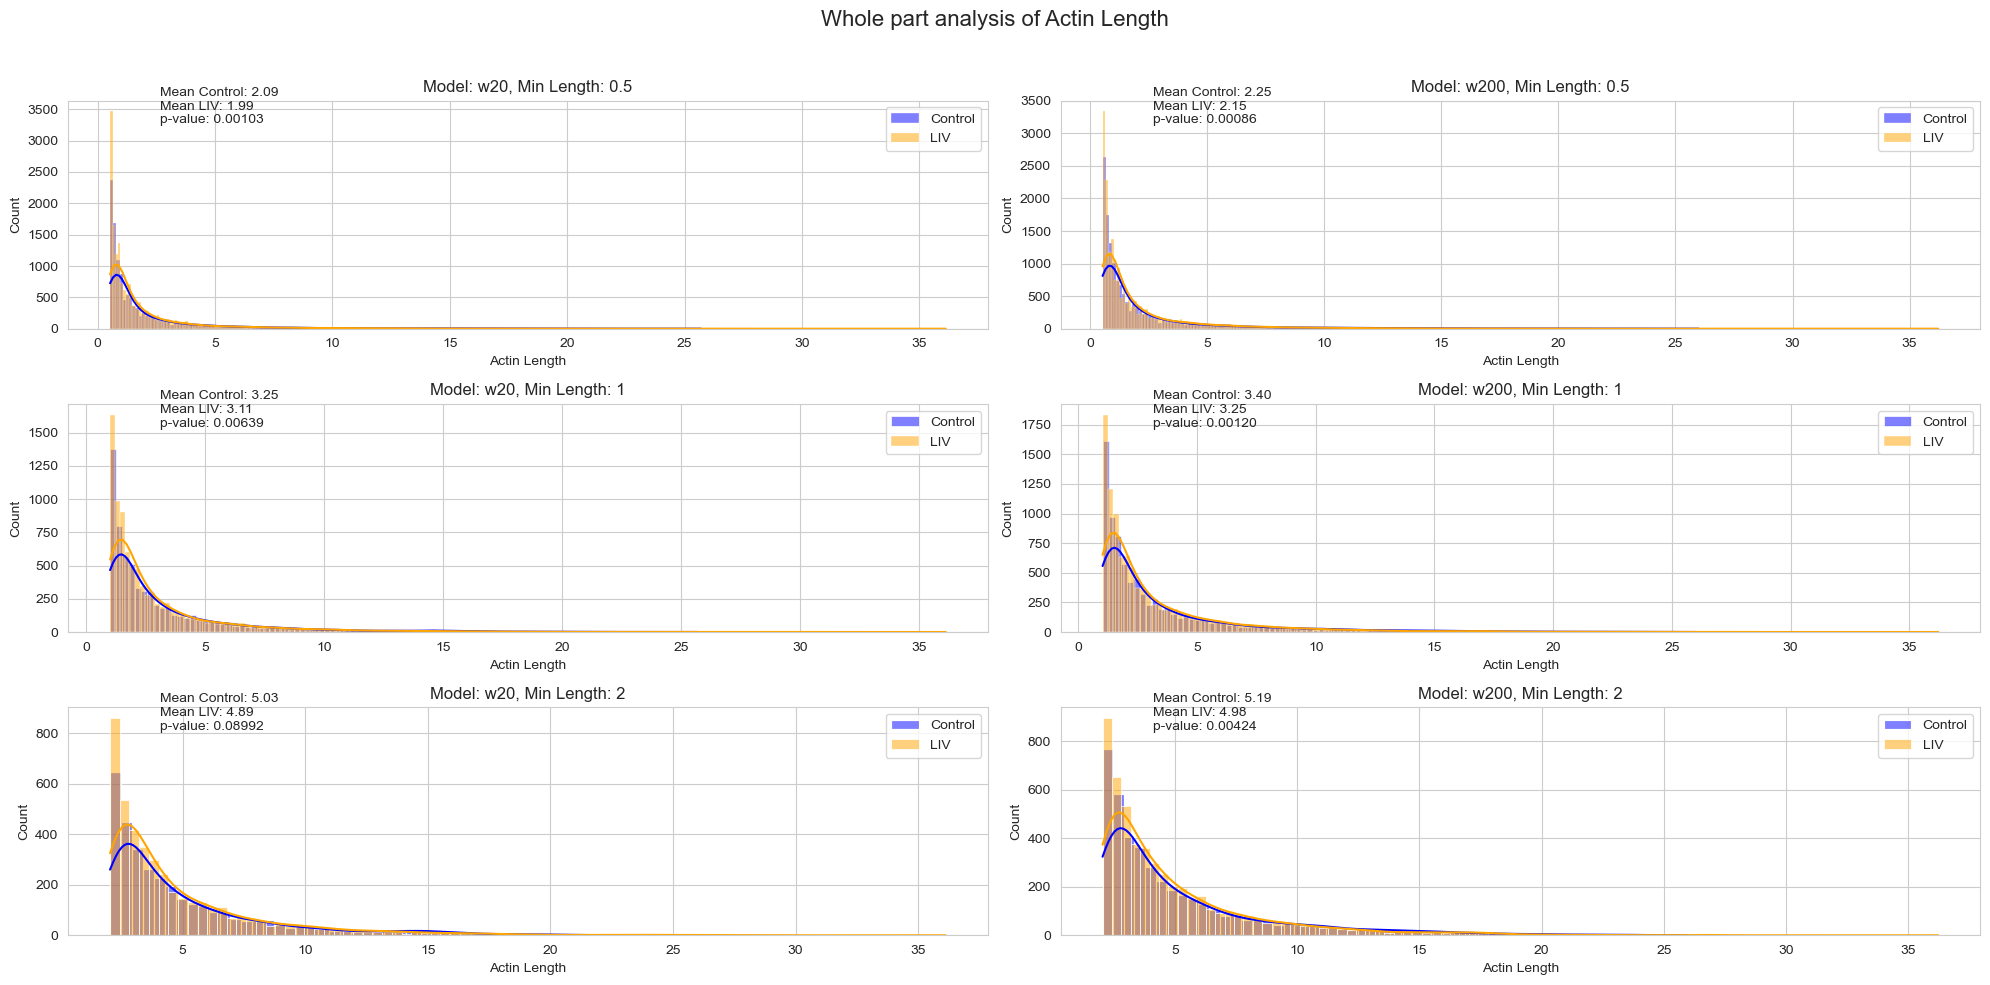

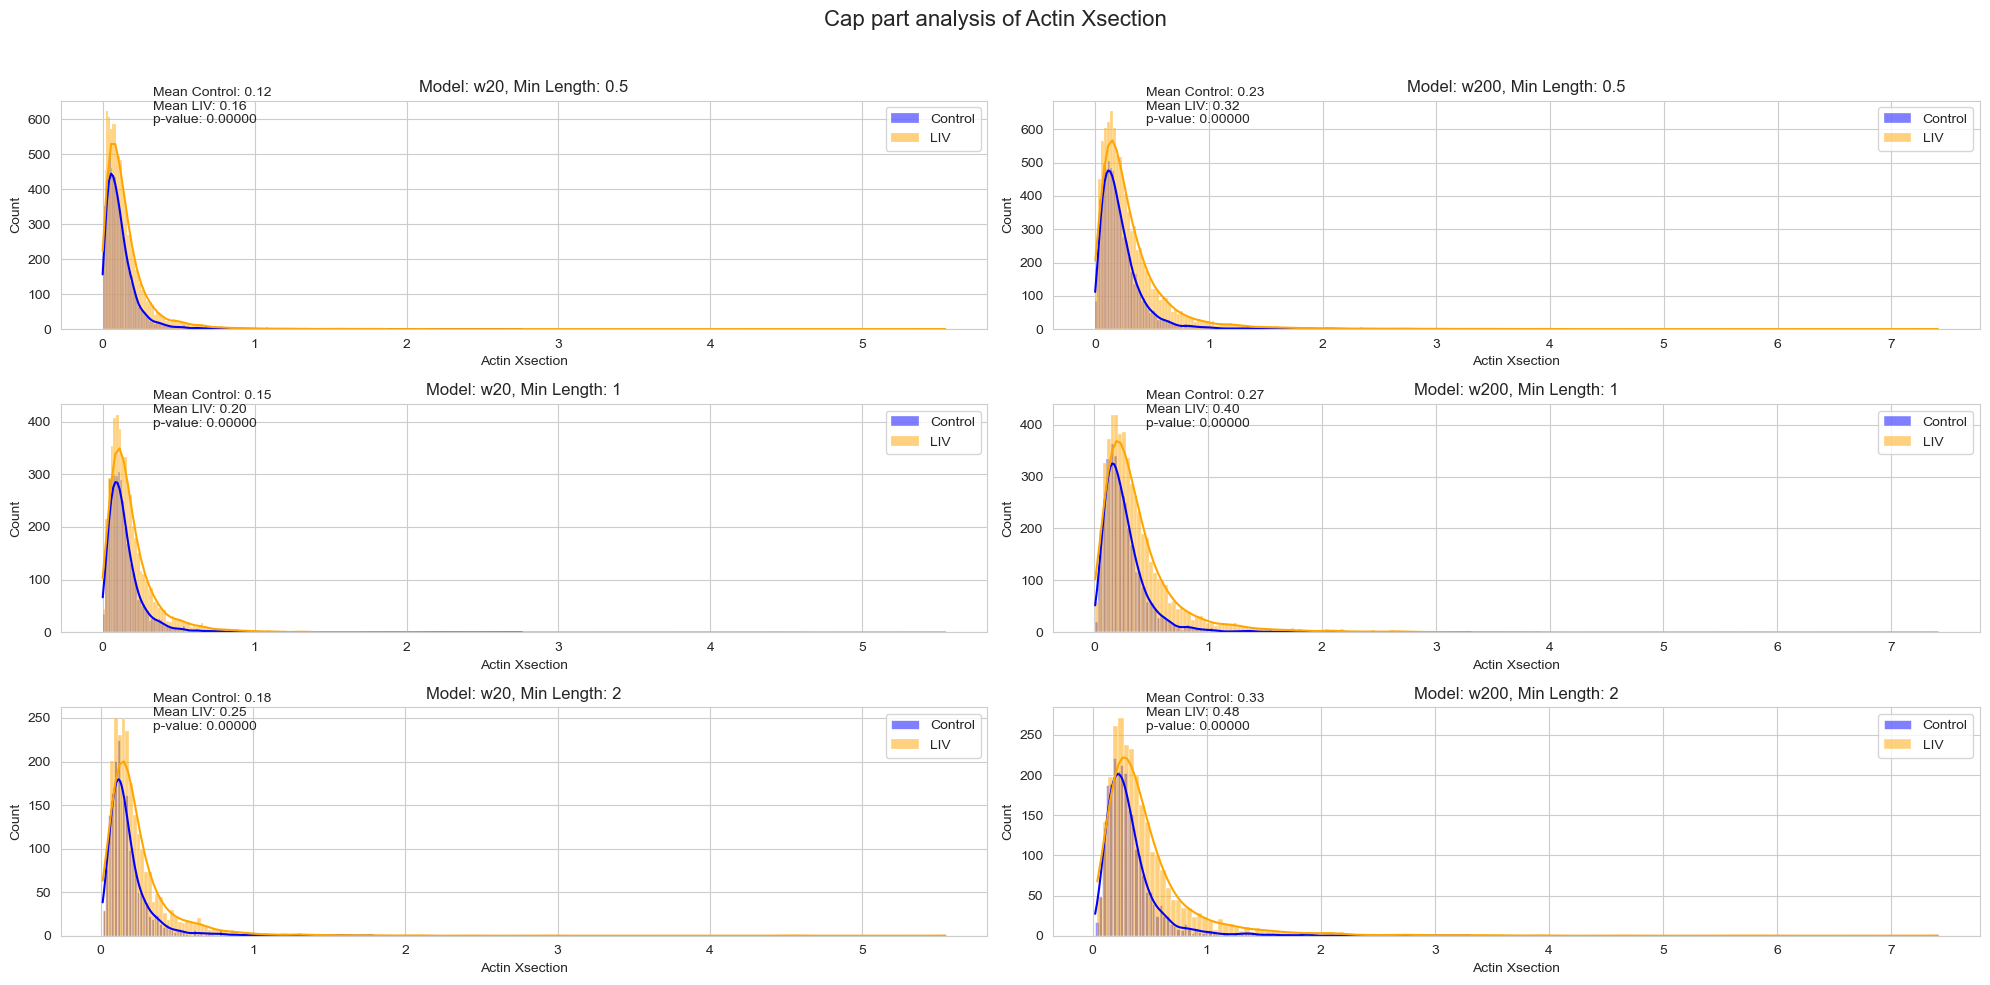

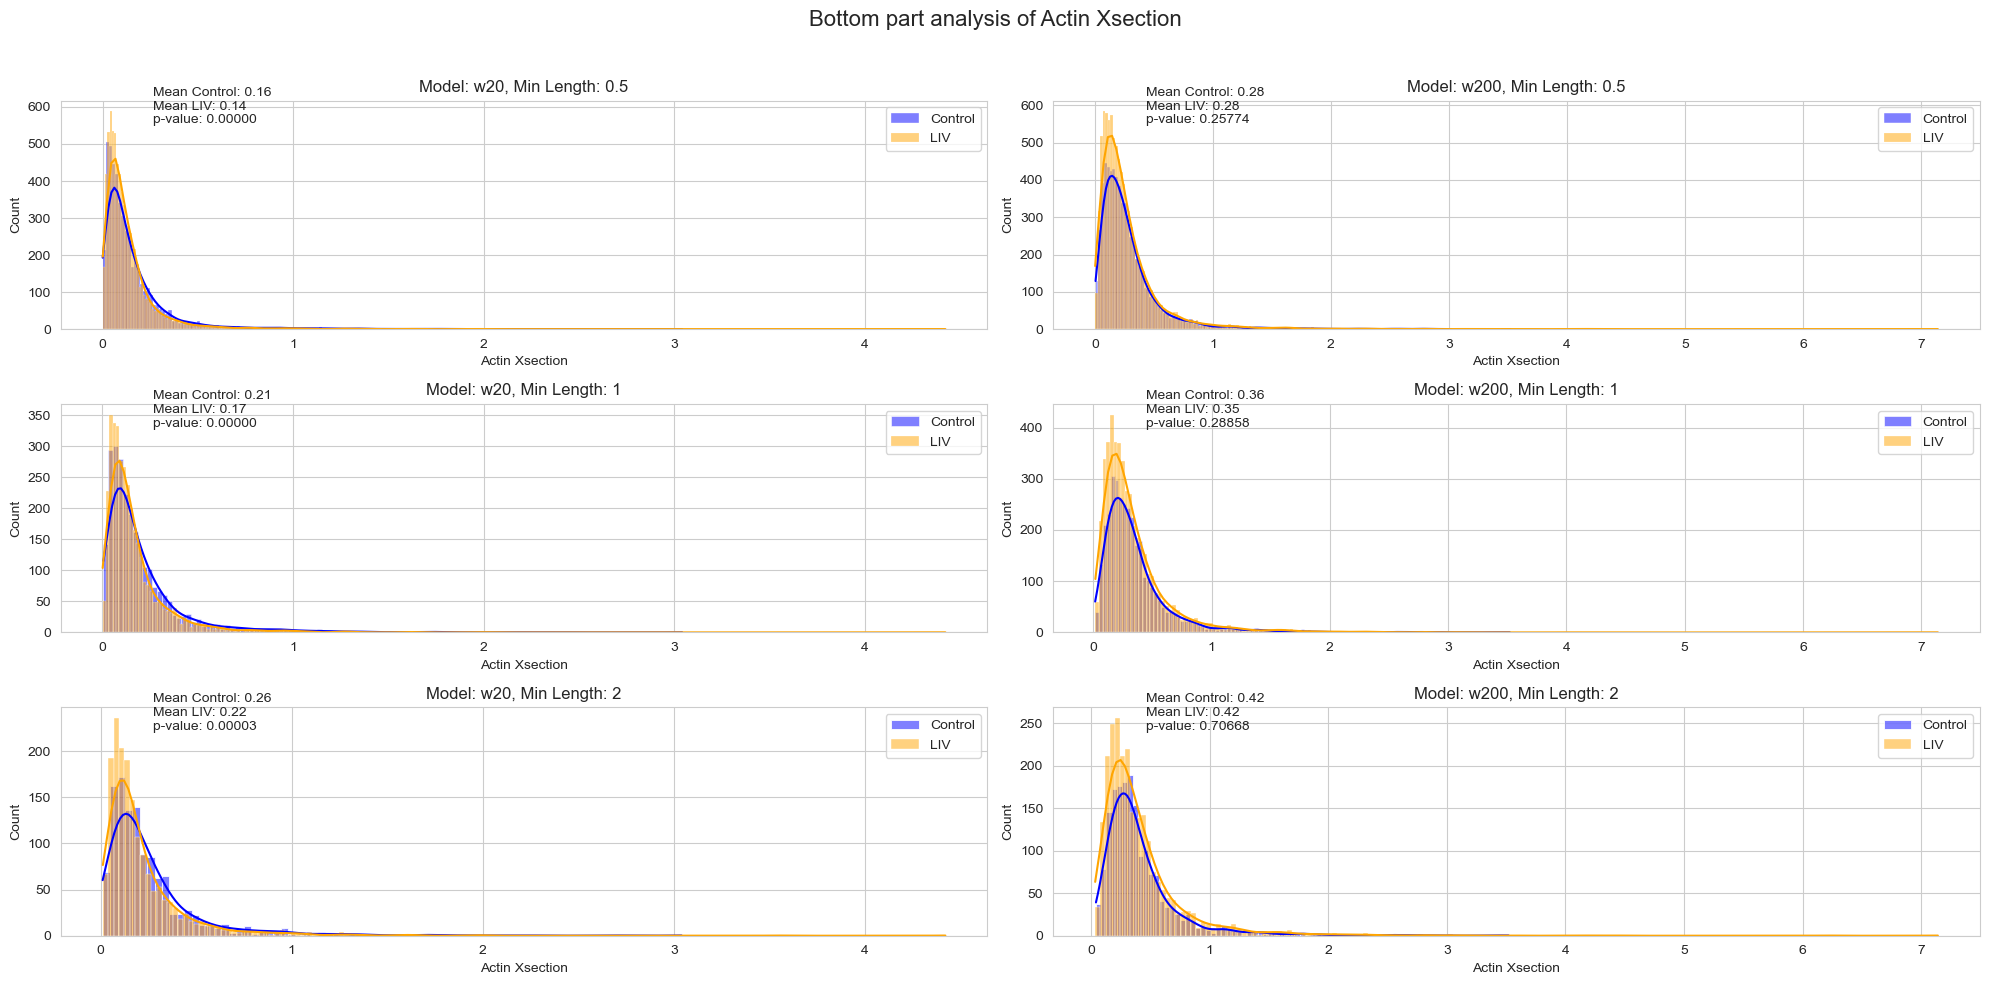

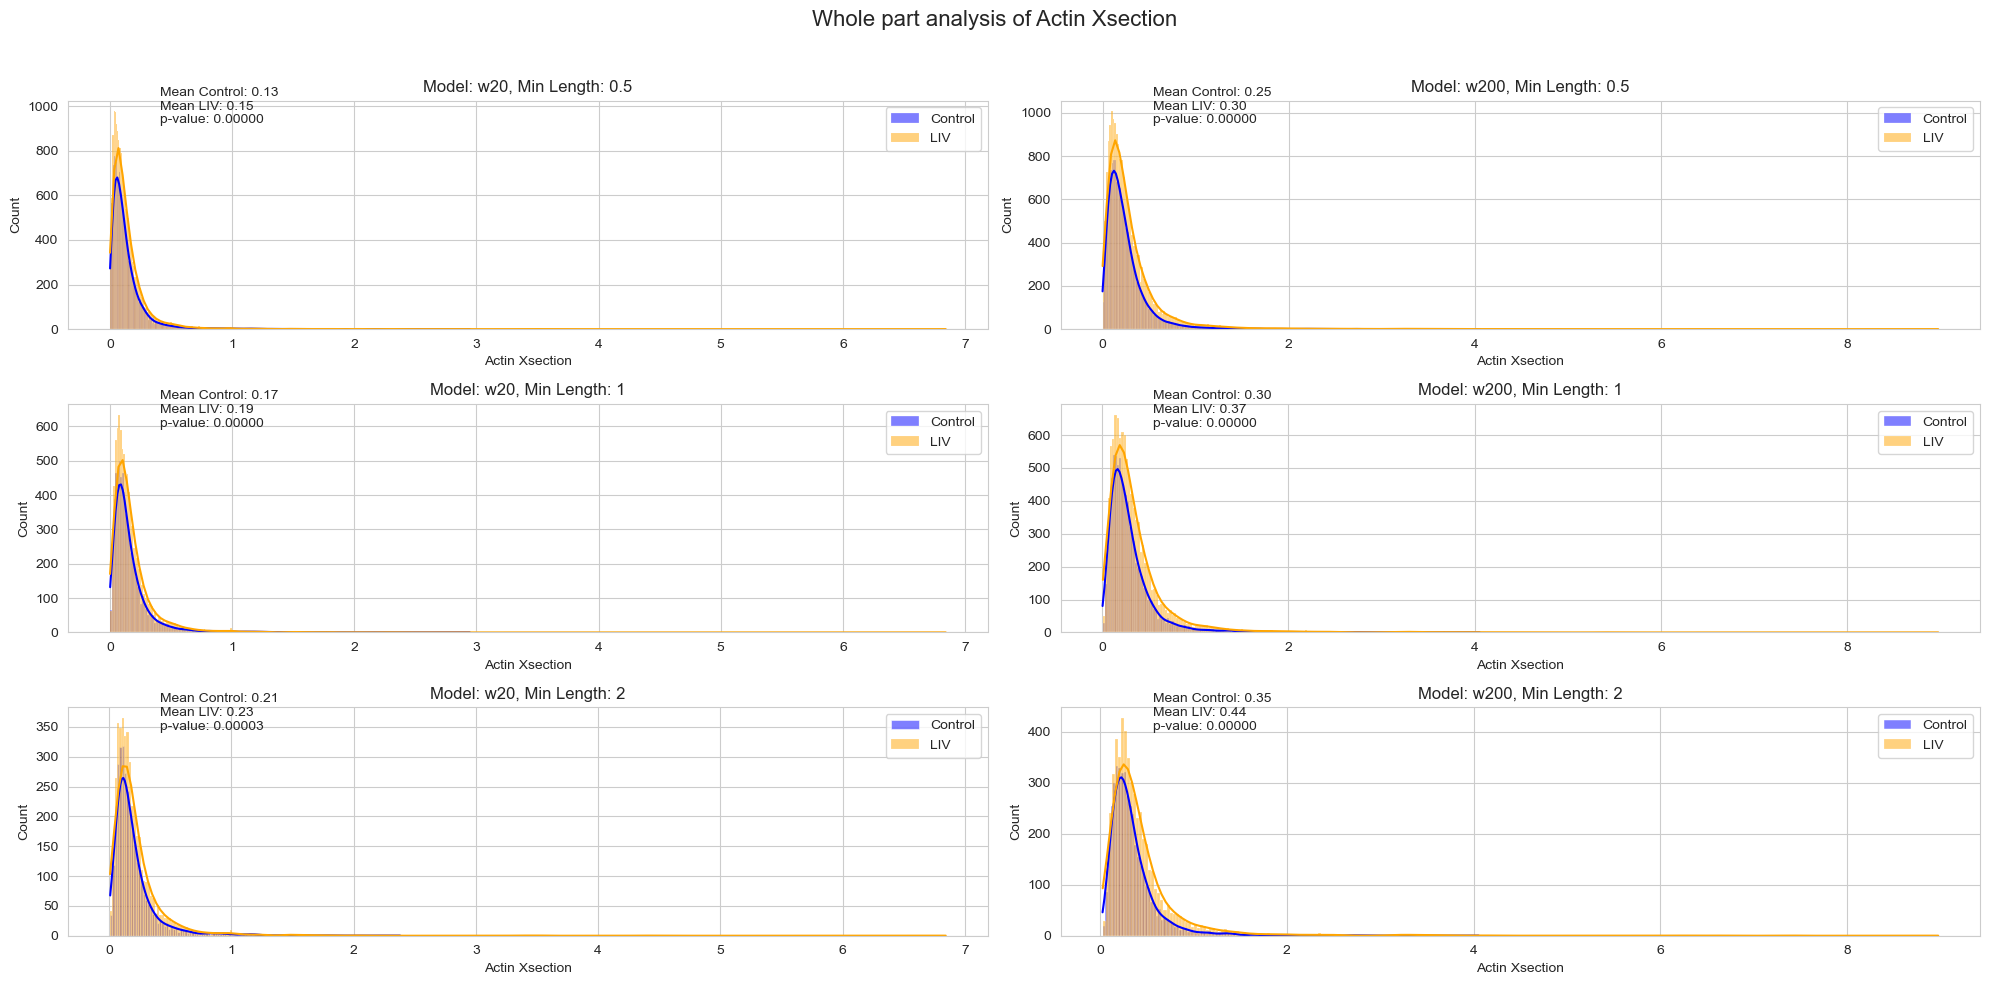

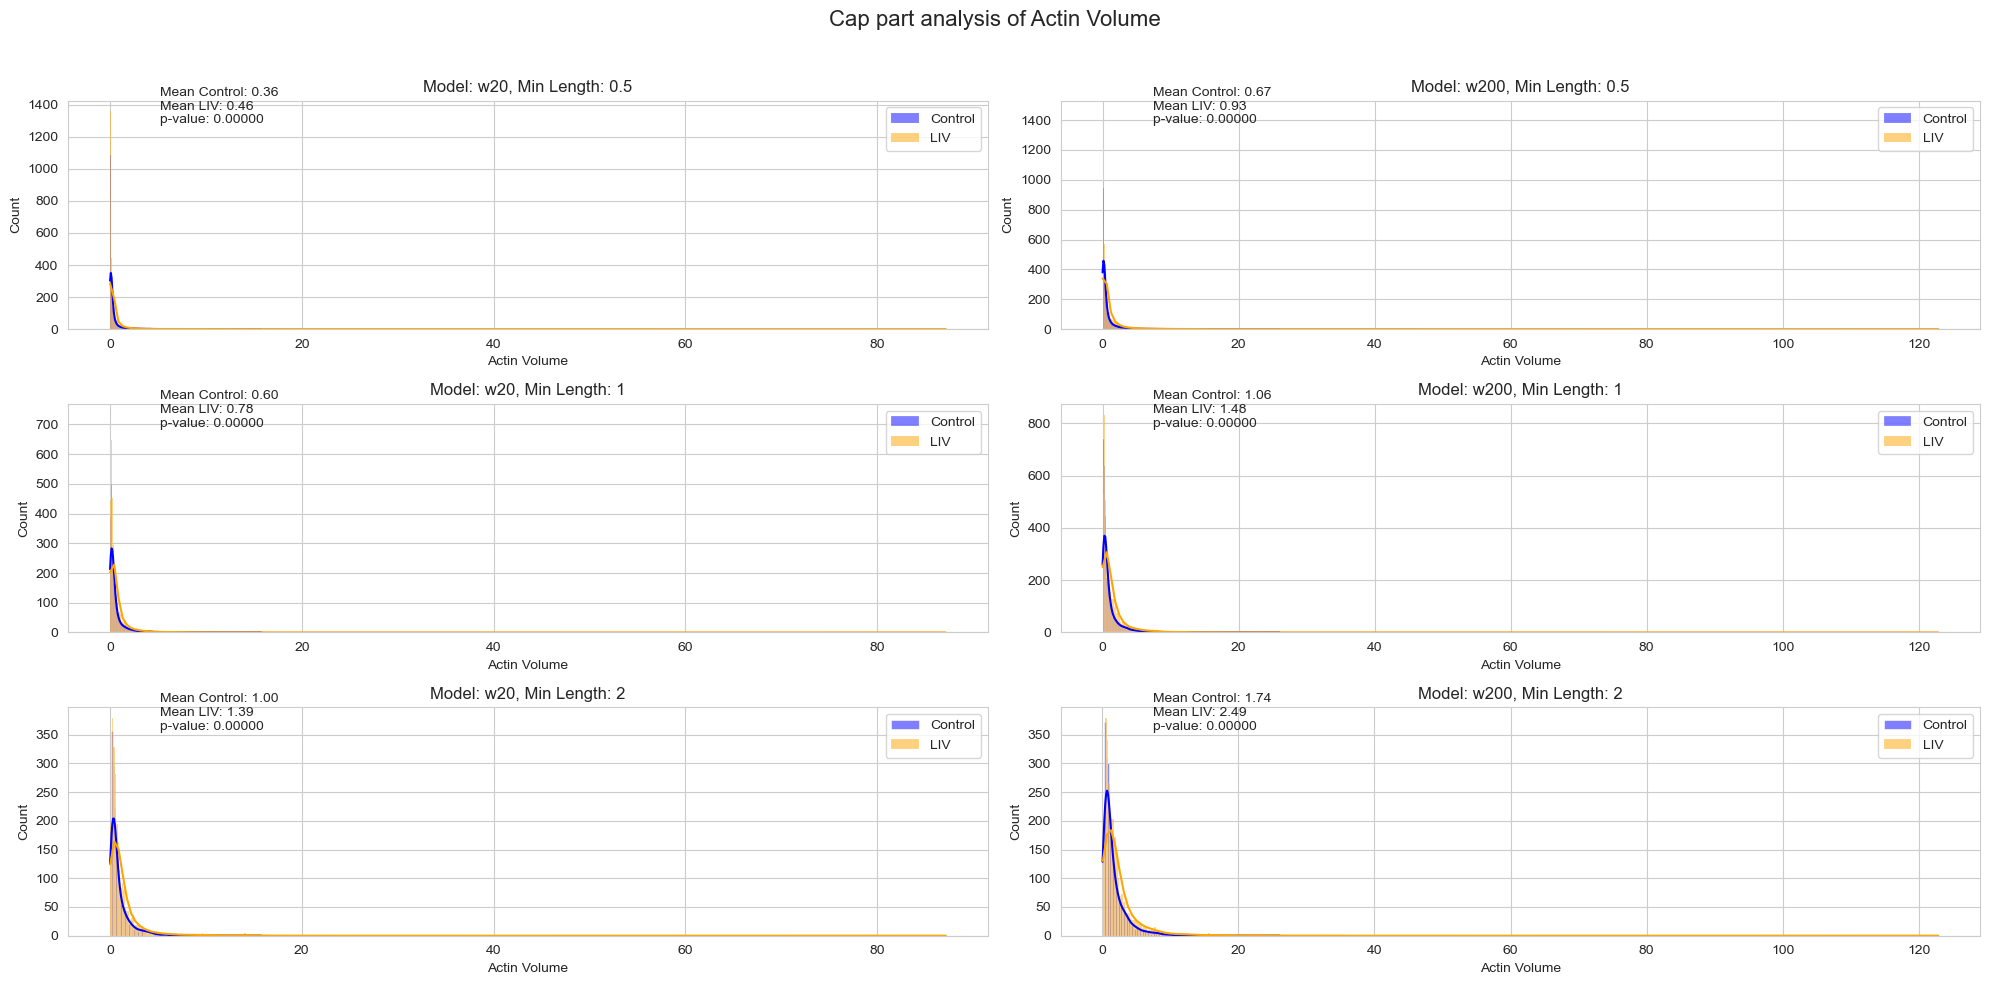

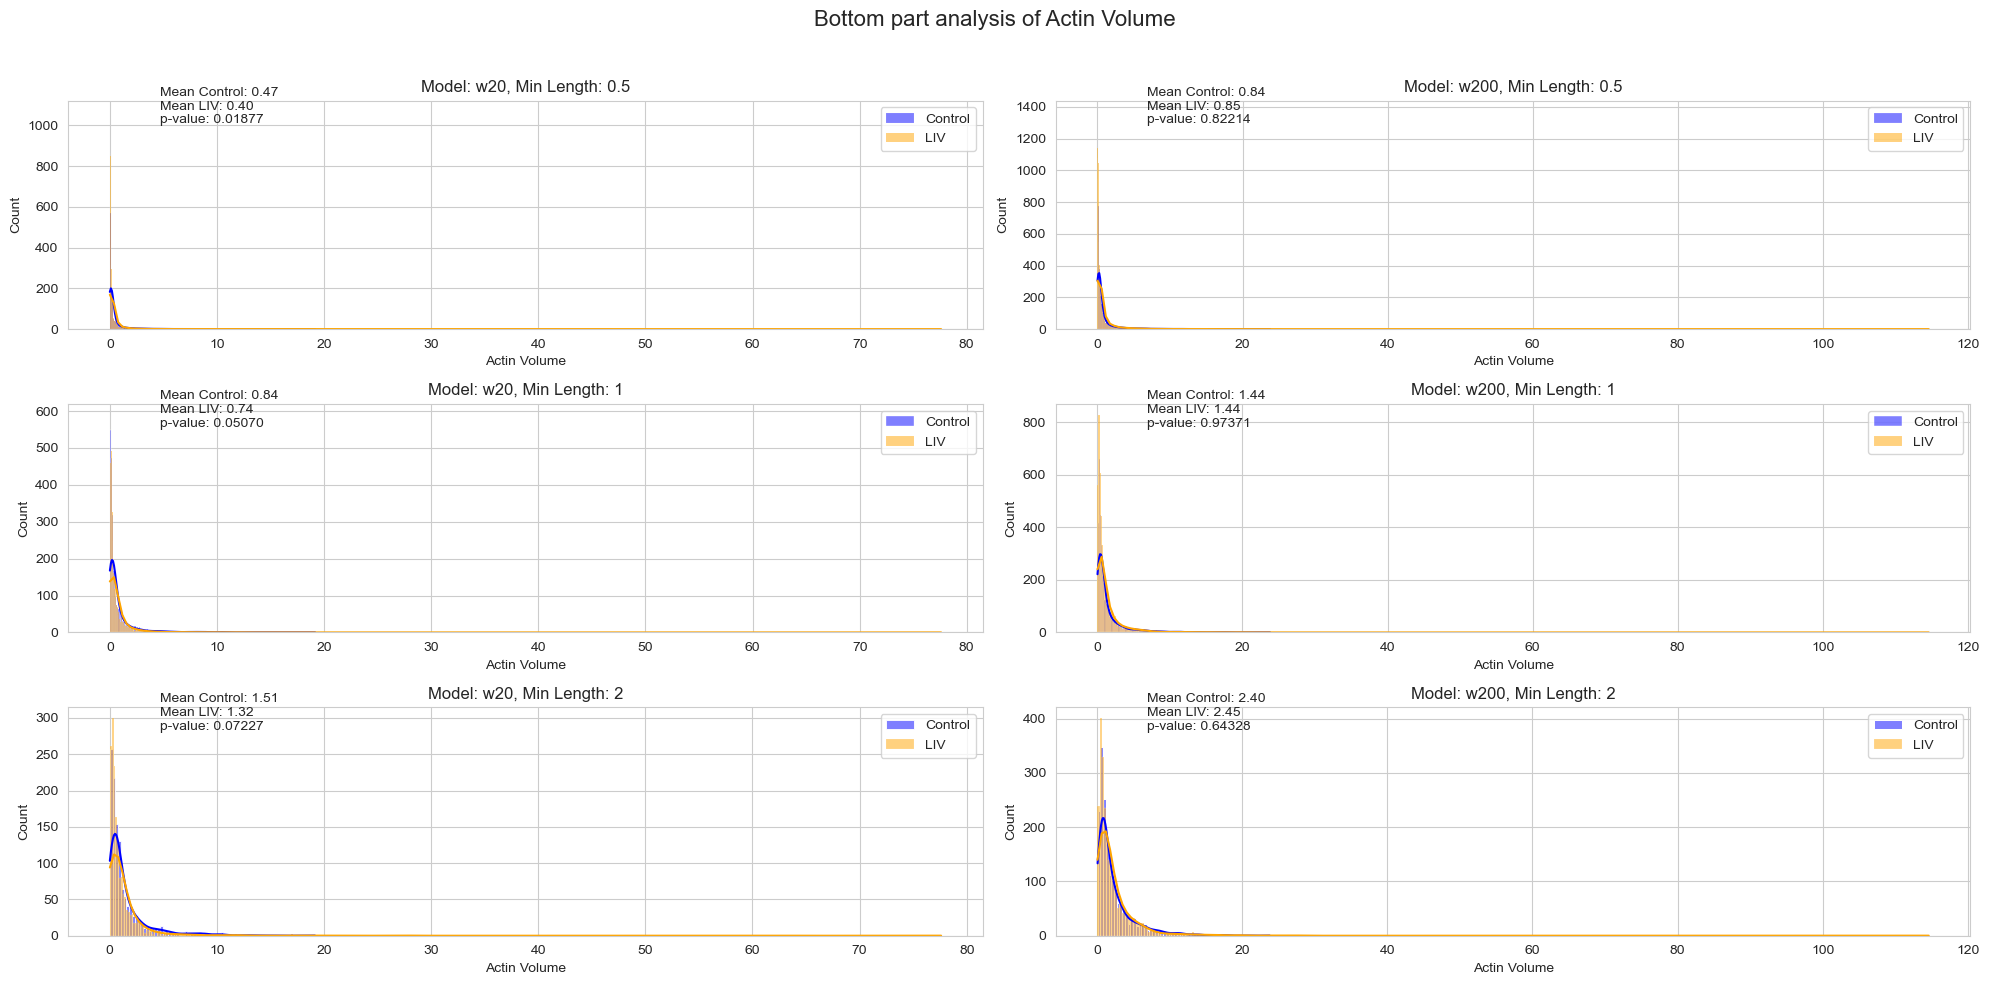

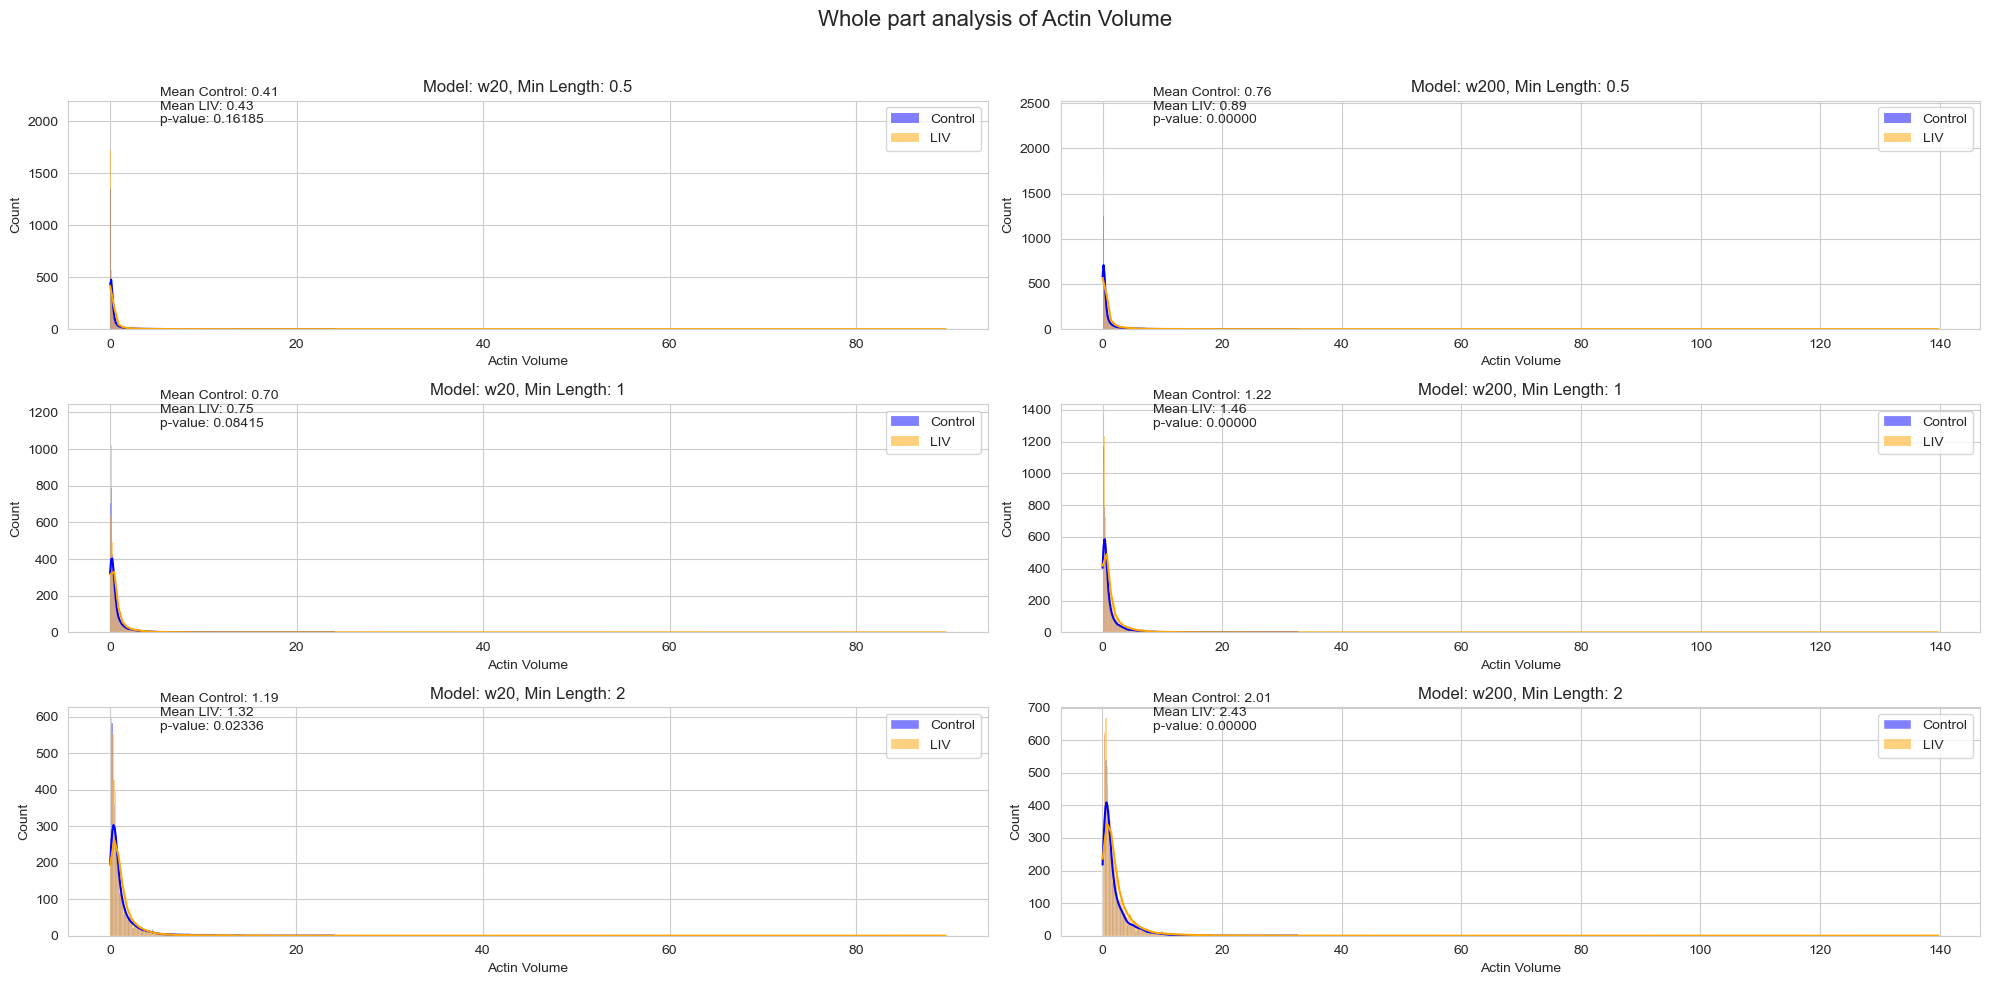

In [9]:
# For each column, create a separate figure
for column in columns_to_plot:
    for part in parts:
        # Create a figure and axes with subplots
        fig, axes = plt.subplots(len(min_lengths), len(actin_models), figsize=(20, 10))
        fig.suptitle(f'{part.capitalize()} part analysis of {column}', fontsize=16)  # Set the title for the figure

        # Sort min_lengths and actin_models to ensure correct positioning
        min_lengths_sorted = sorted(min_lengths)
        actin_models_sorted = sorted(actin_models)

        for i, (min_length, actin_model) in enumerate(product(min_lengths_sorted, actin_models_sorted)):
            data = []
            for j, (treatment, color) in enumerate(zip(treatments, colors)):
                # Filter dataframe based on conditions
                filtered_df = individual_actin_statistics_df[(individual_actin_statistics_df['treatment'] == treatment) &
                                                            (individual_actin_statistics_df['actin_model'] == actin_model) &
                                                            (individual_actin_statistics_df['min_len_threshold'] == min_length) &
                                                            (individual_actin_statistics_df['part'] == part)]
                data.append(filtered_df[column].values)  # Add data to list

                # Create histogram
                sns.histplot(data=filtered_df, x=column, kde=True, color=color, ax=axes[i//len(actin_models)][i%len(actin_models)], label=treatment)

            # Perform t-test
            t_stat, p_val = ttest_ind(*data, nan_policy='omit')  # omit NaNs

            # Add text to the subplot about mean values and p-value
            axes[i//len(actin_models)][i%len(actin_models)].text(0.1, 0.9, f'Mean Control: {np.nanmean(data[0]):.2f}\nMean LIV: {np.nanmean(data[1]):.2f}\np-value: {p_val:.5f}',
                                                            transform=axes[i//len(actin_models)][i%len(actin_models)].transAxes, fontsize=10)

            # Set title and legend
            axes[i//len(actin_models)][i%len(actin_models)].set_title(f'Model: {actin_model}, Min Length: {min_length}')
            axes[i//len(actin_models)][i%len(actin_models)].legend()

        # Display the figure with subplots
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to ensure the title fits
        plt.show()
        fig.savefig(f"figures/individual_actin_{part}_{column}_histogram.png")  # save figure as png

The presented graphs reveal significant features of actin morphology changes:

1. Actin cross-section demonstrates an increase across all three segments - the entire structure, the cap, and the bottom. This suggests a broad enhancement in the body of the actin filaments.
2. Regarding volume, we observe a substantial growth (p<0.05) in both the cap and the entirety of the actin structure, primarily driven by increases in the cap region, which range from 28% to 43%. The bottom segment does not show a consistent increase in volume across all models.
3. Changes in actin length are not as pronounced. Contrarily, all models except one (w20, min_len 2) display a marginal decrease in actin length (approximately 5% on average). This deviation might be linked to the limitations inherent in our actin length calculation algorithm. As a developer, I can infer that an increase in cross-section may potentially correspond to an increase in fiber length. A larger cross-section might represent longer actin filaments that are not parallel to the x-axis.